# Data import

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm
import seaborn as sns
import datetime as dt
import matplotlib.font_manager as fm
import random
import pickle
import datetime as dt
import itertools
import os
import holidays
import holidays


from matplotlib import gridspec
from scipy import stats
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot
from plotnine import *
from pathlib import Path


In [18]:
# BASE_DIR = Path(__name__).resolve().parent.parent
FILES_DIR = '../files/'
bidding_df = pd.read_csv(FILES_DIR + 'bidding_results.csv')

In [19]:
fm.get_fontconfig_fonts()
font_location = 'C:\\WINDOWS\\Fonts\\malgun.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\2582751676.py:1: MatplotlibDeprecationWarning: 
The get_fontconfig_fonts function was deprecated in Matplotlib 3.5 and will be removed two minor releases later.


In [20]:
bidding = bidding_df.copy()

# Null Value Processing

In [21]:
# column describe 
def descriptive_info(bidding):
    number_of_cells = bidding.count(axis=0, level=None, numeric_only=False)
    print('Total number of cells the datafile has: \n' + str(number_of_cells))
    print('\n')
    print('Printing descriptive statistics...\n\n', bidding.describe())

descriptive_info(bidding)

Total number of cells the datafile has: 
index              1337088
Impression         1337088
Click              1337088
Cost               1337088
Sum of AD rank     1337078
Bid                1337088
Price(PC)          1337088
Price(Mobile)      1337088
Delivery Fee       1337088
Category Name 1    1337088
Category Name 2    1337088
Category Name 3    1331221
Category Name 4     930132
date               1337088
dtype: int64


Printing descriptive statistics...

               index    Impression         Click          Cost  Sum of AD rank  \
count  1.337088e+06  1.337088e+06  1.337088e+06  1.337088e+06    1.337078e+06   
mean   5.167098e+06  4.412753e+01  7.189467e-01  1.800053e+02    1.138271e+01   
std    2.655813e+06  3.434510e+02  3.423456e+00  1.772706e+03    1.323231e+01   
min    2.578600e+04  0.000000e+00  0.000000e+00  0.000000e+00    1.000000e+00   
25%    3.300168e+06  3.000000e+00  0.000000e+00  0.000000e+00    3.706897e+00   
50%    4.637081e+06  1.000000e+01  0.000000

In [22]:
# bidding 날짜 datetime으로 만들기
def _trans_date_time(bidding):
    bidding.index = pd.to_datetime(bidding['date'], format='%Y%m%d')
    bidding.drop('date', axis=1, inplace=True)
    return bidding

_trans_date_time(bidding)

index  Impression  Click   Cost  Sum of AD rank  Bid  Price(PC)  \
date                                                                            
2022-10-31  3575092           3      0    0.0        3.000000   50     165900   
2022-10-31  3575637           6      0    0.0        3.333333   50      10900   
2022-10-31  4129259           7      0    0.0        8.000000   50     255000   
2022-10-31  4131479          36      3  150.0        4.416667  140     190000   
2022-10-31  4131482         224      0    0.0        5.696429   50     129000   
...             ...         ...    ...    ...             ...  ...        ...   
2023-01-03  2566795           5      0    0.0       13.200000  500      19900   
2023-01-03  2566880           3      0    0.0       17.000000  500      23900   
2023-01-03  2566881           1      0    0.0        8.000000  500       2500   
2023-01-03  2566891           2      0    0.0        4.000000  500      21000   
2023-01-03  2566923          14      0    0.0       12.428571  500     128800   

            Price(Mobile)  Delivery Fee Category Name 1 Category Name 2  \
date                                                                      
2022-10-31         165900             0         가구/인테리어            침실가구   
2022-10-31          10900             0         가구/인테리어          인테리어소품   
2022-10-31         255000            -1         가구/인테리어            거실가구   
2022-10-31         190000         20000         가구/인테리어        아동/주니어가구   
2022-10-31         129000             0         가구/인테리어        아동/주니어가구   
...                   ...           ...             ...             ...   
2023-01-03          19900             0         가구/인테리어          인테리어소품   
2023-01-03          23900          3000           생활/건강         문구/사무용품   
2023-01-03           2500          3000         가구/인테리어          인테리어소품   
2023-01-03          21000          3000           생활/건강         정원/원예용품   
2023-01-03         128800             0         가구/인테리어          인테리어소품   

           Category Name 3 Category Name 4  
date                                        
2022-10-31         장롱/붙박이장            드레스룸  
2022-10-31        아로마/캔들용품      아로마방향제/디퓨저  
2022-10-31              소파           패브릭소파  
2022-10-31          책상의자세트             NaN  
2022-10-31              책상             NaN  
...                    ...             ...  
2023-01-03        아로마/캔들용품      아로마방향제/디퓨저  
2023-01-03        이벤트/파티용품            데코용품  
2023-01-03          기타장식용품             NaN  
2023-01-03            화분받침             NaN  
2023-01-03              액자      퍼즐/그림/사진액자  

[1337088 rows x 13 columns]

In [23]:
# CTR = 클릭률
# CPC = 클릭당 비용
# CPM = 1000회 노출당 비용
# Sum of AD rank = 반올림
bidding["CTR"] = (bidding["Click"]/bidding["Impression"]) * 100
bidding["CPC"] = (bidding["Cost"]/bidding["Click"])
bidding["CPM"] = (bidding["Click"]/bidding["Cost"])
bidding['Sum of AD rank'] = bidding['Sum of AD rank'].round(0)

In [24]:
bidding_drop_null = bidding.copy()
bidding_drop_null['Category Name 4'].fillna('null_cat4', inplace = True)
bidding_drop_null['CPC'].fillna(0, inplace = True)
bidding_drop_null['CPM'].fillna(0, inplace = True)
bidding_drop_null.dropna(axis = 0, inplace = True)
print(bidding_drop_null.isnull().sum().sort_values(ascending=False)) # null값 퍼센트로 표현

index              0
Impression         0
Click              0
Cost               0
Sum of AD rank     0
Bid                0
Price(PC)          0
Price(Mobile)      0
Delivery Fee       0
Category Name 1    0
Category Name 2    0
Category Name 3    0
Category Name 4    0
CTR                0
CPC                0
CPM                0
dtype: int64


In [25]:
bidding_drop_null

index  Impression  Click   Cost  Sum of AD rank  Bid  Price(PC)  \
date                                                                            
2022-10-31  3575092           3      0    0.0             3.0   50     165900   
2022-10-31  3575637           6      0    0.0             3.0   50      10900   
2022-10-31  4129259           7      0    0.0             8.0   50     255000   
2022-10-31  4131479          36      3  150.0             4.0  140     190000   
2022-10-31  4131482         224      0    0.0             6.0   50     129000   
...             ...         ...    ...    ...             ...  ...        ...   
2023-01-03  2566795           5      0    0.0            13.0  500      19900   
2023-01-03  2566880           3      0    0.0            17.0  500      23900   
2023-01-03  2566881           1      0    0.0             8.0  500       2500   
2023-01-03  2566891           2      0    0.0             4.0  500      21000   
2023-01-03  2566923          14      0    0.0            12.0  500     128800   

            Price(Mobile)  Delivery Fee Category Name 1 Category Name 2  \
date                                                                      
2022-10-31         165900             0         가구/인테리어            침실가구   
2022-10-31          10900             0         가구/인테리어          인테리어소품   
2022-10-31         255000            -1         가구/인테리어            거실가구   
2022-10-31         190000         20000         가구/인테리어        아동/주니어가구   
2022-10-31         129000             0         가구/인테리어        아동/주니어가구   
...                   ...           ...             ...             ...   
2023-01-03          19900             0         가구/인테리어          인테리어소품   
2023-01-03          23900          3000           생활/건강         문구/사무용품   
2023-01-03           2500          3000         가구/인테리어          인테리어소품   
2023-01-03          21000          3000           생활/건강         정원/원예용품   
2023-01-03         128800             0         가구/인테리어          인테리어소품   

           Category Name 3 Category Name 4       CTR   CPC   CPM  
date                                                              
2022-10-31         장롱/붙박이장            드레스룸  0.000000   0.0  0.00  
2022-10-31        아로마/캔들용품      아로마방향제/디퓨저  0.000000   0.0  0.00  
2022-10-31              소파           패브릭소파  0.000000   0.0  0.00  
2022-10-31          책상의자세트       null_cat4  8.333333  50.0  0.02  
2022-10-31              책상       null_cat4  0.000000   0.0  0.00  
...                    ...             ...       ...   ...   ...  
2023-01-03        아로마/캔들용품      아로마방향제/디퓨저  0.000000   0.0  0.00  
2023-01-03        이벤트/파티용품            데코용품  0.000000   0.0  0.00  
2023-01-03          기타장식용품       null_cat4  0.000000   0.0  0.00  
2023-01-03            화분받침       null_cat4  0.000000   0.0  0.00  
2023-01-03              액자      퍼즐/그림/사진액자  0.000000   0.0  0.00  

[1331211 rows x 16 columns]

# Data pickle load

In [26]:
# # save and compress.
# with open('bidding_drop_null.pickle', 'wb') as f:
#     pickle.dump(bidding_drop_null, f, pickle.HIGHEST_PROTOCOL)

In [27]:
# # load
# with open('bidding_drop_null.pickle', 'rb') as f:
#     bidding_drop_null = pickle.load(f)

In [28]:
# bidding_drop_null

# Price 구간별 Cost 민감도에 따른 Rank

In [29]:
price_down_5 = bidding_drop_null[bidding_drop_null['Price(PC)'] <= 50000]

price_5_10 = bidding_drop_null[(bidding_drop_null['Price(PC)'] > 50000) & (bidding_drop_null['Price(PC)'] < 100000)]

price_10_15 = bidding_drop_null[(bidding_drop_null['Price(PC)'] > 100000) & (bidding_drop_null['Price(PC)'] < 150000)]

price_15_20 = bidding_drop_null[(bidding_drop_null['Price(PC)'] > 150000) & (bidding_drop_null['Price(PC)'] < 200000)]

price_up_20 = bidding_drop_null[bidding_drop_null['Price(PC)'] >= 200000]

In [30]:
def price_Analysis(df):
        
    print('비용평균')
    print(df['Cost'].mean())
    print('-' * 50)
    print('\n')
    
    cost_non_zero = df[df['Cost'] != 0]
    
    
    print(f'코스트 썼을때 평균 순위 : {cost_non_zero["Sum of AD rank"].mean()}')

    cost_zero = df[df['Cost'] == 0]

    print(f'코스트 안 썼을때 평균 순위 : {cost_zero["Sum of AD rank"].mean()}')
    print('-' * 50)
    print('\n')
  

    print("광고숫자비율")
    print((len(list(set(df['index'].values))) / len(df))*100)
    print('-' * 50)
    print('\n')
    
    
    rank_del_zero = df[df['Delivery Fee'] <= 0]
    rank_del_non_zero = df[df['Delivery Fee'] > 0]
    print('배달비 없음 비율')
    print((rank_del_zero.shape[0] / df['Delivery Fee'].shape[0]*100))
    print('\n')
    print('배달비 있음 비율')
    print((rank_del_non_zero.shape[0] / df['Delivery Fee'].shape[0]*100))  
    print('-' * 50)
    print('\n')
    

    print('코스트비율')
    print(df['Cost'].value_counts(normalize=True))
    print('-' * 50)
    print('\n')
    
    plt.figure(figsize=(28, 12))
    plt.subplot(4, 1, 1)
    print('코스트')
    display(cost_non_zero['Cost'].describe())
    plt.hist(cost_non_zero['Cost'], bins=20)
    plt.title('cost_non_zero')
    plt.xticks()
    
    
    print('-' * 50)
    print('\n')
    
    
    plt.subplot(4, 1, 2)
    print('카테고리1')
    display(df['Category Name 1'].value_counts(normalize=True))
    sns.countplot(x=df['Category Name 1'], data=df)
    plt.title('Category Name 1')
    plt.xticks()
    
    
    print('-' * 50)
    print('\n')
    
    
    plt.subplot(4, 1, 3)
    print('코스트 있음 , 순위')
    display(cost_non_zero['Sum of AD rank'].describe())
    plt.hist(cost_non_zero['Sum of AD rank'], bins=20)
    plt.title('cost_non_zero')
    plt.xticks()
    
    
    print('-' * 50)
    print('\n')
    
    
    plt.subplot(4, 1, 4)
    print('코스트 없음 , 순위')
    display(cost_zero['Sum of AD rank'].describe())
    plt.hist(cost_zero['Sum of AD rank'], bins=20)
    plt.title('cost_zero')
    plt.xticks()

    

비용평균
167.80673792112006
--------------------------------------------------


코스트 썼을때 평균 순위 : 6.01917086348931
코스트 안 썼을때 평균 순위 : 13.595440104968716
--------------------------------------------------


광고숫자비율
3.8164244239623955
--------------------------------------------------


배달비 없음 비율
40.11324425725326


배달비 있음 비율
59.88675574274674
--------------------------------------------------


코스트비율
0.0        0.759737
50.0       0.051082
100.0      0.017548
150.0      0.009396
200.0      0.006845
             ...   
11830.0    0.000002
8910.0     0.000002
13810.0    0.000002
12050.0    0.000002
9060.0     0.000002
Name: Cost, Length: 1739, dtype: float64
--------------------------------------------------


코스트


count    149915.000000
mean        698.428176
std        3547.304425
min          50.000000
25%          90.000000
50%         210.000000
75%         500.000000
max      246040.000000
Name: Cost, dtype: float64

--------------------------------------------------


카테고리1


가구/인테리어    0.506722
생활/건강      0.417855
출산/육아      0.026109
스포츠/레저     0.015120
패션잡화       0.012150
화장품/미용     0.010542
디지털/가전     0.007847
패션의류       0.003034
여가/생활편의    0.000372
식품         0.000250
Name: Category Name 1, dtype: float64

--------------------------------------------------


코스트 있음 , 순위


count    149915.000000
mean          6.019171
std           6.244767
min           1.000000
25%           2.000000
50%           4.000000
75%           7.000000
max          98.000000
Name: Sum of AD rank, dtype: float64

--------------------------------------------------


코스트 없음 , 순위


count    474046.000000
mean         13.595440
std          15.471149
min           1.000000
25%           4.000000
50%           8.000000
75%          16.000000
max         100.000000
Name: Sum of AD rank, dtype: float64

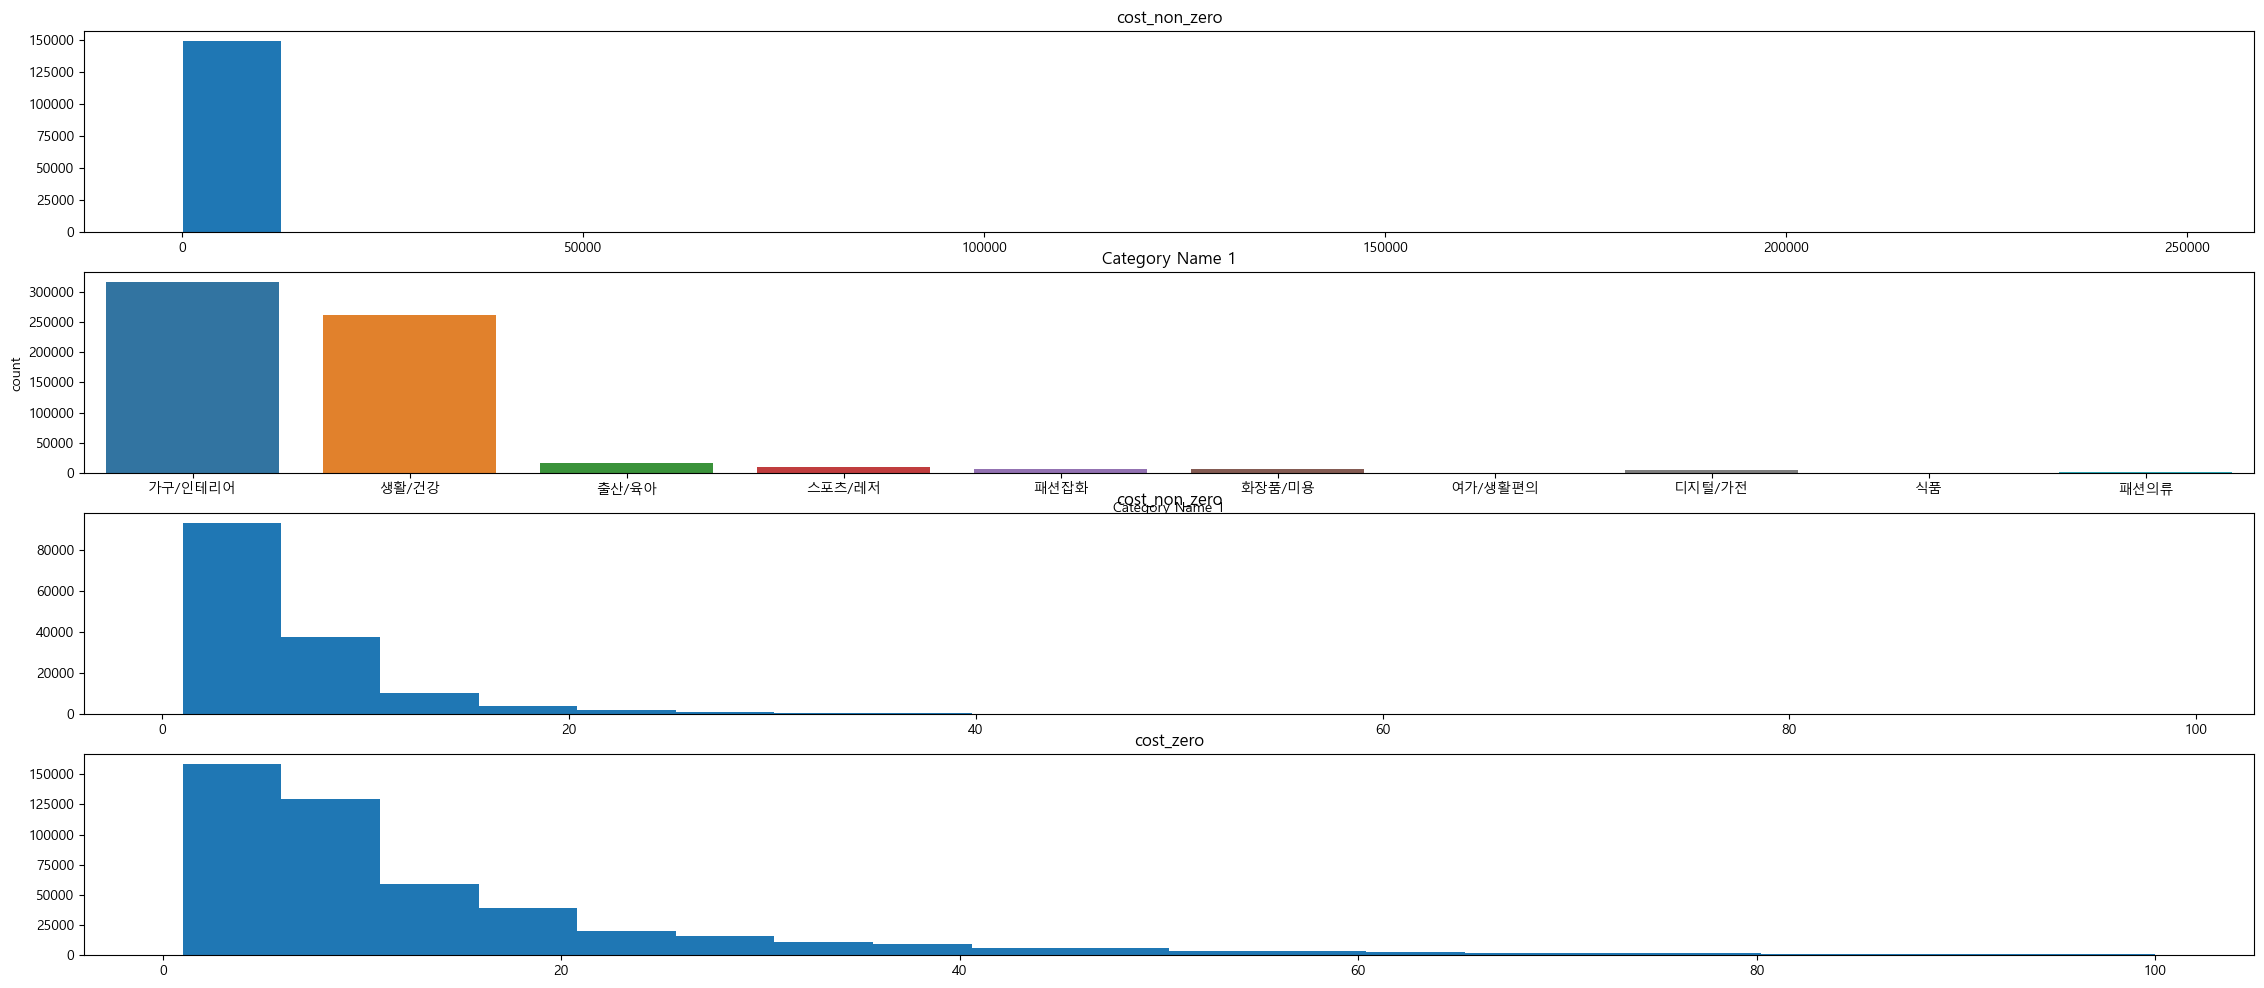

In [31]:
# 수치표현
# 그래프표현
# text = 5만원 이하 상품 가격 데이터 특징
price_Analysis(price_down_5)

비용평균
169.75988080378508
--------------------------------------------------


코스트 썼을때 평균 순위 : 6.468736928072028
코스트 안 썼을때 평균 순위 : 13.20863936834374
--------------------------------------------------


광고숫자비율
3.7204414601536326
--------------------------------------------------


배달비 없음 비율
72.29230700919132


배달비 있음 비율
27.70769299080867
--------------------------------------------------


코스트비율
0.0        0.752318
50.0       0.051270
100.0      0.017238
150.0      0.008792
200.0      0.006478
             ...   
9010.0     0.000005
7370.0     0.000005
10850.0    0.000005
86540.0    0.000005
17610.0    0.000005
Name: Cost, Length: 1053, dtype: float64
--------------------------------------------------


코스트


count     50203.000000
mean        685.393303
std        3481.783996
min          50.000000
25%          90.000000
50%         230.000000
75%         500.000000
max      325300.000000
Name: Cost, dtype: float64

--------------------------------------------------


카테고리1


가구/인테리어    0.803943
생활/건강      0.147180
출산/육아      0.022744
스포츠/레저     0.016912
화장품/미용     0.003602
디지털/가전     0.002309
여가/생활편의    0.001495
패션의류       0.000878
패션잡화       0.000671
식품         0.000266
Name: Category Name 1, dtype: float64

--------------------------------------------------


코스트 있음 , 순위


count    50203.000000
mean         6.468737
std          6.288642
min          1.000000
25%          3.000000
50%          5.000000
75%          8.000000
max         98.000000
Name: Sum of AD rank, dtype: float64

--------------------------------------------------


코스트 없음 , 순위


count    152488.000000
mean         13.208639
std          14.539568
min           1.000000
25%           4.000000
50%           8.000000
75%          16.000000
max         100.000000
Name: Sum of AD rank, dtype: float64

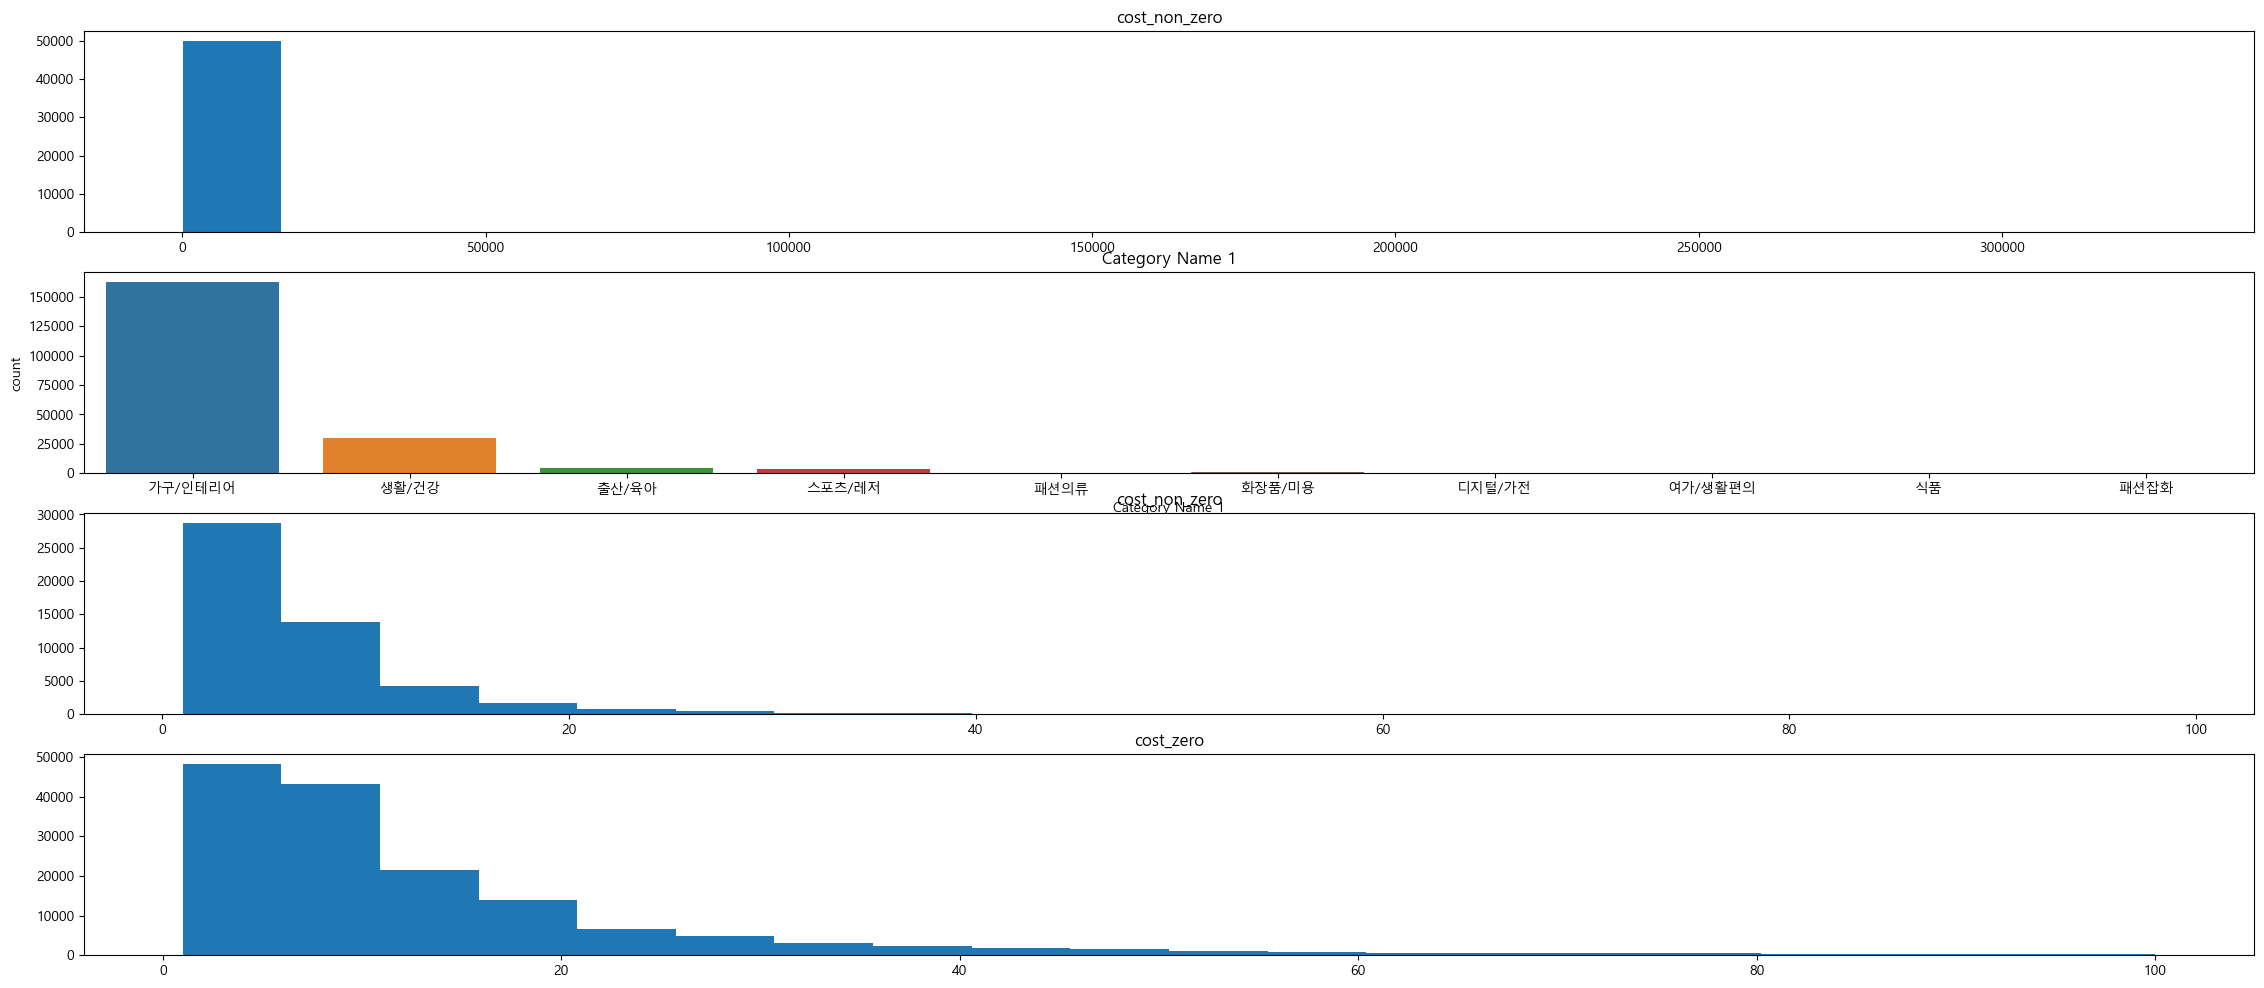

In [32]:
# 수치표현
# 그래프표현
# text = 5~10만원 상품 가격 데이터 특징
price_Analysis(price_5_10)

비용평균
176.7522275674545
--------------------------------------------------


코스트 썼을때 평균 순위 : 6.805257416335293
코스트 안 썼을때 평균 순위 : 13.58261623567634
--------------------------------------------------


광고숫자비율
3.8761765321062542
--------------------------------------------------


배달비 없음 비율
86.22798577703409


배달비 있음 비율
13.772014222965906
--------------------------------------------------


코스트비율
0.0        0.762251
50.0       0.042836
100.0      0.014097
150.0      0.007956
200.0      0.005806
             ...   
6180.0     0.000008
7770.0     0.000008
28530.0    0.000008
14250.0    0.000008
26380.0    0.000008
Name: Cost, Length: 855, dtype: float64
--------------------------------------------------


코스트


count     28417.000000
mean        743.439139
std        3118.644716
min          50.000000
25%         100.000000
50%         260.000000
75%         580.000000
max      185690.000000
Name: Cost, dtype: float64

--------------------------------------------------


카테고리1


가구/인테리어    0.886785
생활/건강      0.082041
출산/육아      0.013587
스포츠/레저     0.012039
디지털/가전     0.001824
여가/생활편의    0.001732
패션의류       0.001723
화장품/미용     0.000167
패션잡화       0.000100
Name: Category Name 1, dtype: float64

--------------------------------------------------


코스트 있음 , 순위


count    28417.000000
mean         6.805257
std          6.476787
min          1.000000
25%          3.000000
50%          5.000000
75%          8.000000
max         93.000000
Name: Sum of AD rank, dtype: float64

--------------------------------------------------


코스트 없음 , 순위


count    91108.000000
mean        13.582616
std         14.520047
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max        100.000000
Name: Sum of AD rank, dtype: float64

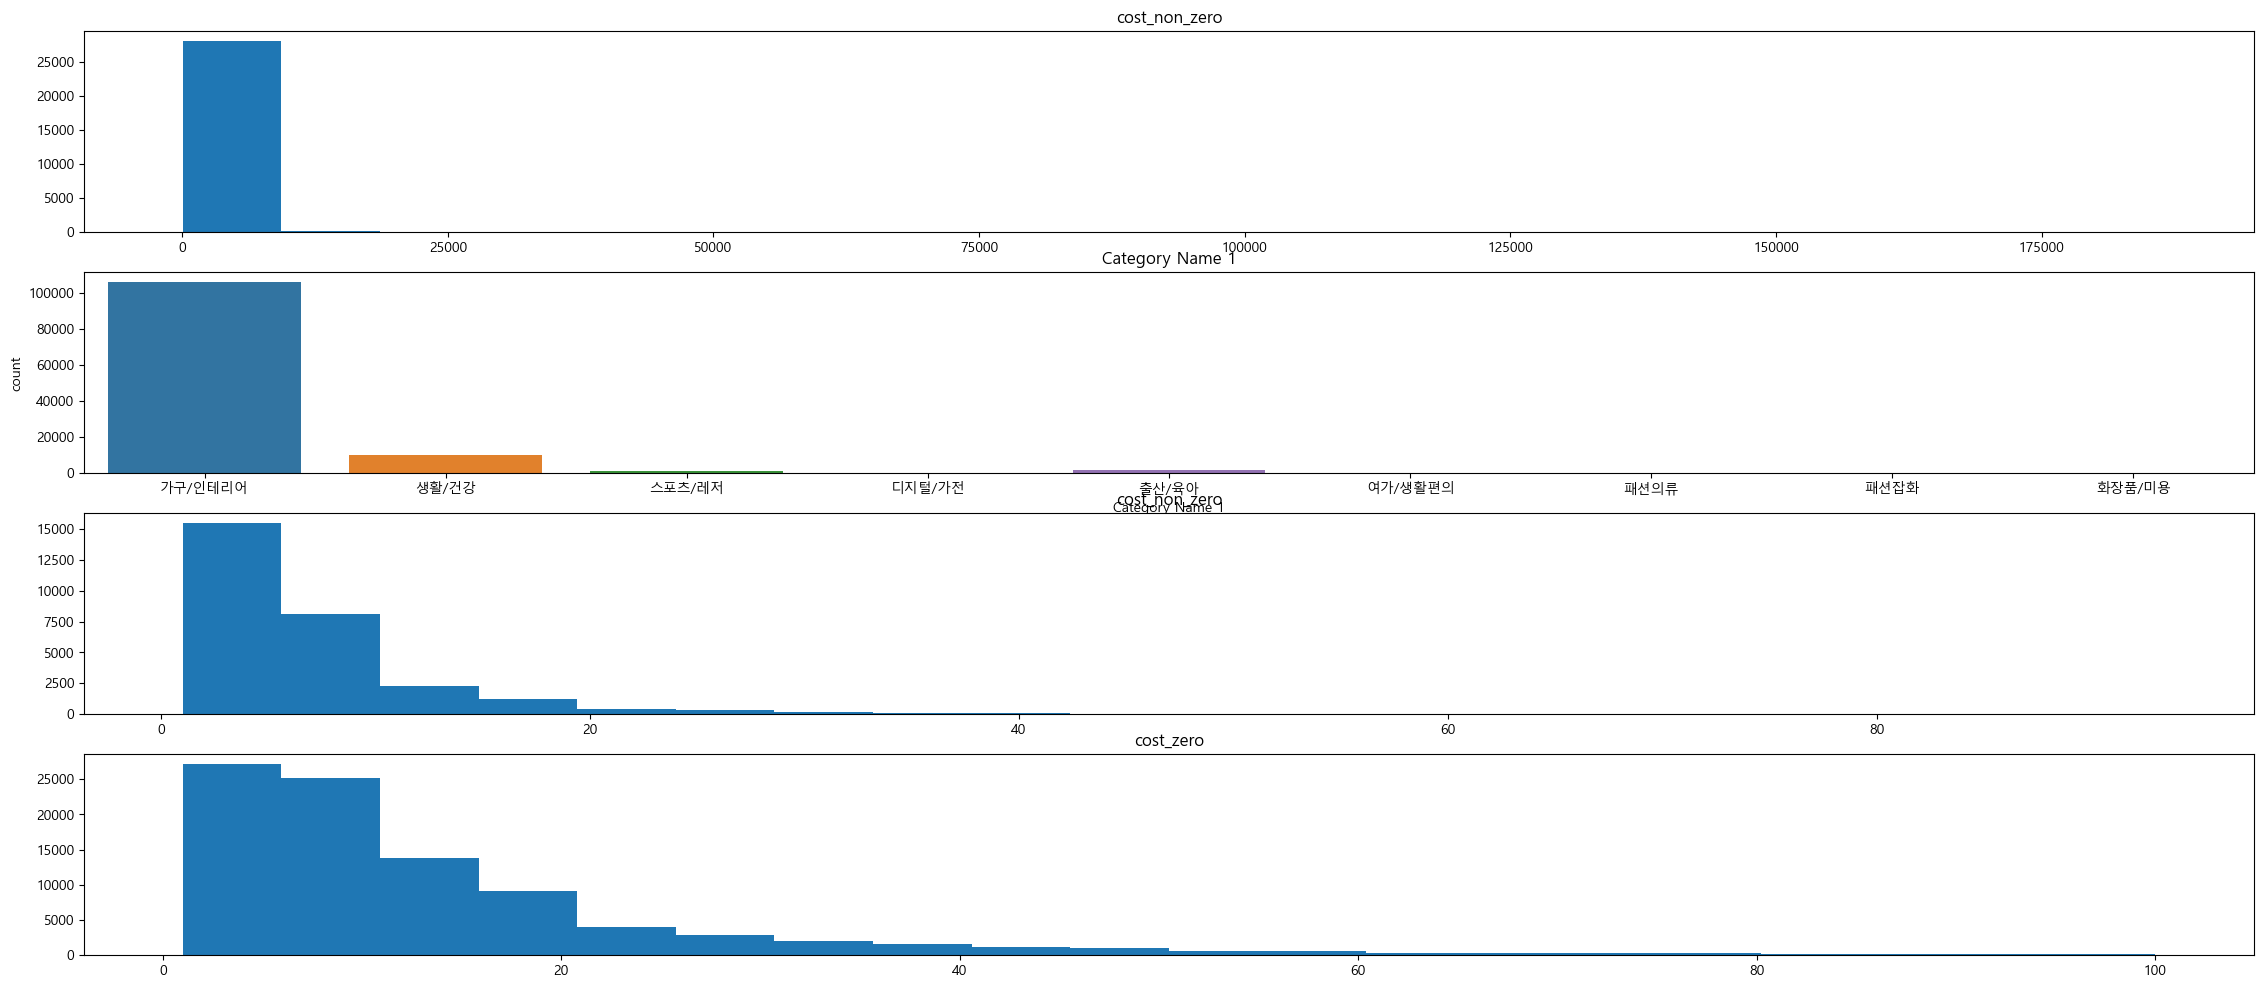

In [33]:
# 수치표현
# 그래프표현
# text = 10~15만원 상품 가격 데이터 특징
price_Analysis(price_10_15)

비용평균
203.27396972012716
--------------------------------------------------


코스트 썼을때 평균 순위 : 6.766107397808393
코스트 안 썼을때 평균 순위 : 13.122434039064101
--------------------------------------------------


광고숫자비율
3.8054734137400184
--------------------------------------------------


배달비 없음 비율
88.89368818597644


배달비 있음 비율
11.106311814023547
--------------------------------------------------


코스트비율
0.0         0.756421
50.0        0.045453
100.0       0.014210
150.0       0.007199
350.0       0.006490
              ...   
6950.0      0.000011
117480.0    0.000011
23020.0     0.000011
9760.0      0.000011
3110.0      0.000011
Name: Cost, Length: 754, dtype: float64
--------------------------------------------------


코스트


count     21993.000000
mean        834.529623
std        4027.003254
min          50.000000
25%         100.000000
50%         260.000000
75%         600.000000
max      191400.000000
Name: Cost, dtype: float64

--------------------------------------------------


카테고리1


가구/인테리어    0.931732
생활/건강      0.053505
출산/육아      0.007509
스포츠/레저     0.005117
여가/생활편의    0.000986
패션의류       0.000598
화장품/미용     0.000365
패션잡화       0.000144
디지털/가전     0.000044
Name: Category Name 1, dtype: float64

--------------------------------------------------


코스트 있음 , 순위


count    21993.000000
mean         6.766107
std          6.462560
min          1.000000
25%          3.000000
50%          5.000000
75%          8.000000
max        100.000000
Name: Sum of AD rank, dtype: float64

--------------------------------------------------


코스트 없음 , 순위


count    68298.000000
mean        13.122434
std         13.854315
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max        100.000000
Name: Sum of AD rank, dtype: float64

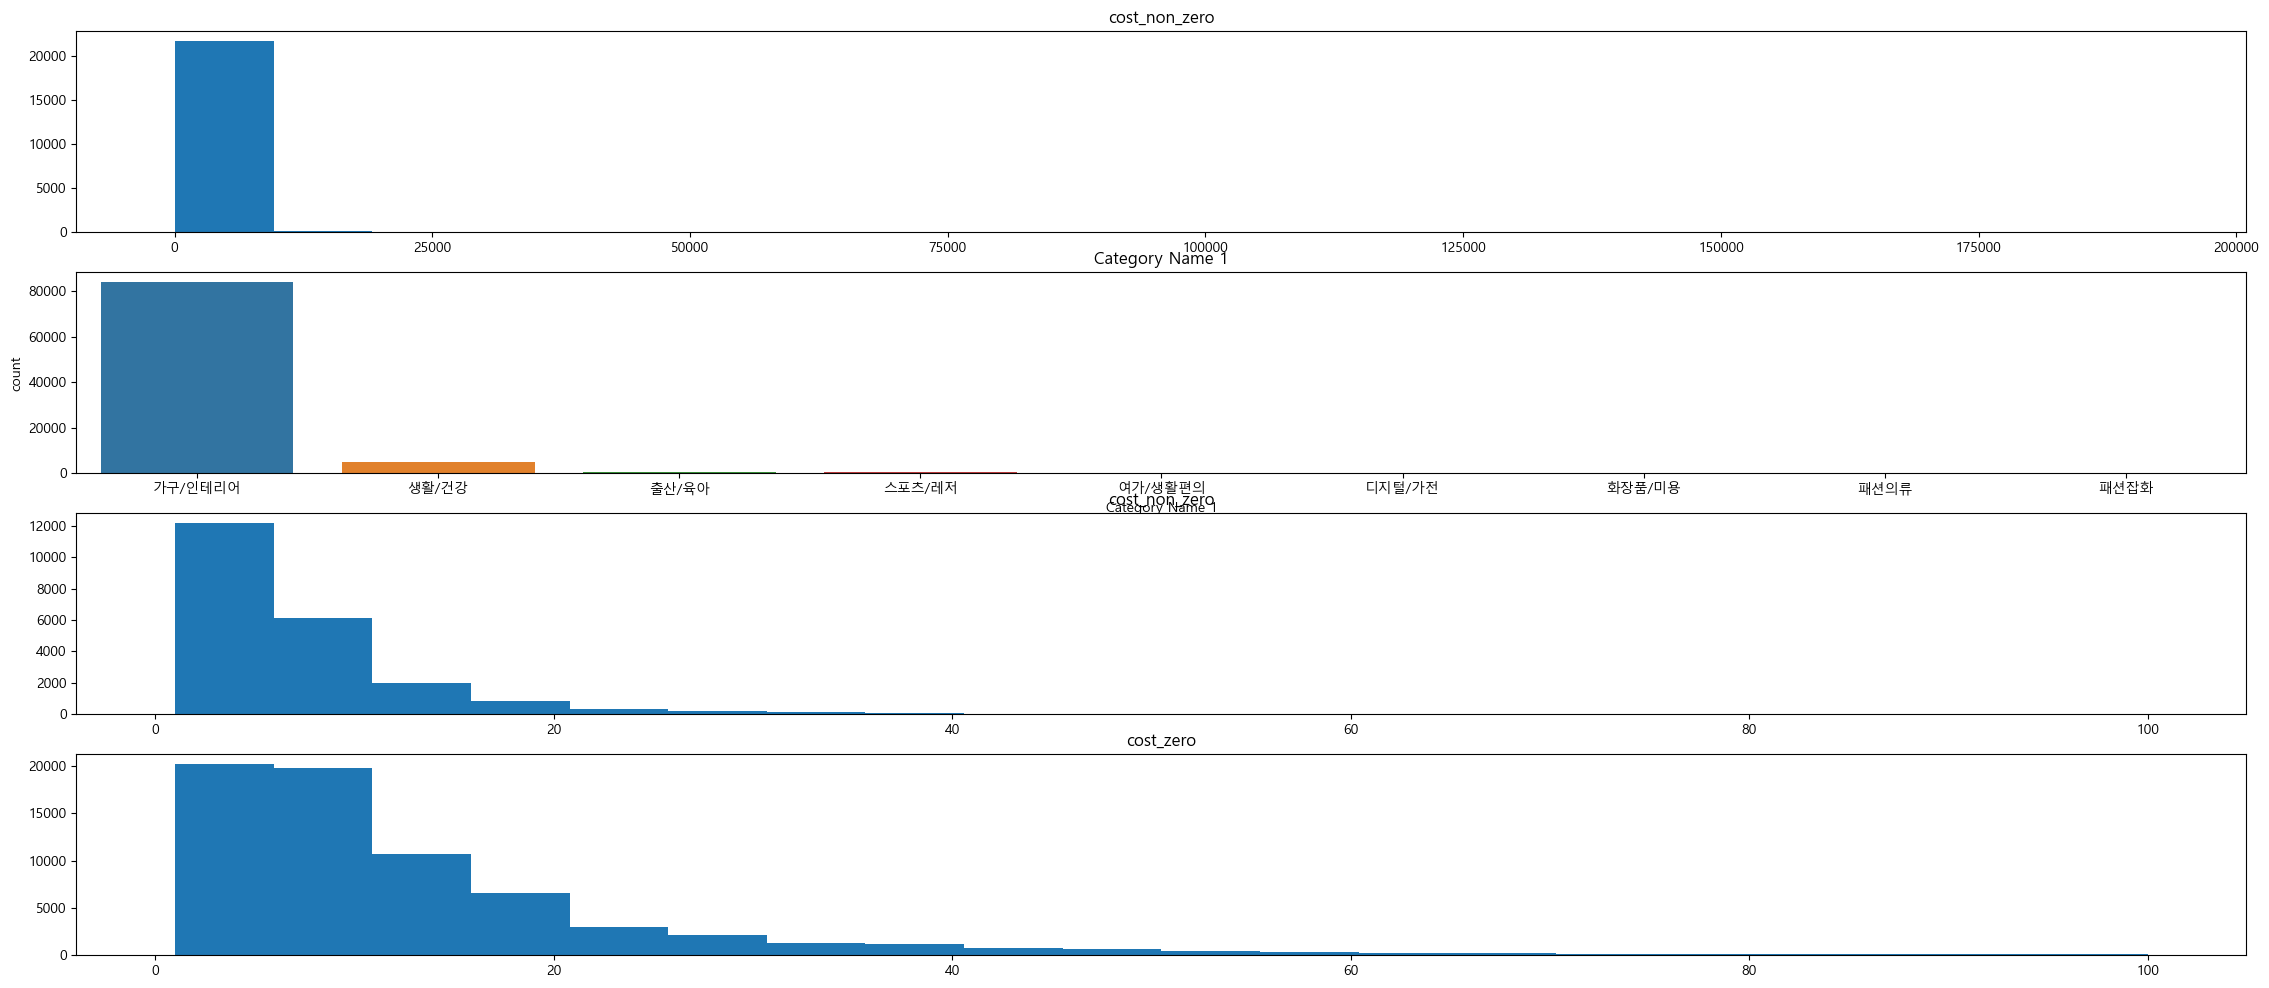

In [34]:
# 수치표현
# 그래프표현
# text = 15~20만원 상품 가격 데이터 특징
price_Analysis(price_15_20)

비용평균
210.78078991056972
--------------------------------------------------


코스트 썼을때 평균 순위 : 5.927594324616657
코스트 안 썼을때 평균 순위 : 11.778050682443254
--------------------------------------------------


광고숫자비율
3.5259716747169865
--------------------------------------------------


배달비 없음 비율
94.15526299608528


배달비 있음 비율
5.84473700391471
--------------------------------------------------


코스트비율
0.0        0.731555
50.0       0.049074
100.0      0.017521
150.0      0.009432
250.0      0.007051
             ...   
27480.0    0.000003
17020.0    0.000003
14300.0    0.000003
13070.0    0.000003
15800.0    0.000003
Name: Cost, Length: 1293, dtype: float64
--------------------------------------------------


코스트


count     78585.000000
mean        785.192976
std        3459.069587
min          50.000000
25%         100.000000
50%         260.000000
75%         600.000000
max      259530.000000
Name: Cost, dtype: float64

--------------------------------------------------


카테고리1


가구/인테리어    0.966342
생활/건강      0.022672
출산/육아      0.005869
스포츠/레저     0.004068
디지털/가전     0.000506
화장품/미용     0.000362
패션잡화       0.000157
여가/생활편의    0.000024
Name: Category Name 1, dtype: float64

--------------------------------------------------


코스트 있음 , 순위


count    78585.000000
mean         5.927594
std          5.286060
min          1.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         90.000000
Name: Sum of AD rank, dtype: float64

--------------------------------------------------


코스트 없음 , 순위


count    214157.000000
mean         11.778051
std          12.014084
min           1.000000
25%           5.000000
50%           8.000000
75%          14.000000
max         100.000000
Name: Sum of AD rank, dtype: float64

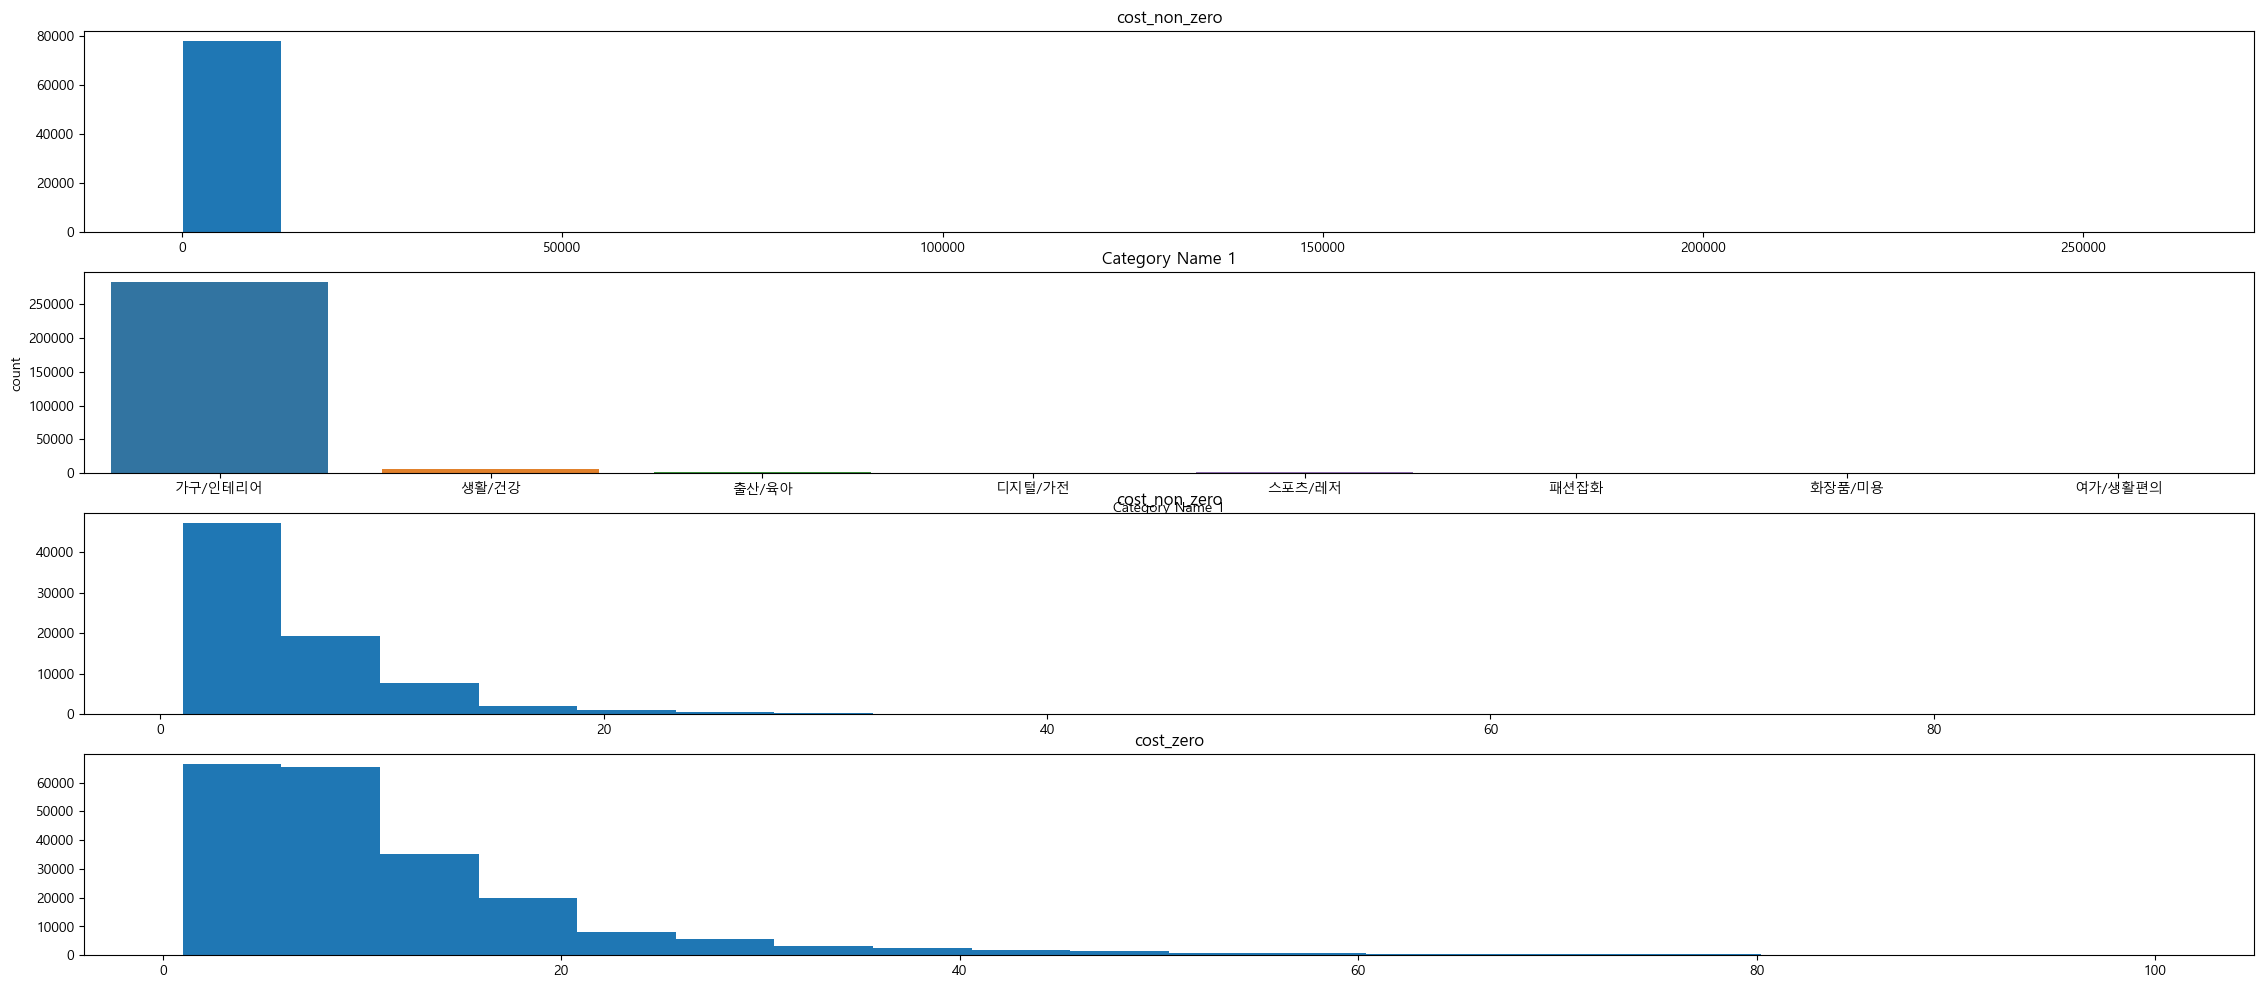

In [35]:
# 수치표현
# 그래프표현
# text = 20만원 이상 상품 가격 데이터 특징
price_Analysis(price_up_20)

In [36]:
def corr_heat(df):
    sns.set(rc = {'figure.figsize':(15,8)}, font_scale = 1)
    sns.heatmap(data = df.corr(), annot=True, linewidths=1)

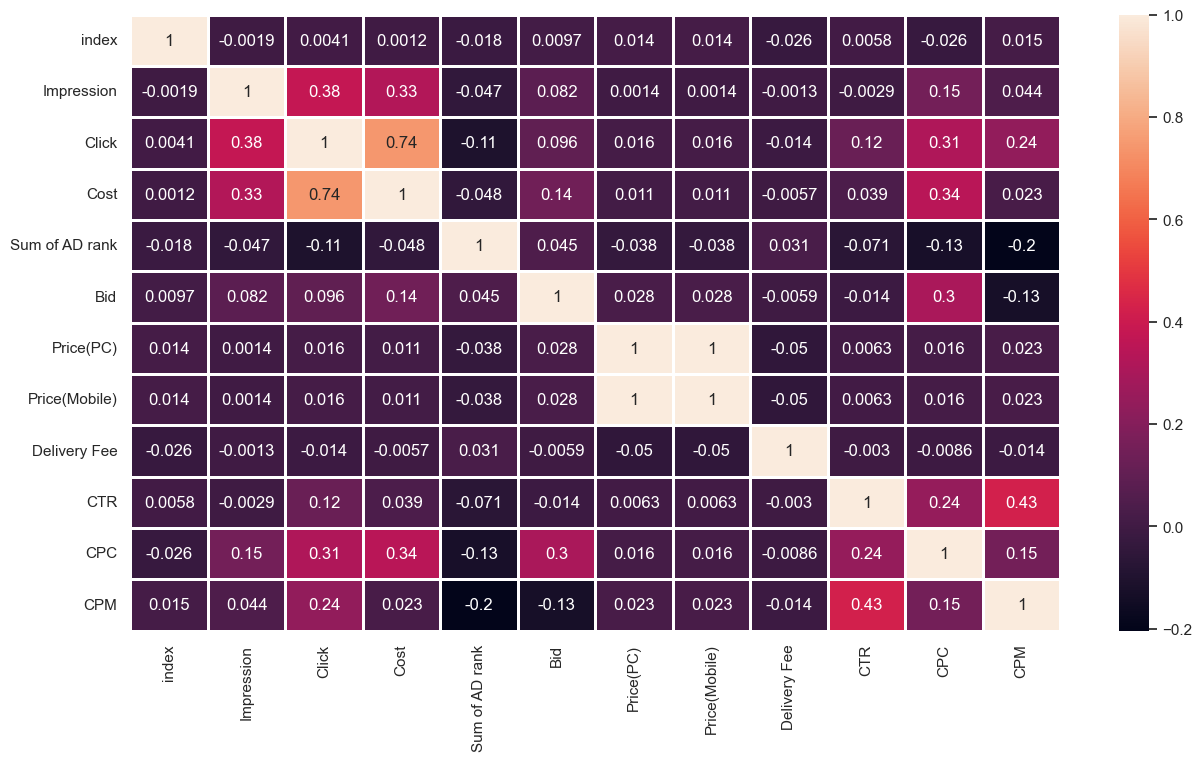

In [37]:
# 그래프 표현
# text = 5만원 이하 상품 가격 데이터 상관관계
corr_heat(price_down_5)

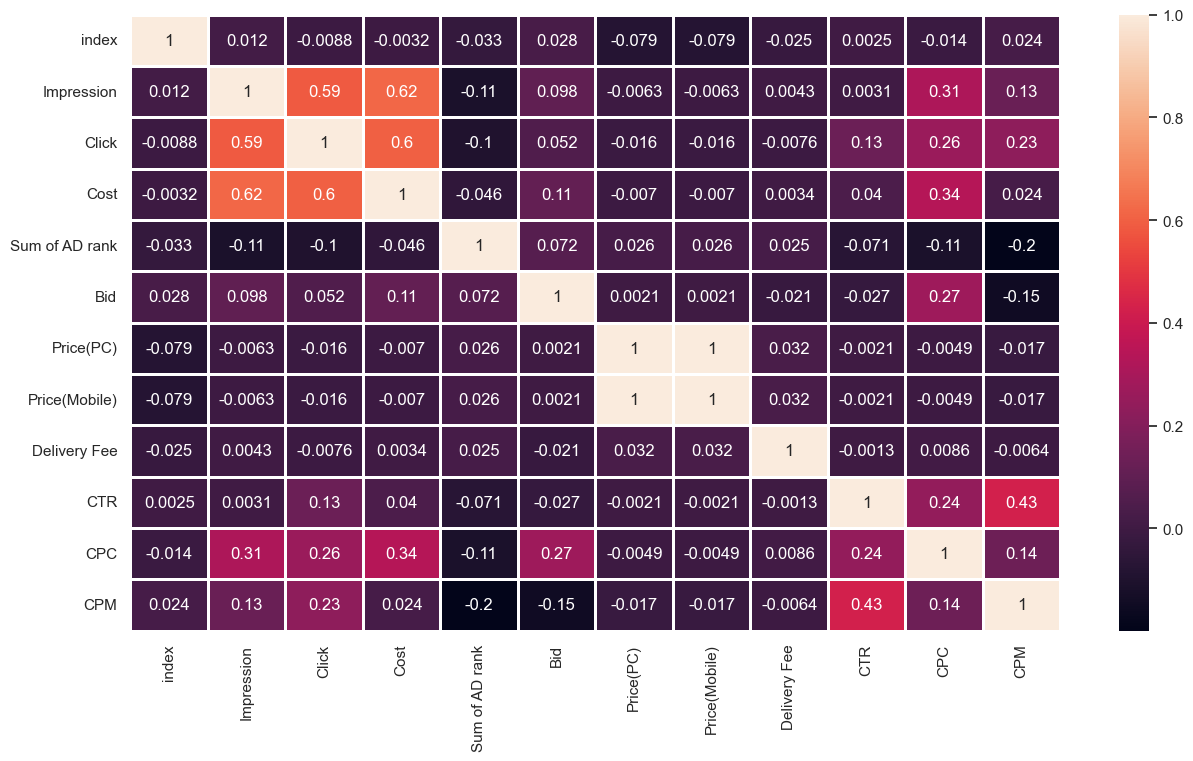

In [38]:
# 그래프 표현
# text = 5~10만원 상품 가격 데이터 상관관계
corr_heat(price_5_10)

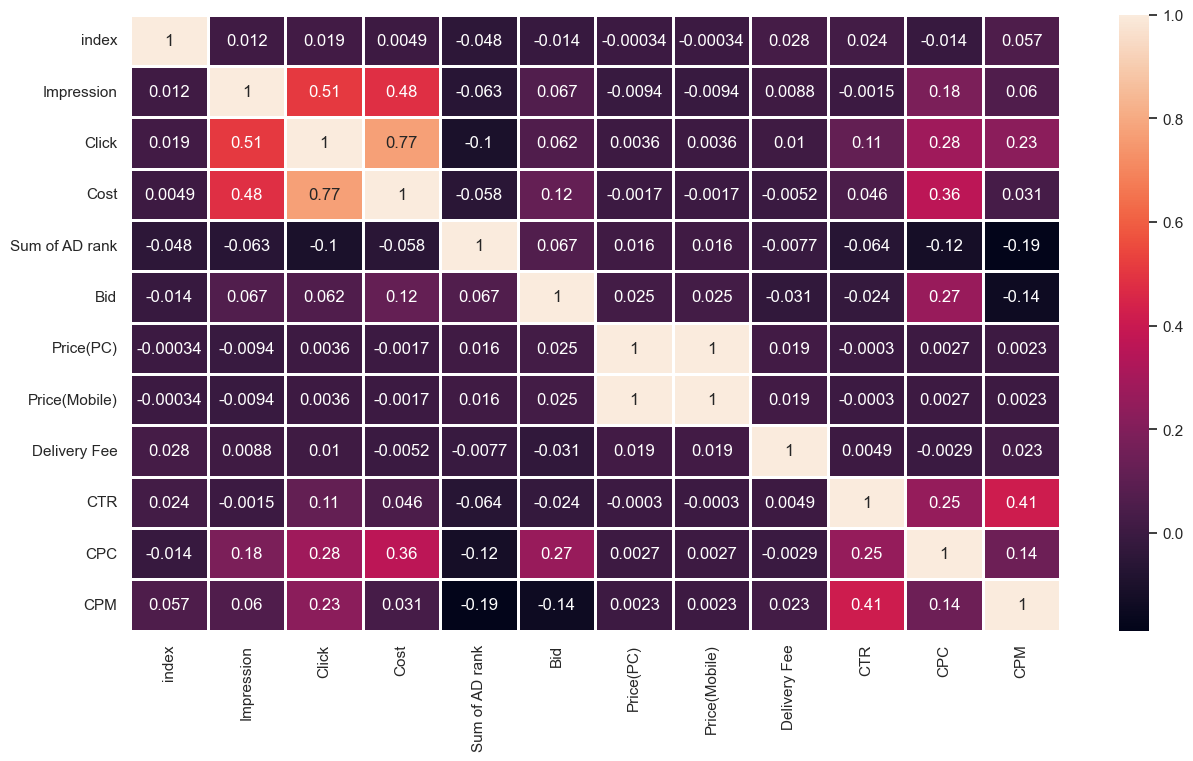

In [39]:
# 그래프 표현
# text = 10~15만원 상품 가격 데이터 상관관계
corr_heat(price_10_15)

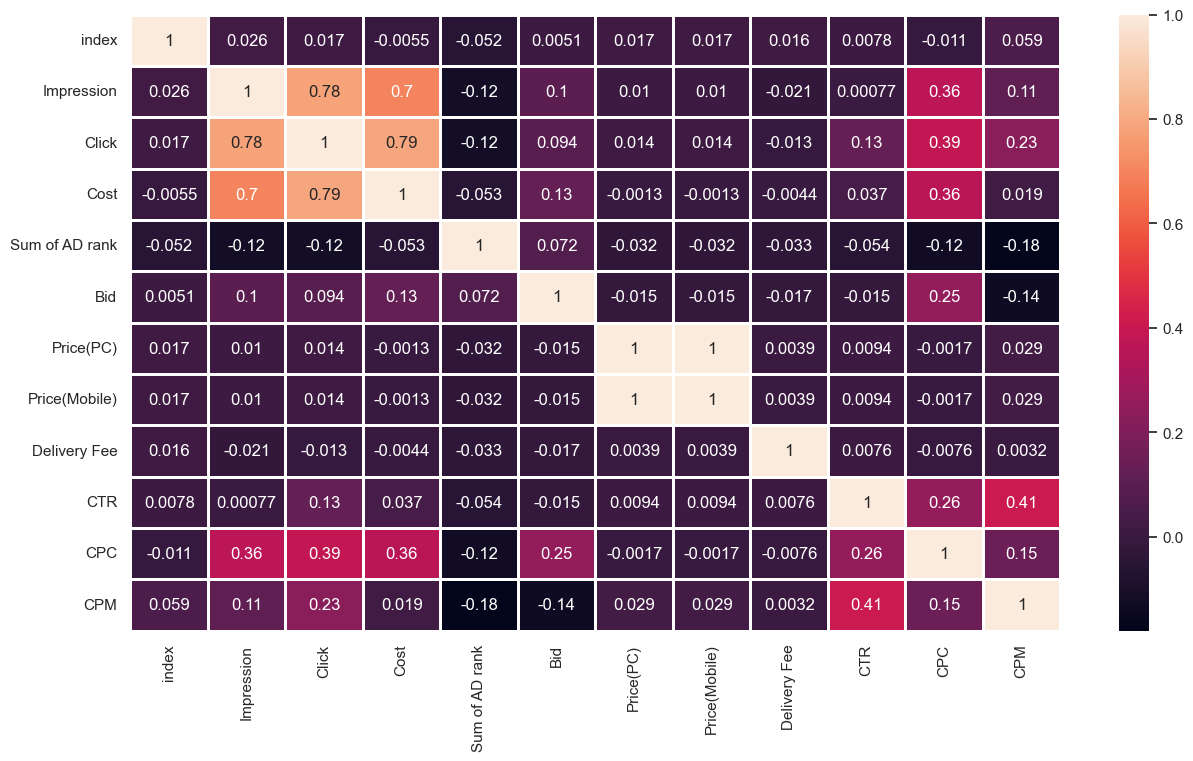

In [40]:
# 그래프 표현
# text = 15~20만원 상품 가격 데이터 상관관계
corr_heat(price_15_20)

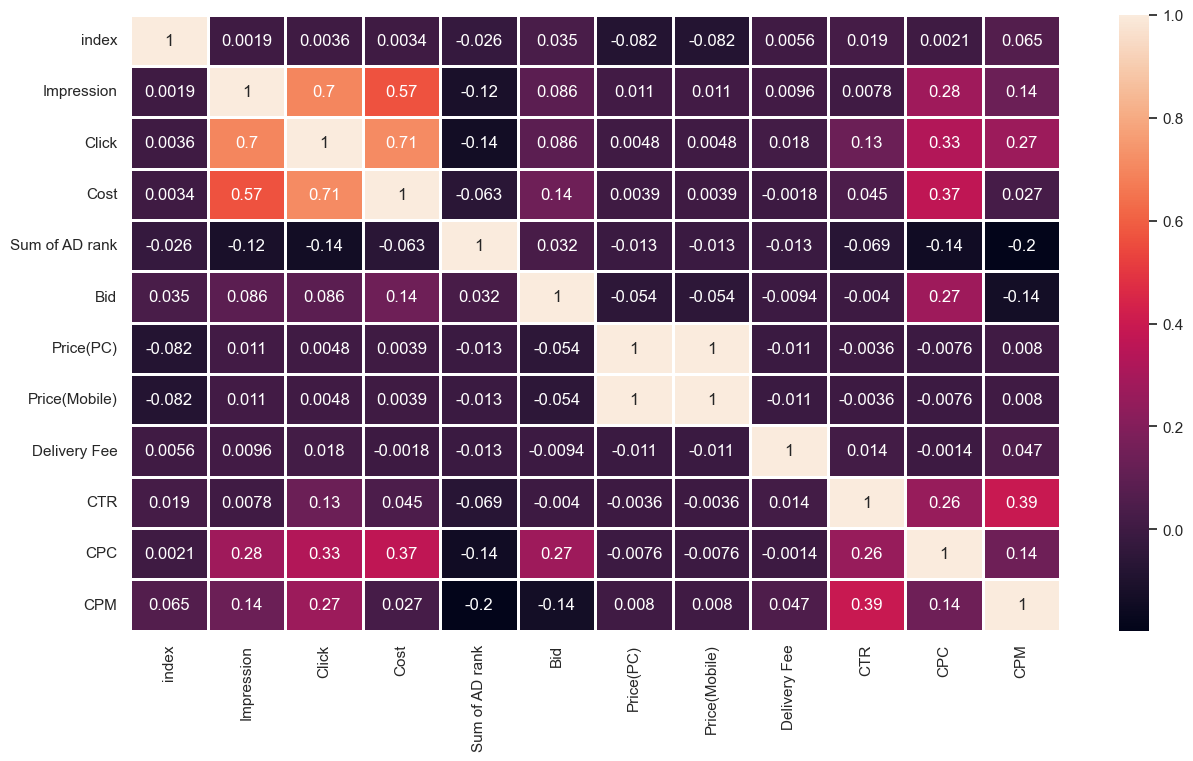

In [41]:
# 그래프 표현
# text = 20만원 이상 상품 가격 데이터 상관관계
corr_heat(price_up_20)

# Rank 구간별

In [42]:
# 네이버 페이지 기본 default 40, 한페이지에 광고가 6개 상위3개 중간에3개(20개보기, 40개보기, 60개보기, 80개보기)
# log에서 얻은 인사이트로 윈도우가 압도적으로 많으니 윈도우 기준

In [43]:
rank_down_26 = bidding_drop_null[bidding_drop_null['Sum of AD rank'] <= 26]

rank_26_46 = bidding_drop_null[(bidding_drop_null['Sum of AD rank'] > 26) & (bidding_drop_null['Sum of AD rank'] < 46)]

rank_46_66 = bidding_drop_null[(bidding_drop_null['Sum of AD rank'] > 46) & (bidding_drop_null['Sum of AD rank'] < 66)]

rank_66_86 = bidding_drop_null[(bidding_drop_null['Sum of AD rank'] > 66) & (bidding_drop_null['Sum of AD rank'] < 86)]

rank_up_86 = bidding_drop_null[bidding_drop_null['Sum of AD rank'] >= 86]

In [44]:
def rank_col(df):
    print("광고숫자비율")
    print((len(list(set(df['index'].values))) / len(df))*100)
    print('-' * 50)
    
    columns = ['Click', 'Cost', 'Impression', 'Price(PC)']
    
    for col in columns:
        print('\n')
        print(col)
        print(df[col].mean())
        print('-' * 50)
        print(df[col].value_counts(normalize=True))

In [45]:
#수치표현
# text = Rank 구간별 광고 비율
print("rank_down_26 광고숫자비율")
print((len(list(set(rank_down_26['index'].values))) / len(rank_down_26))*100)
print('-' * 50)
print("rank_26_46 광고숫자비율")
print((len(list(set(rank_26_46['index'].values))) / len(rank_26_46))*100)
print('-' * 50)
print("rank_46_66 광고숫자비율")
print((len(list(set(rank_46_66['index'].values))) / len(rank_46_66))*100)
print('-' * 50)
print("rank_66_86 광고숫자비율")
print((len(list(set(rank_66_86['index'].values))) / len(rank_66_86))*100)
print('-' * 50)
print("rank_up_86 광고숫자비율")
print((len(list(set(rank_up_86['index'].values))) / len(rank_up_86))*100)
print('-' * 50)

rank_down_26 광고숫자비율
3.965566909266703
--------------------------------------------------
rank_26_46 광고숫자비율
25.564515081869292
--------------------------------------------------
rank_46_66 광고숫자비율
39.259515305142685
--------------------------------------------------
rank_66_86 광고숫자비율
49.78980076768415
--------------------------------------------------
rank_up_86 광고숫자비율
56.46306818181818
--------------------------------------------------


In [46]:
#수치표현
# text = Rank 구간별 광고 비율
print("rank_down_26 광고숫자비율")
print((len(list(set(rank_down_26['index'].values)))))
print('-' * 50)
print("rank_26_46 광고숫자비율")
print((len(list(set(rank_26_46['index'].values)))))
print('-' * 50)
print("rank_46_66 광고숫자비율")
print((len(list(set(rank_46_66['index'].values)))))
print('-' * 50)
print("rank_66_86 광고숫자비율")
print((len(list(set(rank_66_86['index'].values)))))
print('-' * 50)
print("rank_up_86 광고숫자비율")
print((len(list(set(rank_up_86['index'].values)))))
print('-' * 50)

rank_down_26 광고숫자비율
47905
--------------------------------------------------
rank_26_46 광고숫자비율
19688
--------------------------------------------------
rank_46_66 광고숫자비율
10222
--------------------------------------------------
rank_66_86 광고숫자비율
5448
--------------------------------------------------
rank_up_86 광고숫자비율
3180
--------------------------------------------------


In [47]:
#수치표현
# text = Rank 구간별 Click 평균
print('rank_down_26')
print(rank_down_26['Click'].mean())
print('-' * 50)
print(rank_down_26['Click'].value_counts(normalize=True))
print('-' * 50)
print('rank_26_46')
print(rank_26_46['Click'].mean())
print('-' * 50)
print(rank_26_46['Click'].value_counts(normalize=True))
print('-' * 50)
print('rank_46_66')
print(rank_46_66['Click'].mean())
print('-' * 50)
print(rank_46_66['Click'].value_counts(normalize=True))
print('-' * 50)
print('rank_66_86')
print(rank_66_86['Click'].mean())
print('-' * 50)
print(rank_66_86['Click'].value_counts(normalize=True))
print('-' * 50)
print('rank_up_86')
print(rank_up_86['Click'].mean())
print('-' * 50)
print(rank_up_86['Click'].value_counts(normalize=True))
print('-' * 50)

rank_down_26
0.790540585286385
--------------------------------------------------
0      7.315716e-01
1      1.452935e-01
2      5.034917e-02
3      2.366592e-02
4      1.332921e-02
           ...     
195    8.277981e-07
240    8.277981e-07
257    8.277981e-07
177    8.277981e-07
455    8.277981e-07
Name: Click, Length: 189, dtype: float64
--------------------------------------------------
rank_26_46
0.06485917961902536
--------------------------------------------------
0    0.943139
1    0.050888
2    0.004532
3    0.001039
4    0.000247
5    0.000130
6    0.000026
Name: Click, dtype: float64
--------------------------------------------------
rank_46_66
0.02757614164458271
--------------------------------------------------
0    0.973653
1    0.025195
2    0.001075
3    0.000077
Name: Click, dtype: float64
--------------------------------------------------
rank_66_86
0.009230488027782854
--------------------------------------------------
0    0.99077
1    0.00923
Name: Click, dtype: f

In [48]:
#수치표현
# text = Rank 구간별 Cost 평균
print('rank_down_26')
print(rank_down_26['Cost'].mean())
print('-' * 50)
print(rank_down_26['Cost'].value_counts(normalize=True))
print('-' * 50)
print('rank_26_46')
print(rank_26_46['Cost'].mean())
print('-' * 50)
print(rank_26_46['Cost'].value_counts(normalize=True))
print('-' * 50)
print('rank_46_66')
print(rank_46_66['Cost'].mean())
print('-' * 50)
print(rank_46_66['Cost'].value_counts(normalize=True))
print('-' * 50)
print('rank_66_86')
print(rank_66_86['Cost'].mean())
print('-' * 50)
print(rank_66_86['Cost'].value_counts(normalize=True))
print('-' * 50)
print('rank_up_86')
print(rank_up_86['Cost'].mean())
print('-' * 50)
print(rank_up_86['Cost'].value_counts(normalize=True))
print('-' * 50)

rank_down_26
197.78499433786084
--------------------------------------------------
0.0        7.315716e-01
50.0       5.392856e-02
100.0      1.859731e-02
150.0      9.850798e-03
200.0      7.199360e-03
               ...     
26190.0    8.277981e-07
42270.0    8.277981e-07
10720.0    8.277981e-07
46930.0    8.277981e-07
10160.0    8.277981e-07
Name: Cost, Length: 2406, dtype: float64
--------------------------------------------------
rank_26_46
18.740212691363794
--------------------------------------------------
0.0       0.943139
50.0      0.008414
350.0     0.002987
250.0     0.001883
180.0     0.001766
            ...   
3040.0    0.000013
1470.0    0.000013
2280.0    0.000013
2030.0    0.000013
1890.0    0.000013
Name: Cost, Length: 163, dtype: float64
--------------------------------------------------
rank_46_66
7.31459077466682
--------------------------------------------------
0.0      0.973653
50.0     0.004033
350.0    0.001805
250.0    0.001421
210.0    0.001229
           

In [49]:
#수치표현
# text = Rank 구간별 Impression 평균
print('rank_down_26')
print(rank_down_26['Impression'].mean())
print('-' * 50)
print(rank_down_26['Impression'].value_counts(normalize=True))
print('-' * 50)
print('rank_26_46')
print(rank_26_46['Impression'].mean())
print('-' * 50)
print(rank_26_46['Impression'].value_counts(normalize=True))
print('-' * 50)
print('rank_46_66')
print(rank_46_66['Impression'].mean())
print('-' * 50)
print(rank_46_66['Impression'].value_counts(normalize=True))
print('-' * 50)
print('rank_66_86')
print(rank_66_86['Impression'].mean())
print('-' * 50)
print(rank_66_86['Impression'].value_counts(normalize=True))
print('-' * 50)
print('rank_up_86')
print(rank_up_86['Impression'].mean())
print('-' * 50)
print(rank_up_86['Impression'].value_counts(normalize=True))
print('-' * 50)

rank_down_26
48.3159283259273
--------------------------------------------------
1       9.384416e-02
2       7.156646e-02
3       5.861639e-02
4       4.985414e-02
5       4.313490e-02
            ...     
2211    8.277981e-07
3981    8.277981e-07
2767    8.277981e-07
1163    8.277981e-07
1590    8.277981e-07
Name: Impression, Length: 2732, dtype: float64
--------------------------------------------------
rank_26_46
5.943671847610144
--------------------------------------------------
1      0.214198
2      0.188682
3      0.145261
4      0.095815
5      0.072910
         ...   
120    0.000013
172    0.000013
187    0.000013
236    0.000013
162    0.000013
Name: Impression, Length: 204, dtype: float64
--------------------------------------------------
rank_46_66
3.1726005300149787
--------------------------------------------------
1      0.405615
2      0.245996
3      0.125975
4      0.074778
5      0.044206
         ...   
131    0.000038
98     0.000038
107    0.000038
85     0.000

In [50]:
#수치표현
#mean으로 할지 median으로 할지는 멘토링후 결정
# text = Rank 구간별 Price(PC) 평균
print('rank_down_26')
print(rank_down_26['Price(PC)'].mean())
print('-' * 50)
print(rank_down_26['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('rank_26_46')
print(rank_26_46['Price(PC)'].mean())
print('-' * 50)
print(rank_26_46['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('rank_46_66')
print(rank_46_66['Price(PC)'].mean())
print('-' * 50)
print(rank_46_66['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('rank_66_86')
print(rank_66_86['Price(PC)'].mean())
print('-' * 50)
print(rank_66_86['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('rank_up_86')
print(rank_up_86['Price(PC)'].mean())
print('-' * 50)
print(rank_up_86['Price(PC)'].value_counts(normalize=True))
print('-' * 50)

rank_down_26
187572.42825059767
--------------------------------------------------
9900       1.186069e-02
19900      1.045757e-02
29900      8.902969e-03
12900      8.641385e-03
14900      8.610756e-03
               ...     
1156200    8.277981e-07
1330040    8.277981e-07
1548980    8.277981e-07
1578500    8.277981e-07
2550       8.277981e-07
Name: Price(PC), Length: 7447, dtype: float64
--------------------------------------------------
rank_26_46
143206.4081259008
--------------------------------------------------
9900       0.012037
19900      0.010232
8900       0.009855
7900       0.009037
29900      0.008973
             ...   
1107000    0.000013
3076000    0.000013
47560      0.000013
1376000    0.000013
9000000    0.000013
Name: Price(PC), Length: 3019, dtype: float64
--------------------------------------------------
rank_46_66
136608.30053385565
--------------------------------------------------
19900      0.011599
7900       0.010946
9900       0.010946
4900       0.01063

(array([1]), [Text(0, 0, '')])

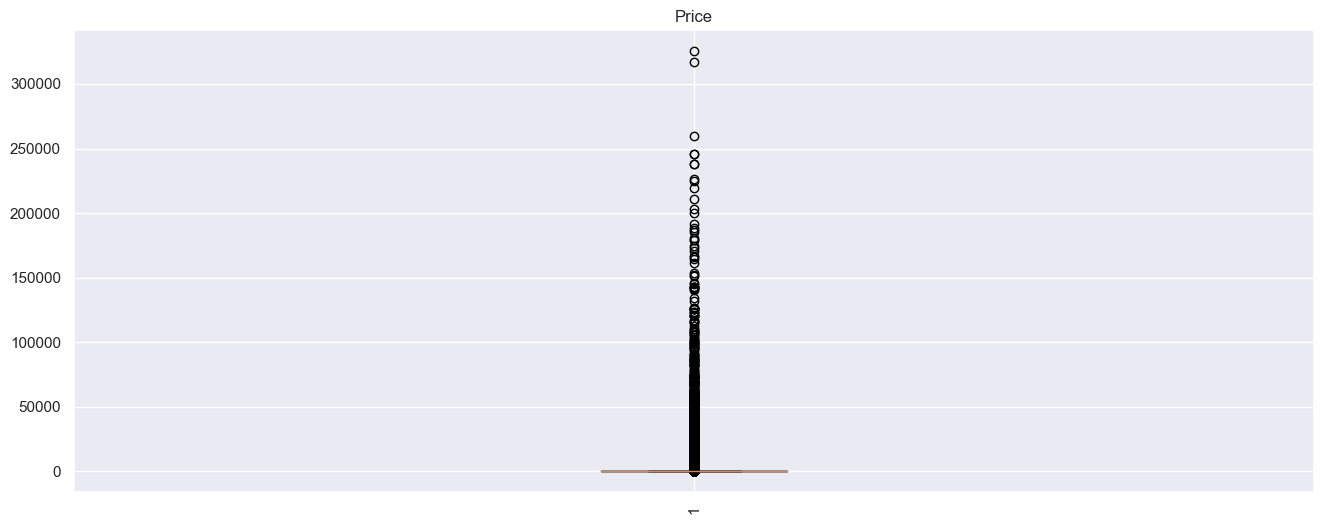

In [51]:
# median으로 한다면 그래프표현
# text = 상품가격 Boxplot
plt.figure(figsize=(16, 6))
plt.boxplot(bidding_drop_null['Cost'])
plt.title('Price')
plt.xticks(rotation=90)

In [52]:
# 수치표현
# text = Rank 구간별 Price(PC) 중간값
print('rank_down_26')
print(rank_down_26['Price(PC)'].median())
print('-' * 50)
print(rank_down_26['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('rank_26_46')
print(rank_26_46['Price(PC)'].median())
print('-' * 50)
print(rank_26_46['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('rank_46_66')
print(rank_46_66['Price(PC)'].median())
print('-' * 50)
print(rank_46_66['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('rank_66_86')
print(rank_66_86['Price(PC)'].median())
print('-' * 50)
print(rank_66_86['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('rank_up_86')
print(rank_up_86['Price(PC)'].median())
print('-' * 50)
print(rank_up_86['Price(PC)'].value_counts(normalize=True))
print('-' * 50)

rank_down_26
59900.0
--------------------------------------------------
9900       1.186069e-02
19900      1.045757e-02
29900      8.902969e-03
12900      8.641385e-03
14900      8.610756e-03
               ...     
1156200    8.277981e-07
1330040    8.277981e-07
1548980    8.277981e-07
1578500    8.277981e-07
2550       8.277981e-07
Name: Price(PC), Length: 7447, dtype: float64
--------------------------------------------------
rank_26_46
45890.0
--------------------------------------------------
9900       0.012037
19900      0.010232
8900       0.009855
7900       0.009037
29900      0.008973
             ...   
1107000    0.000013
3076000    0.000013
47560      0.000013
1376000    0.000013
9000000    0.000013
Name: Price(PC), Length: 3019, dtype: float64
--------------------------------------------------
rank_46_66
39500.0
--------------------------------------------------
19900      0.011599
7900       0.010946
9900       0.010946
4900       0.010639
8900       0.010331
          

## Rank 26이하와 26초과로 분석

In [53]:
rank_down_26 = bidding_drop_null[bidding_drop_null['Sum of AD rank'] <= 26]
rank_up_26 = bidding_drop_null[bidding_drop_null['Sum of AD rank'] > 26]

In [54]:
def rank_Analysis(df):
        
    print('비용평균')
    print(df['Cost'].mean())
    print('-' * 50)
    print('\n')
    
    cost_non_zero = df[df['Cost'] != 0]
    
    
    print(f'코스트 썼을때 평균 순위 : {cost_non_zero["Sum of AD rank"].mean()}')

    cost_zero = df[df['Cost'] == 0]

    print(f'코스트 안 썼을때 평균 순위 : {cost_zero["Sum of AD rank"].mean()}')
    print('-' * 50)
    print('\n')
  

    print("광고숫자비율")
    print((len(list(set(df['index'].values))) / len(df))*100)
    print('-' * 50)
    print('\n')
    
    
    rank_del_zero = df[df['Delivery Fee'] <= 0]
    rank_del_non_zero = df[df['Delivery Fee'] > 0]
    print('배달비 없음 비율')
    print((rank_del_zero.shape[0] / df['Delivery Fee'].shape[0]*100))
    print('\n')
    print('배달비 있음 비율')
    print((rank_del_non_zero.shape[0] / df['Delivery Fee'].shape[0]*100))  
    print('-' * 50)
    print('\n')
    
    print('상품가격 중간값')
    print(f'{df["Price(PC)"].median()} 원')
    print('-' * 50)
    print('\n')
    
    plt.figure(figsize=(28, 12))
    print('카테고리1')
    display(df['Category Name 1'].value_counts(normalize=True))
    sns.countplot(x=df['Category Name 1'], data=df)
    plt.title('Category Name 1')
    plt.xticks(rotation=90)
    

비용평균
197.78499433786084
--------------------------------------------------


코스트 썼을때 평균 순위 : 5.679798808393057
코스트 안 썼을때 평균 순위 : 8.780434871163534
--------------------------------------------------


광고숫자비율
3.965566909266703
--------------------------------------------------


배달비 없음 비율
65.05789620073773


배달비 있음 비율
34.94210379926226
--------------------------------------------------


상품가격 중간값
59900.0 원
--------------------------------------------------


카테고리1


가구/인테리어    0.715840
생활/건강      0.233250
출산/육아      0.020022
스포츠/레저     0.011914
화장품/미용     0.006022
패션잡화       0.005748
디지털/가전     0.004581
패션의류       0.001797
여가/생활편의    0.000659
식품         0.000166
Name: Category Name 1, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: 

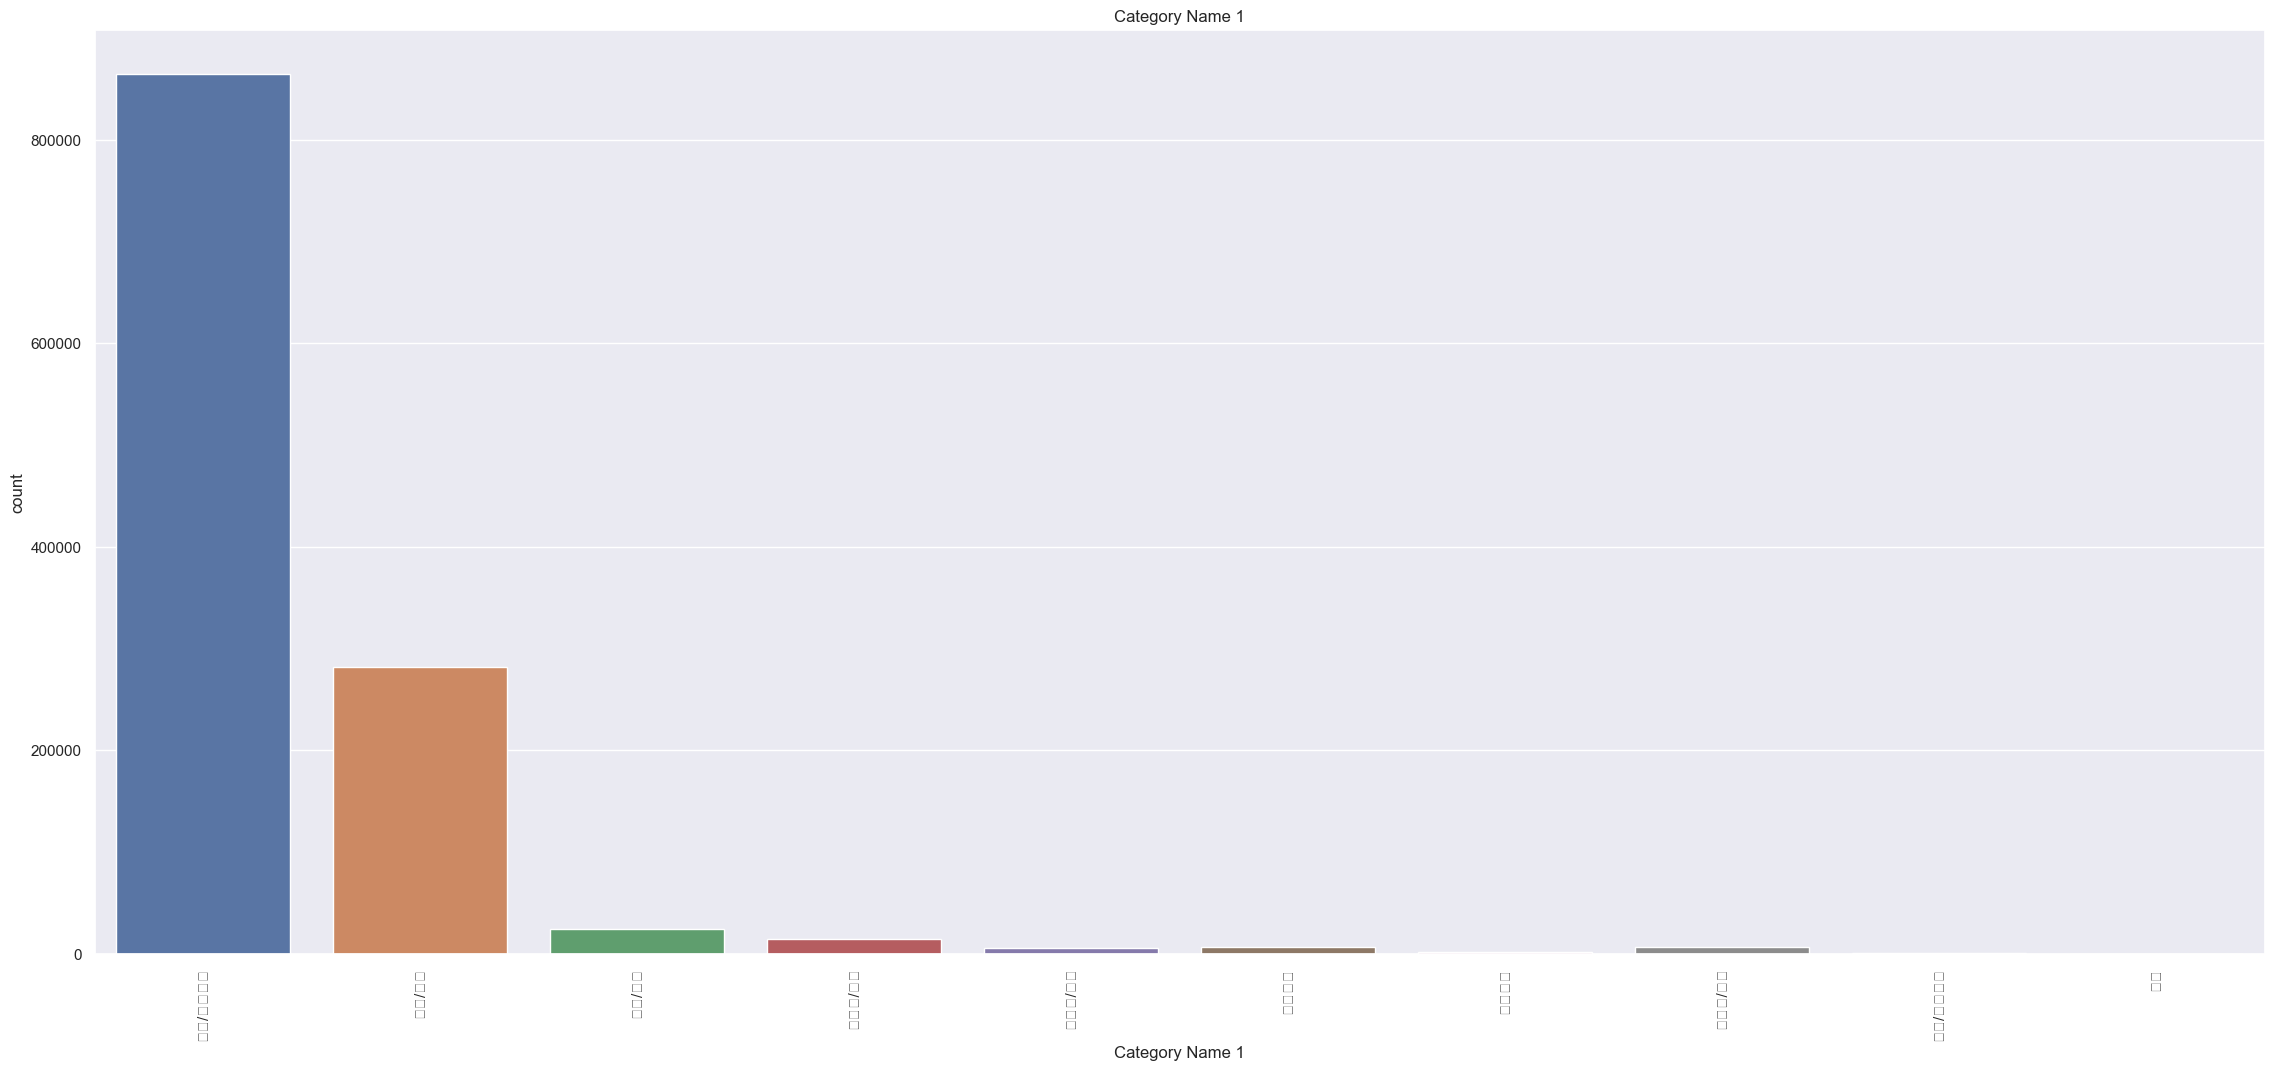

In [55]:
#수치표현
#그래프표현
# text = Rank 26 이하 특징
rank_Analysis(rank_down_26)

비용평균
13.74812277269517
--------------------------------------------------


코스트 썼을때 평균 순위 : 36.91611687087653
코스트 안 썼을때 평균 순위 : 45.574235252201355
--------------------------------------------------


광고숫자비율
18.159383701202238
--------------------------------------------------


배달비 없음 비율
58.151428316299615


배달비 있음 비율
41.84857168370039
--------------------------------------------------


상품가격 중간값
42800.0 원
--------------------------------------------------


카테고리1


가구/인테리어    0.723656
생활/건강      0.245456
스포츠/레저     0.012850
패션잡화       0.006851
출산/육아      0.006251
디지털/가전     0.001624
화장품/미용     0.001591
패션의류       0.001299
여가/생활편의    0.000341
식품         0.000081
Name: Category Name 1, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: 

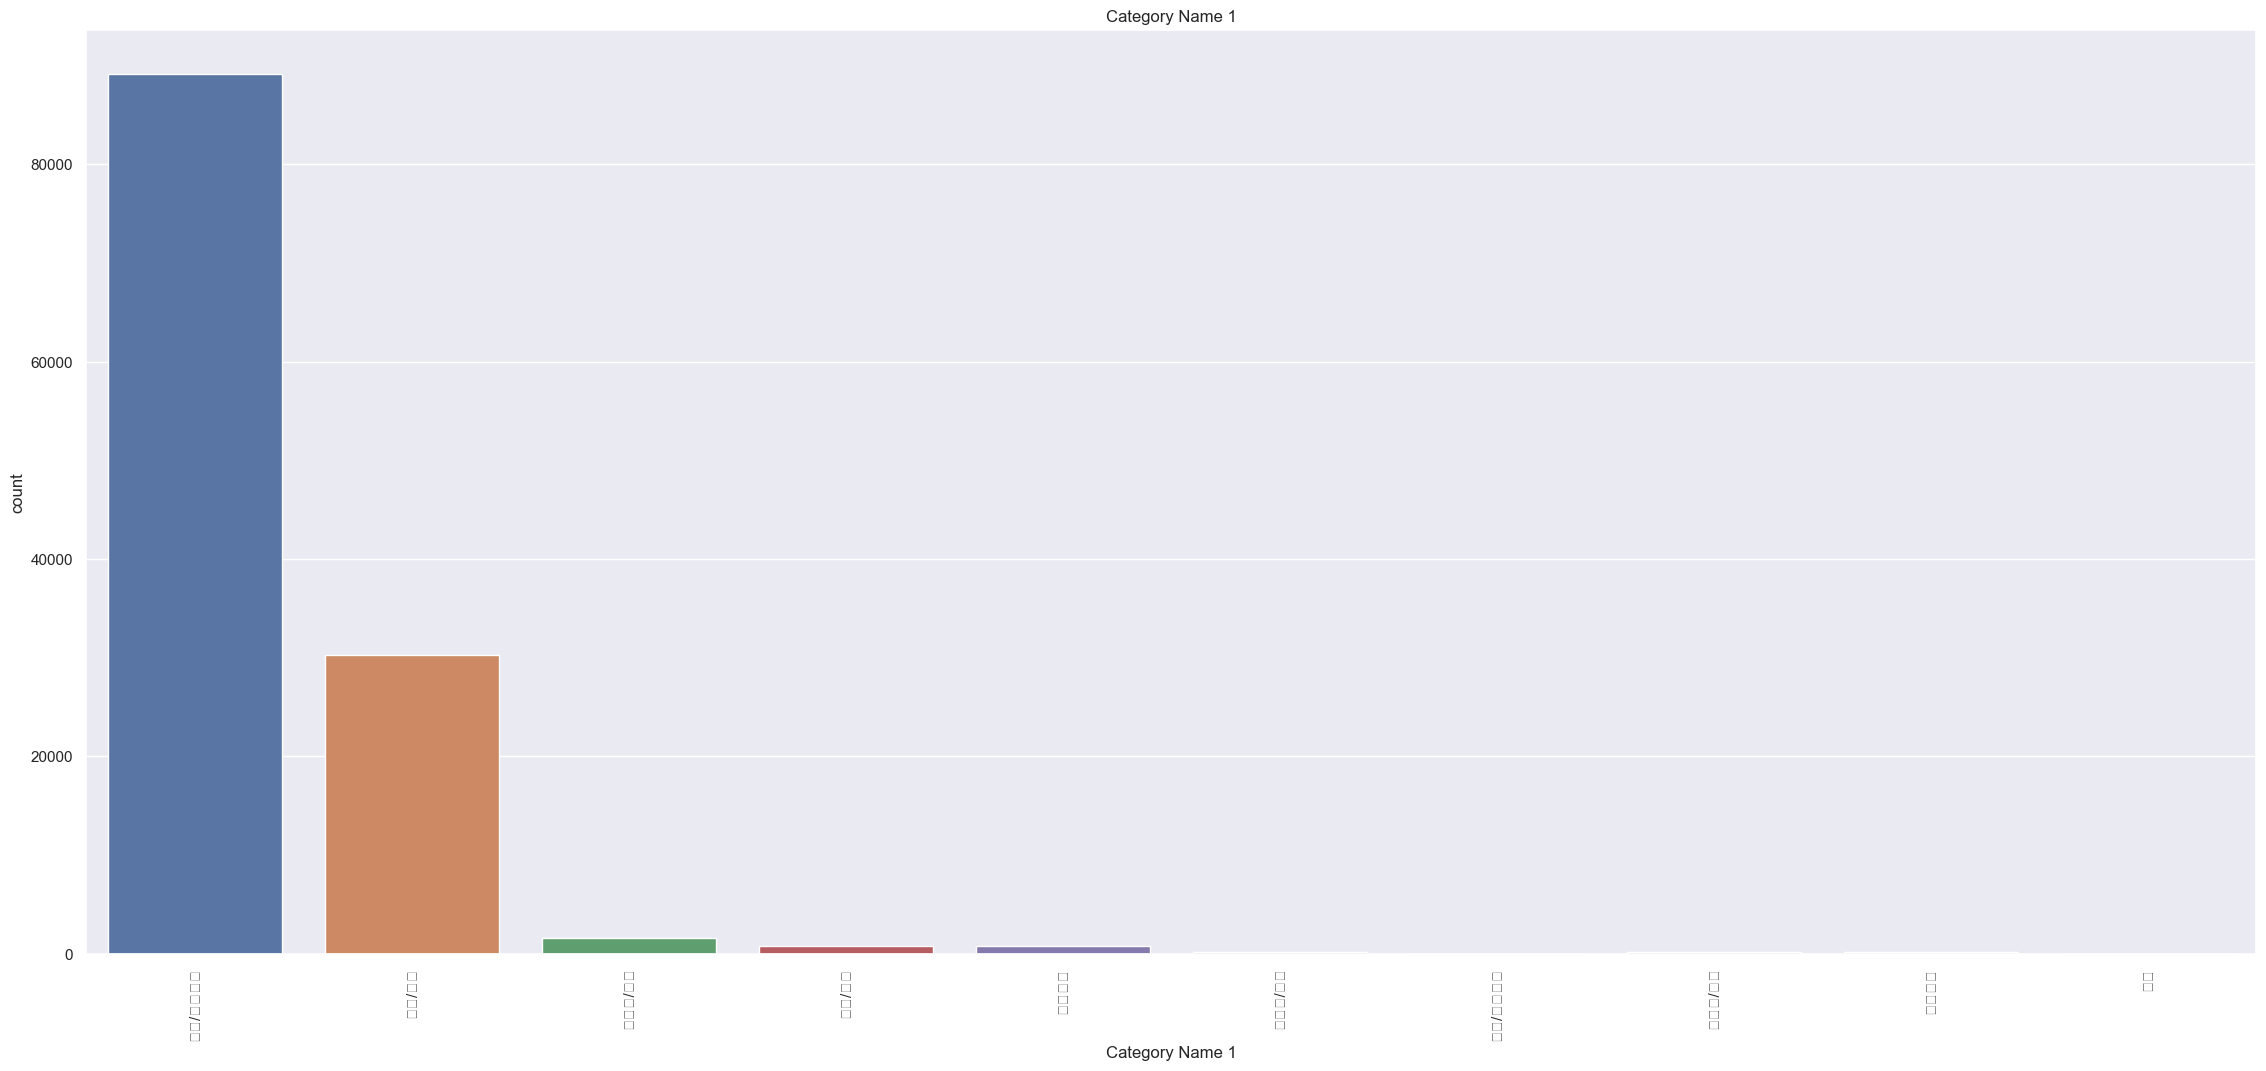

In [56]:
#수치표현
#그래프표현
# text = Rank 26 초과 특징
rank_Analysis(rank_up_26)

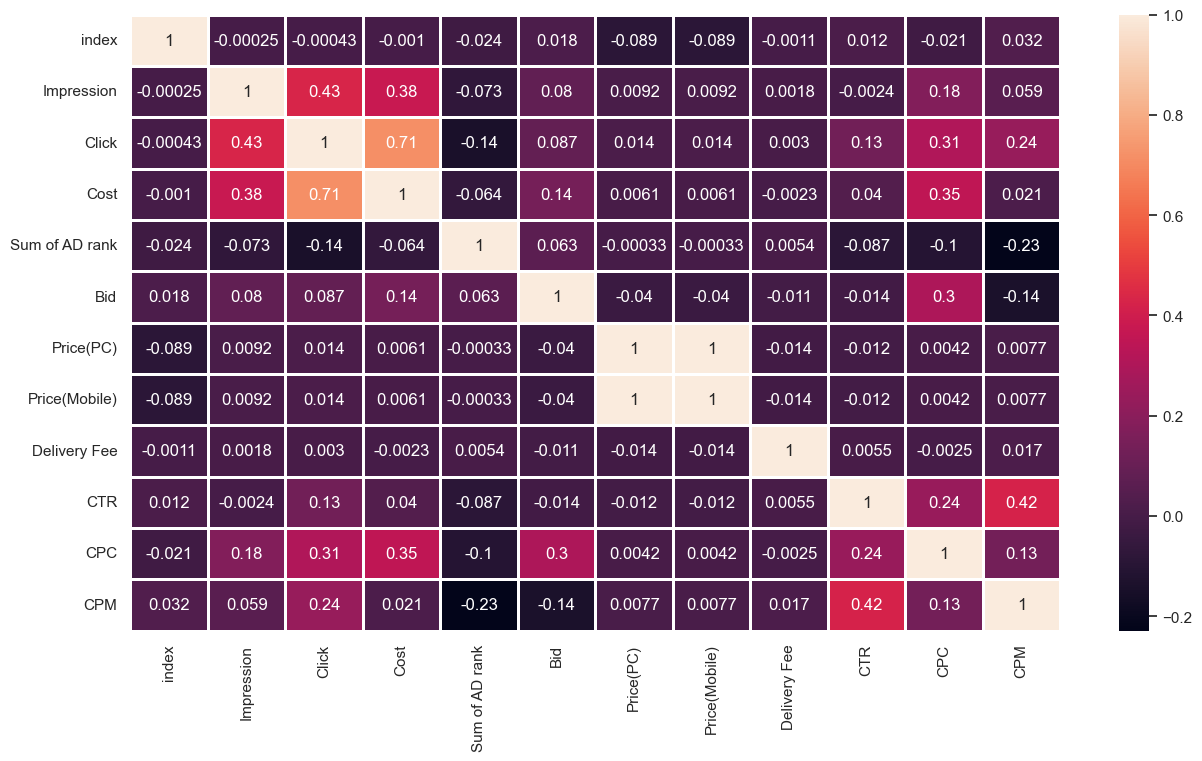

In [57]:
#그래프표현
# text = Rank 26 이하 상관관계
corr_heat(rank_down_26)

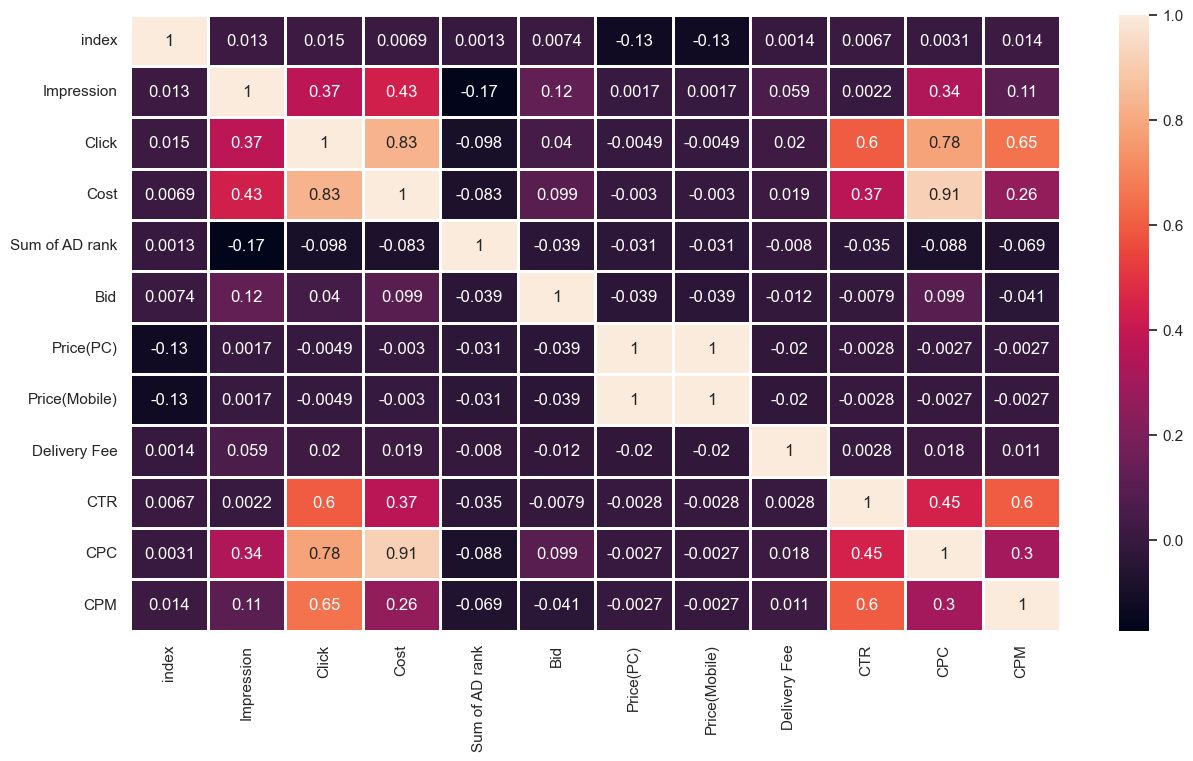

In [58]:
#그래프표현
# text = Rank 26 초과 상관관계
corr_heat(rank_up_26)

In [59]:
rank_down_7 = bidding_drop_null[bidding_drop_null['Sum of AD rank'] <= 7]

비용평균
295.6721806514001
--------------------------------------------------


코스트 썼을때 평균 순위 : 3.62562659972033
코스트 안 썼을때 평균 순위 : 4.045323442735004
--------------------------------------------------


광고숫자비율
6.262983342236196
--------------------------------------------------


배달비 없음 비율
64.56414332017447


배달비 있음 비율
35.435856679825534
--------------------------------------------------


상품가격 중간값
57000.0 원
--------------------------------------------------


카테고리1


가구/인테리어    0.694310
생활/건강      0.247353
출산/육아      0.024533
스포츠/레저     0.012416
화장품/미용     0.007564
디지털/가전     0.005643
패션잡화       0.005385
패션의류       0.001684
여가/생활편의    0.001003
식품         0.000109
Name: Category Name 1, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: 

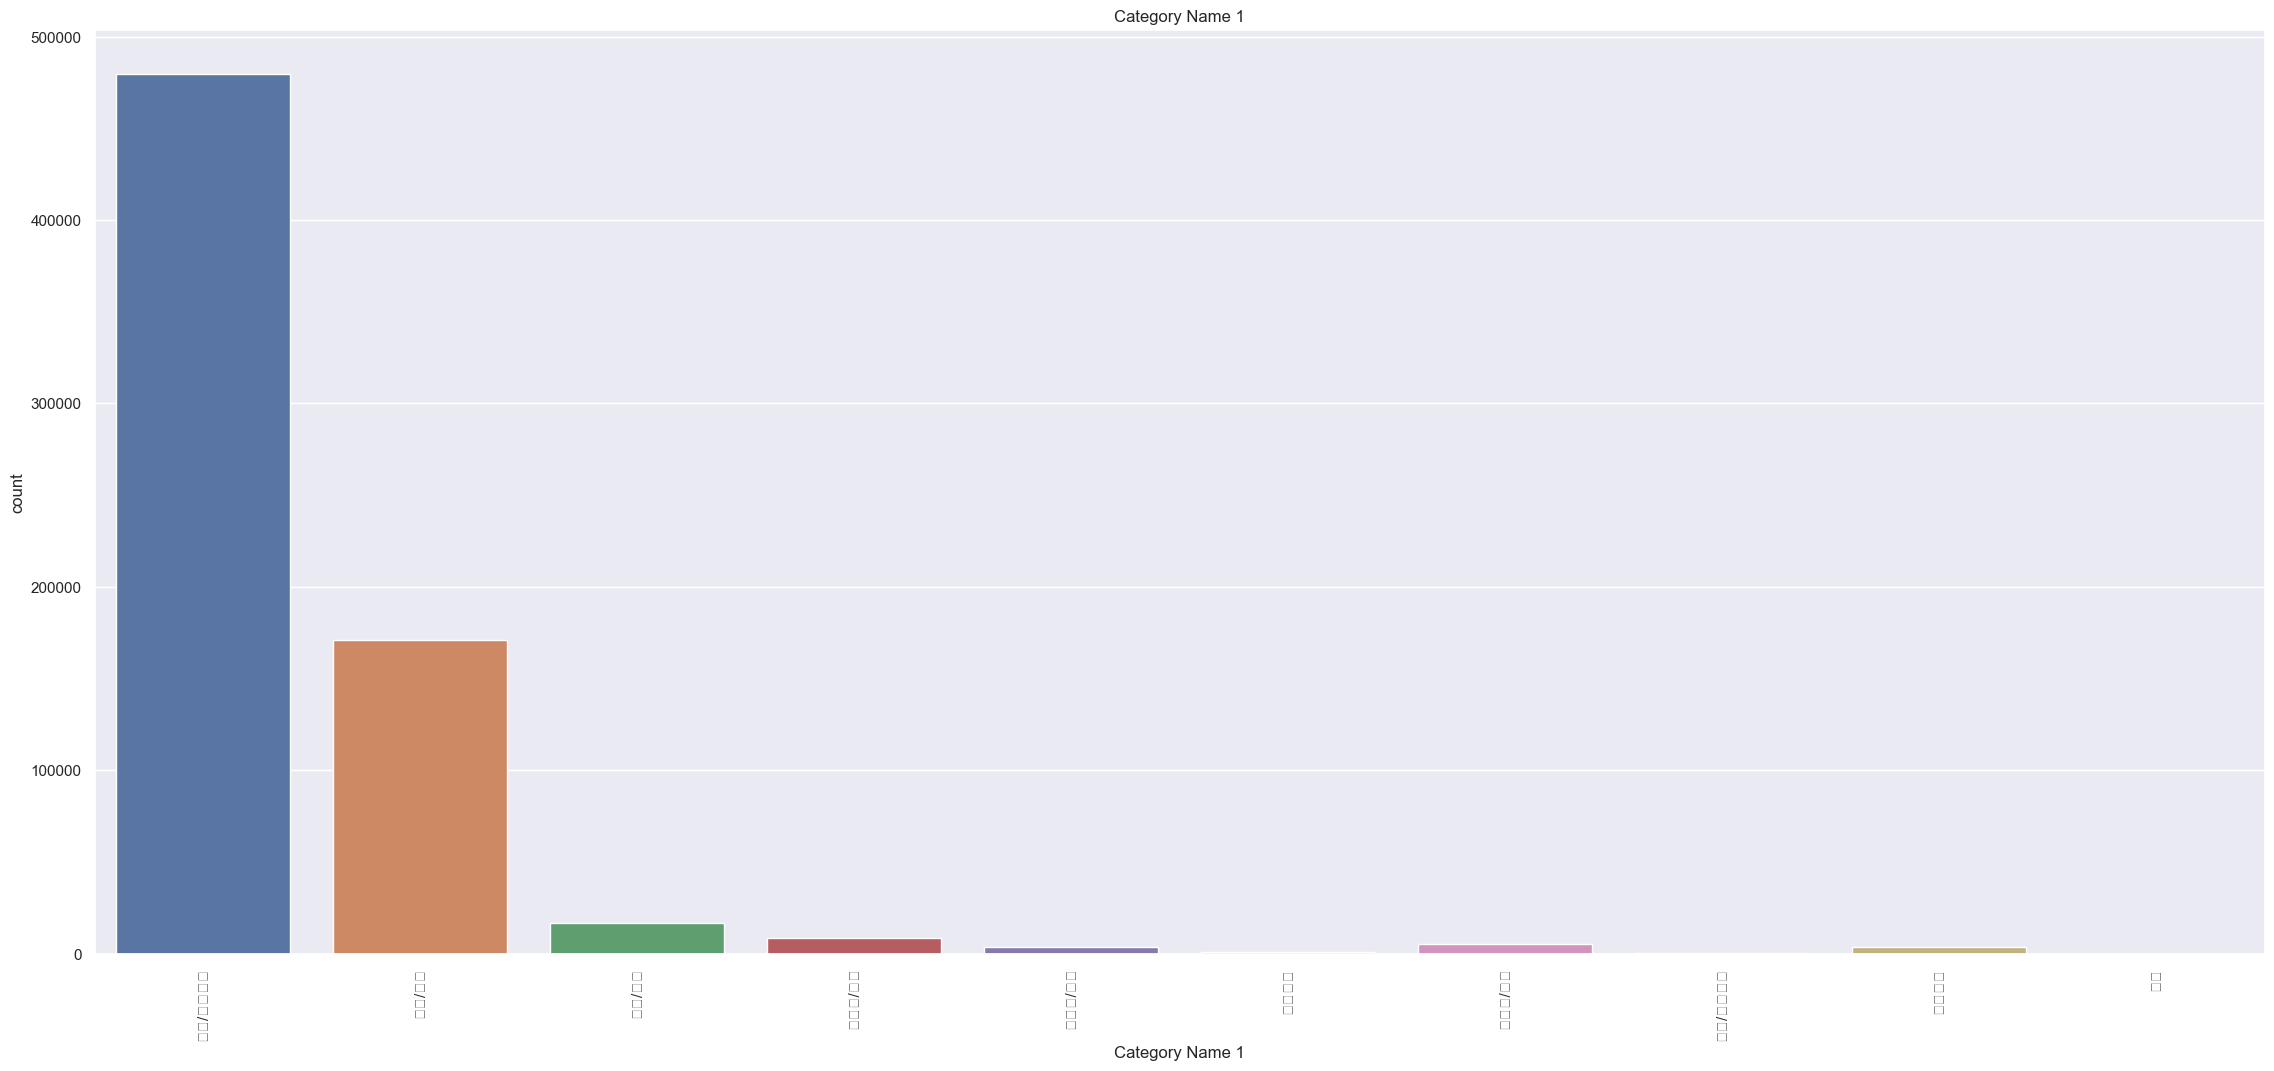

In [60]:
#수치표현
#그래프표현
# text = Rank 7 이하 특징
rank_Analysis(rank_down_7)

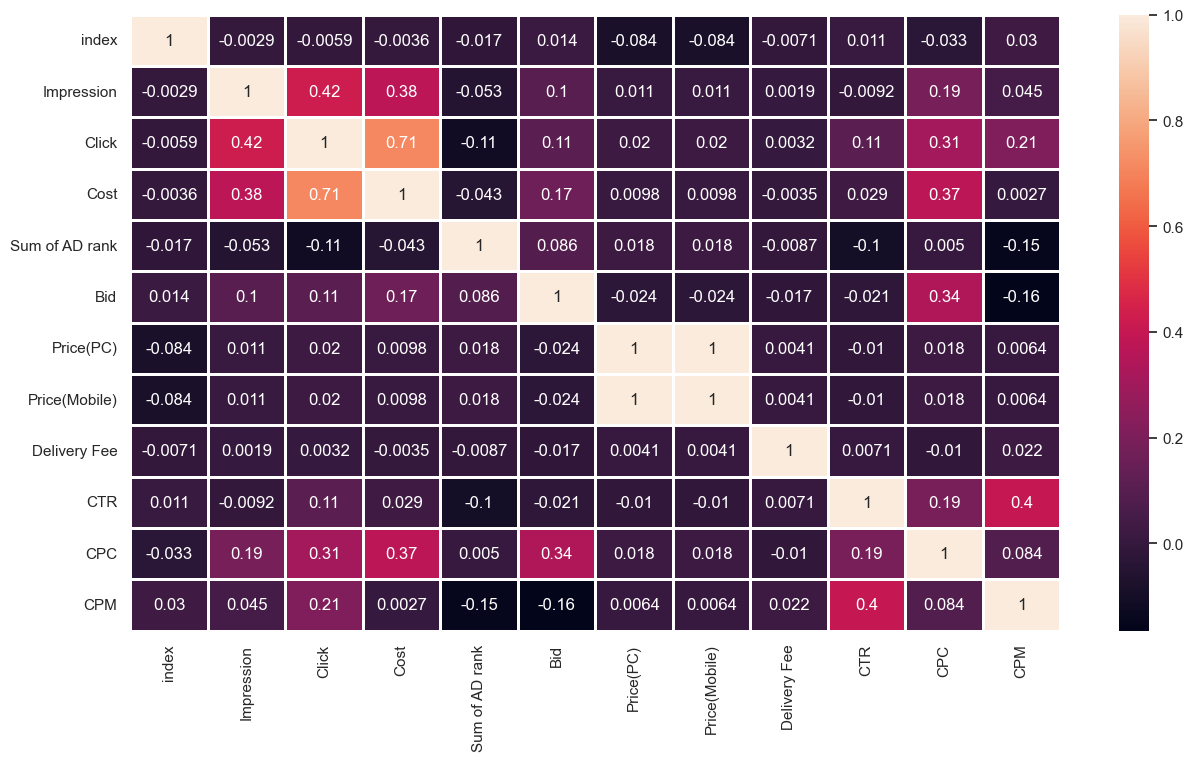

In [61]:
#그래프표현
# text = Rank 7 이하 상관관계
corr_heat(rank_down_7)

# Category 1별 분석

In [62]:
#수치표현
bidding_drop_null['Category Name 1'].value_counts(normalize=True)

가구/인테리어    0.716563
생활/건강      0.234380
출산/육아      0.018748
스포츠/레저     0.012001
패션잡화       0.005850
화장품/미용     0.005612
디지털/가전     0.004307
패션의류       0.001751
여가/생활편의    0.000630
식품         0.000158
Name: Category Name 1, dtype: float64

In [63]:
cat_val_1 = bidding_drop_null[bidding_drop_null['Category Name 1'].isin(['식품'])]
cat_val_2 = bidding_drop_null[bidding_drop_null['Category Name 1'].isin(['스포츠/레저'])]
cat_val_3 = bidding_drop_null[bidding_drop_null['Category Name 1'].isin(['출산/육아'])]
cat_val_4 = bidding_drop_null[bidding_drop_null['Category Name 1'].isin(['패션의류'])]
cat_val_5 = bidding_drop_null[bidding_drop_null['Category Name 1'].isin(['생활/건강'])]
cat_val_6 = bidding_drop_null[bidding_drop_null['Category Name 1'].isin(['디지털/가전'])]
cat_val_7 = bidding_drop_null[bidding_drop_null['Category Name 1'].isin(['가구/인테리어'])]
cat_val_8 = bidding_drop_null[bidding_drop_null['Category Name 1'].isin(['화장품/미용'])]
cat_val_9 = bidding_drop_null[bidding_drop_null['Category Name 1'].isin(['패션잡화'])]
cat_val_10 = bidding_drop_null[bidding_drop_null['Category Name 1'].isin(['여가/생활편의'])]

In [64]:
def cat_val(df):
    
    print(f'광고비율 : {(len(list(set(df["index"].values))) / len(df))*100}')
    print('-' * 50)
    cat_col = ['Click', 'Cost', 'Sum of AD rank', 'Impression']
    
    for col in cat_col:
        print(f'{col} 평균 : {df[col].mean()}')
        print('-' * 50)
        print(df[col].value_counts(normalize=True))
        print('-' * 50)
        plt.figure(figsize=(16, 6))
        plt.hist(df[col], bins=20)
        plt.title(col)
        plt.xticks(rotation=90)

In [65]:
#수치표현
# Total Data 광고 비율

print((len(list(set(bidding_drop_null['index'].values))) / len(bidding_drop_null))*100)

3.642247547533787


In [66]:
#수치표현
#그래프표현
# text = Category1 별 광고 비율
print("식품 광고숫자비율")
print((len(list(set(cat_val_1['index'].values))) / len(cat_val_1))*100)
print('-' * 50)
print("스포츠/레저 광고숫자비율")
print((len(list(set(cat_val_2['index'].values))) / len(cat_val_2))*100)
print('-' * 50)
print("출산/육아 광고숫자비율")
print((len(list(set(cat_val_3['index'].values))) / len(cat_val_3))*100)
print('-' * 50)
print("패션의류 광고숫자비율")
print((len(list(set(cat_val_4['index'].values))) / len(cat_val_4))*100)
print('-' * 50)
print("생활/건강 광고숫자비율")
print((len(list(set(cat_val_5['index'].values))) / len(cat_val_5))*100)
print('-' * 50)
print("디지털/가전 광고숫자비율")
print((len(list(set(cat_val_6['index'].values))) / len(cat_val_6))*100)
print('-' * 50)
print("가구/인테리어 광고숫자비율")
print((len(list(set(cat_val_7['index'].values))) / len(cat_val_7))*100)
print('-' * 50)
print("화장품/미용 광고숫자비율")
print((len(list(set(cat_val_8['index'].values))) / len(cat_val_8))*100)
print('-' * 50)
print("패션잡화 광고숫자비율")
print((len(list(set(cat_val_9['index'].values))) / len(cat_val_9))*100)
print('-' * 50)
print("여가/생활편의 광고숫자비율")
print((len(list(set(cat_val_10['index'].values))) / len(cat_val_10))*100)
print('-' * 50)

식품 광고숫자비율
3.8095238095238098
--------------------------------------------------
스포츠/레저 광고숫자비율
3.5302954431647473
--------------------------------------------------
출산/육아 광고숫자비율
3.73041631606363
--------------------------------------------------
패션의류 광고숫자비율
5.105105105105105
--------------------------------------------------
생활/건강 광고숫자비율
3.749891830043364
--------------------------------------------------
디지털/가전 광고숫자비율
3.2089291942797344
--------------------------------------------------
가구/인테리어 광고숫자비율
3.608356038440209
--------------------------------------------------
화장품/미용 광고숫자비율
4.028911792263418
--------------------------------------------------
패션잡화 광고숫자비율
3.4797123780174624
--------------------------------------------------
여가/생활편의 광고숫자비율
3.221957040572793
--------------------------------------------------


In [67]:
#수치표현
# text = Total Data Click 평균

bidding_drop_null['Click'].mean()

0.7218645278622247

In [68]:
#수치표현
#그래프표현
# text = Category1 별 Click 평균
print('식품')
print(cat_val_1['Click'].mean())
print('-' * 50)
print(cat_val_1['Click'].value_counts(normalize=True))
print('-' * 50)
print('스포츠/레저')
print(cat_val_2['Click'].mean())
print('-' * 50)
print(cat_val_2['Click'].value_counts(normalize=True))
print('-' * 50)
print('출산/육아')
print(cat_val_3['Click'].mean())
print('-' * 50)
print(cat_val_3['Click'].value_counts(normalize=True))
print('-' * 50)
print('패션의류')
print(cat_val_4['Click'].mean())
print('-' * 50)
print(cat_val_4['Click'].value_counts(normalize=True))
print('-' * 50)
print('생활/건강')
print(cat_val_5['Click'].mean())
print('-' * 50)
print(cat_val_5['Click'].value_counts(normalize=True))
print('-' * 50)
print('디지털/가전')
print(cat_val_6['Click'].mean())
print('-' * 50)
print(cat_val_6['Click'].value_counts(normalize=True))
print('-' * 50)
print('가구/인테리어')
print(cat_val_7['Click'].mean())
print('-' * 50)
print(cat_val_7['Click'].value_counts(normalize=True))
print('-' * 50)
print('화장품/미용')
print(cat_val_8['Click'].mean())
print('-' * 50)
print(cat_val_8['Click'].value_counts(normalize=True))
print('-' * 50)
print('패션잡화')
print(cat_val_9['Click'].mean())
print('-' * 50)
print(cat_val_9['Click'].value_counts(normalize=True))
print('-' * 50)
print('여가/생활편의/건강')
print(cat_val_10['Click'].mean())
print('-' * 50)
print(cat_val_10['Click'].value_counts(normalize=True))
print('-' * 50)

식품
0.11428571428571428
--------------------------------------------------
0    0.895238
1    0.100000
3    0.004762
Name: Click, dtype: float64
--------------------------------------------------
스포츠/레저
1.2496244366549825
--------------------------------------------------
0      0.670255
1      0.158112
2      0.064847
3      0.034051
4      0.021282
         ...   
150    0.000063
61     0.000063
45     0.000063
58     0.000063
59     0.000063
Name: Click, Length: 75, dtype: float64
--------------------------------------------------
출산/육아
2.120126617782586
--------------------------------------------------
0      0.578876
1      0.170253
2      0.078936
3      0.039989
4      0.026606
         ...   
144    0.000040
68     0.000040
94     0.000040
73     0.000040
71     0.000040
Name: Click, Length: 94, dtype: float64
--------------------------------------------------
패션의류
1.0574860574860574
--------------------------------------------------
0     0.734878
1     0.139425
2     0.043758

In [69]:
#수치표현
# text = Total Data Cost 평균
bidding_drop_null['Cost'].mean()

180.75467375194467

In [70]:
#수치표현
# text = Category1 별 Cost 평균
print('식품')
print(cat_val_1['Cost'].mean())
print('-' * 50)
print(cat_val_1['Cost'].value_counts(normalize=True))
print('-' * 50)
print('스포츠/레저')
print(cat_val_2['Cost'].mean())
print('-' * 50)
print(cat_val_2['Cost'].value_counts(normalize=True))
print('-' * 50)
print('출산/육아')
print(cat_val_3['Cost'].mean())
print('-' * 50)
print(cat_val_3['Cost'].value_counts(normalize=True))
print('-' * 50)
print('패션의류')
print(cat_val_4['Cost'].sum())
print('-' * 50)
print(cat_val_4['Cost'].value_counts(normalize=True))
print('-' * 50)
print('생활/건강')
print(cat_val_5['Cost'].mean())
print('-' * 50)
print(cat_val_5['Cost'].value_counts(normalize=True))
print('-' * 50)
print('디지털/가전')
print(cat_val_6['Cost'].mean())
print('-' * 50)
print(cat_val_6['Cost'].value_counts(normalize=True))
print('-' * 50)
print('가구/인테리어')
print(cat_val_7['Cost'].sum())
print('-' * 50)
print(cat_val_7['Cost'].value_counts(normalize=True))
print('-' * 50)
print('화장품/미용')
print(cat_val_8['Cost'].mean())
print('-' * 50)
print(cat_val_8['Cost'].value_counts(normalize=True))
print('-' * 50)
print('패션잡화')
print(cat_val_9['Cost'].mean())
print('-' * 50)
print(cat_val_9['Cost'].value_counts(normalize=True))
print('-' * 50)
print('여가/생활편의/건강')
print(cat_val_10['Cost'].mean())
print('-' * 50)
print(cat_val_10['Cost'].value_counts(normalize=True))
print('-' * 50)

식품
9.428571428571429
--------------------------------------------------
0.0      0.895238
50.0     0.076190
210.0    0.009524
150.0    0.004762
180.0    0.004762
100.0    0.004762
330.0    0.004762
Name: Cost, dtype: float64
--------------------------------------------------
스포츠/레저
195.1583625438157
--------------------------------------------------
0.0        0.670255
50.0       0.086755
100.0      0.034301
150.0      0.016838
200.0      0.012644
             ...   
15370.0    0.000063
7520.0     0.000063
5130.0     0.000063
3030.0     0.000063
15800.0    0.000063
Name: Cost, Length: 384, dtype: float64
--------------------------------------------------
출산/육아
293.0640702007453
--------------------------------------------------
0.0        0.578876
50.0       0.106383
100.0      0.049124
150.0      0.026165
200.0      0.018071
             ...   
4510.0     0.000040
5860.0     0.000040
12440.0    0.000040
3220.0     0.000040
2590.0     0.000040
Name: Cost, Length: 538, dtype: float64
--

In [71]:
#수치표현
# text = Total Data Sum of AD rank 평균
bidding_drop_null['Sum of AD rank'].mean()

11.395459472615535

In [72]:
#수치표현
#그래프표현
# text = Category1 별 Sum of AD rank 평균
print('식품')
print(cat_val_1['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_1['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('스포츠/레저')
print(cat_val_2['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_2['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('출산/육아')
print(cat_val_3['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_3['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('패션의류')
print(cat_val_4['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_4['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('생활/건강')
print(cat_val_5['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_5['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('디지털/가전')
print(cat_val_6['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_6['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('가구/인테리어')
print(cat_val_7['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_7['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('화장품/미용')
print(cat_val_8['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_8['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('패션잡화')
print(cat_val_9['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_9['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('여가/생활편의/건강')
print(cat_val_10['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_10['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)

식품
10.471428571428572
--------------------------------------------------
9.0     0.114286
8.0     0.100000
10.0    0.095238
3.0     0.085714
7.0     0.080952
12.0    0.066667
2.0     0.052381
4.0     0.047619
6.0     0.047619
13.0    0.042857
11.0    0.038095
5.0     0.038095
14.0    0.023810
17.0    0.023810
18.0    0.014286
26.0    0.014286
16.0    0.014286
30.0    0.009524
22.0    0.009524
24.0    0.009524
15.0    0.009524
28.0    0.009524
20.0    0.009524
31.0    0.009524
27.0    0.004762
25.0    0.004762
1.0     0.004762
23.0    0.004762
29.0    0.004762
54.0    0.004762
73.0    0.004762
Name: Sum of AD rank, dtype: float64
--------------------------------------------------
스포츠/레저
11.489672008012018
--------------------------------------------------
2.0     0.107974
4.0     0.084627
3.0     0.080809
5.0     0.071795
6.0     0.069604
          ...   
82.0    0.000188
79.0    0.000188
88.0    0.000125
81.0    0.000125
85.0    0.000125
Name: Sum of AD rank, Length: 100, dtype: float6

In [73]:
#수치표현
# text = Total Data Impression 평균

bidding_drop_null['Impression'].mean()

44.281237159248235

In [74]:
#수치표현
# text = Category1 별 Impression 평균
print('식품')
print(cat_val_1['Impression'].mean())
print('-' * 50)
print(cat_val_1['Impression'].value_counts(normalize=True))
print('-' * 50)
print('스포츠/레저')
print(cat_val_2['Impression'].mean())
print('-' * 50)
print(cat_val_2['Impression'].value_counts(normalize=True))
print('-' * 50)
print('출산/육아')
print(cat_val_3['Impression'].mean())
print('-' * 50)
print(cat_val_3['Impression'].value_counts(normalize=True))
print('-' * 50)
print('패션의류')
print(cat_val_4['Impression'].mean())
print('-' * 50)
print(cat_val_4['Impression'].value_counts(normalize=True))
print('-' * 50)
print('생활/건강')
print(cat_val_5['Impression'].mean())
print('-' * 50)
print(cat_val_5['Impression'].value_counts(normalize=True))
print('-' * 50)
print('디지털/가전')
print(cat_val_6['Impression'].mean())
print('-' * 50)
print(cat_val_6['Impression'].value_counts(normalize=True))
print('-' * 50)
print('가구/인테리어')
print(cat_val_7['Impression'].mean())
print('-' * 50)
print(cat_val_7['Impression'].value_counts(normalize=True))
print('-' * 50)
print('화장품/미용')
print(cat_val_8['Impression'].mean())
print('-' * 50)
print(cat_val_8['Impression'].value_counts(normalize=True))
print('-' * 50)
print('패션잡화')
print(cat_val_9['Impression'].mean())
print('-' * 50)
print(cat_val_9['Impression'].value_counts(normalize=True))
print('-' * 50)
print('여가/생활편의/건강')
print(cat_val_10['Impression'].mean())
print('-' * 50)
print(cat_val_10['Impression'].value_counts(normalize=True))
print('-' * 50)

식품
28.714285714285715
--------------------------------------------------
1      0.109524
3      0.076190
4      0.066667
2      0.061905
5      0.042857
         ...   
90     0.004762
123    0.004762
86     0.004762
146    0.004762
73     0.004762
Name: Impression, Length: 67, dtype: float64
--------------------------------------------------
스포츠/레저
60.6691912869304
--------------------------------------------------
1       0.082749
2       0.065160
3       0.055270
4       0.045068
5       0.038683
          ...   
347     0.000063
507     0.000063
633     0.000063
328     0.000063
1457    0.000063
Name: Impression, Length: 598, dtype: float64
--------------------------------------------------
출산/육아
76.07284529390552
--------------------------------------------------
1       0.042994
2       0.042353
3       0.032055
5       0.028369
4       0.027607
          ...   
2270    0.000040
602     0.000040
946     0.000040
815     0.000040
864     0.000040
Name: Impression, Length: 835, dty

In [75]:
#수치표현
# text = Total Data Price 평균

bidding_drop_null['Price(PC)'].median()

59000.0

In [76]:
#수치표현
#그래프표현
# text = Category1 별 Price 평균
print('식품')
print(cat_val_1['Price(PC)'].median())
print('-' * 50)
print(cat_val_1['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('스포츠/레저')
print(cat_val_2['Price(PC)'].median())
print('-' * 50)
print(cat_val_2['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('출산/육아')
print(cat_val_3['Price(PC)'].median())
print('-' * 50)
print(cat_val_3['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('패션의류')
print(cat_val_4['Price(PC)'].median())
print('-' * 50)
print(cat_val_4['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('생활/건강')
print(cat_val_5['Price(PC)'].median())
print('-' * 50)
print(cat_val_5['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('디지털/가전')
print(cat_val_6['Price(PC)'].median())
print('-' * 50)
print(cat_val_6['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('가구/인테리어')
print(cat_val_7['Price(PC)'].median())
print('-' * 50)
print(cat_val_7['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('화장품/미용')
print(cat_val_8['Price(PC)'].median())
print('-' * 50)
print(cat_val_8['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('패션잡화')
print(cat_val_9['Price(PC)'].median())
print('-' * 50)
print(cat_val_9['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('여가/생활편의/건강')
print(cat_val_10['Price(PC)'].median())
print('-' * 50)
print(cat_val_10['Price(PC)'].value_counts(normalize=True))
print('-' * 50)

식품
10900.0
--------------------------------------------------
5900     0.271429
52000    0.142857
51000    0.114286
9900     0.095238
48500    0.076190
43100    0.066667
12000    0.057143
4400     0.047619
5500     0.047619
11900    0.042857
9000     0.023810
7500     0.014286
Name: Price(PC), dtype: float64
--------------------------------------------------
스포츠/레저
42800.0
--------------------------------------------------
15900    0.020781
9900     0.013395
17000    0.013395
99000    0.011955
24900    0.011517
           ...   
21000    0.000063
23800    0.000063
26500    0.000063
5000     0.000063
18100    0.000063
Name: Price(PC), Length: 436, dtype: float64
--------------------------------------------------
출산/육아
32900.0
--------------------------------------------------
8900     0.022038
39900    0.017310
19900    0.016989
19800    0.016789
12900    0.015266
           ...   
6000     0.000040
14895    0.000040
46500    0.000040
22400    0.000040
46300    0.000040
Name: Price(PC),

## 광고별 Category 1 분석

In [77]:
idx = (list(set(bidding_drop_null["index"].values)))
idx_cat = bidding_drop_null.drop_duplicates(['index'])
idx_cat

index  Impression  Click   Cost  Sum of AD rank  Bid  Price(PC)  \
date                                                                            
2022-10-31  3575092           3      0    0.0             3.0   50     165900   
2022-10-31  3575637           6      0    0.0             3.0   50      10900   
2022-10-31  4129259           7      0    0.0             8.0   50     255000   
2022-10-31  4131479          36      3  150.0             4.0  140     190000   
2022-10-31  4131482         224      0    0.0             6.0   50     129000   
...             ...         ...    ...    ...             ...  ...        ...   
2023-01-03  2566795           5      0    0.0            13.0  500      19900   
2023-01-03  2566880           3      0    0.0            17.0  500      23900   
2023-01-03  2566881           1      0    0.0             8.0  500       2500   
2023-01-03  2566891           2      0    0.0             4.0  500      21000   
2023-01-03  2566923          14      0    0.0            12.0  500     128800   

            Price(Mobile)  Delivery Fee Category Name 1 Category Name 2  \
date                                                                      
2022-10-31         165900             0         가구/인테리어            침실가구   
2022-10-31          10900             0         가구/인테리어          인테리어소품   
2022-10-31         255000            -1         가구/인테리어            거실가구   
2022-10-31         190000         20000         가구/인테리어        아동/주니어가구   
2022-10-31         129000             0         가구/인테리어        아동/주니어가구   
...                   ...           ...             ...             ...   
2023-01-03          19900             0         가구/인테리어          인테리어소품   
2023-01-03          23900          3000           생활/건강         문구/사무용품   
2023-01-03           2500          3000         가구/인테리어          인테리어소품   
2023-01-03          21000          3000           생활/건강         정원/원예용품   
2023-01-03         128800             0         가구/인테리어          인테리어소품   

           Category Name 3 Category Name 4       CTR   CPC   CPM  
date                                                              
2022-10-31         장롱/붙박이장            드레스룸  0.000000   0.0  0.00  
2022-10-31        아로마/캔들용품      아로마방향제/디퓨저  0.000000   0.0  0.00  
2022-10-31              소파           패브릭소파  0.000000   0.0  0.00  
2022-10-31          책상의자세트       null_cat4  8.333333  50.0  0.02  
2022-10-31              책상       null_cat4  0.000000   0.0  0.00  
...                    ...             ...       ...   ...   ...  
2023-01-03        아로마/캔들용품      아로마방향제/디퓨저  0.000000   0.0  0.00  
2023-01-03        이벤트/파티용품            데코용품  0.000000   0.0  0.00  
2023-01-03          기타장식용품       null_cat4  0.000000   0.0  0.00  
2023-01-03            화분받침       null_cat4  0.000000   0.0  0.00  
2023-01-03              액자      퍼즐/그림/사진액자  0.000000   0.0  0.00  

[48486 rows x 16 columns]

In [78]:
cat_val_1 = idx_cat[idx_cat['Category Name 1'].isin(['식품'])]
cat_val_2 = idx_cat[idx_cat['Category Name 1'].isin(['스포츠/레저'])]
cat_val_3 = idx_cat[idx_cat['Category Name 1'].isin(['출산/육아'])]
cat_val_4 = idx_cat[idx_cat['Category Name 1'].isin(['패션의류'])]
cat_val_5 = idx_cat[idx_cat['Category Name 1'].isin(['생활/건강'])]
cat_val_6 = idx_cat[idx_cat['Category Name 1'].isin(['디지털/가전'])]
cat_val_7 = idx_cat[idx_cat['Category Name 1'].isin(['가구/인테리어'])]
cat_val_8 = idx_cat[idx_cat['Category Name 1'].isin(['화장품/미용'])]
cat_val_9 = idx_cat[idx_cat['Category Name 1'].isin(['패션잡화'])]
cat_val_10 = idx_cat[idx_cat['Category Name 1'].isin(['여가/생활편의'])]

In [79]:
#수치표현
# text = 광고 Data Click 평균
idx_cat['Click'].mean()

0.6015757125768263

In [80]:
#수치표현
#그래프표현
# text = 광고 Data Category1 별 Click 평균
print('식품')
print(cat_val_1['Click'].mean())
print('-' * 50)
print(cat_val_1['Click'].value_counts(normalize=True))
print('-' * 50)
print('스포츠/레저')
print(cat_val_2['Click'].mean())
print('-' * 50)
print(cat_val_2['Click'].value_counts(normalize=True))
print('-' * 50)
print('출산/육아')
print(cat_val_3['Click'].mean())
print('-' * 50)
print(cat_val_3['Click'].value_counts(normalize=True))
print('-' * 50)
print('패션의류')
print(cat_val_4['Click'].mean())
print('-' * 50)
print(cat_val_4['Click'].value_counts(normalize=True))
print('-' * 50)
print('생활/건강')
print(cat_val_5['Click'].mean())
print('-' * 50)
print(cat_val_5['Click'].value_counts(normalize=True))
print('-' * 50)
print('디지털/가전')
print(cat_val_6['Click'].mean())
print('-' * 50)
print(cat_val_6['Click'].value_counts(normalize=True))
print('-' * 50)
print('가구/인테리어')
print(cat_val_7['Click'].mean())
print('-' * 50)
print(cat_val_7['Click'].value_counts(normalize=True))
print('-' * 50)
print('화장품/미용')
print(cat_val_8['Click'].mean())
print('-' * 50)
print(cat_val_8['Click'].value_counts(normalize=True))
print('-' * 50)
print('패션잡화')
print(cat_val_9['Click'].mean())
print('-' * 50)
print(cat_val_9['Click'].value_counts(normalize=True))
print('-' * 50)
print('여가/생활편의/건강')
print(cat_val_10['Click'].mean())
print('-' * 50)
print(cat_val_10['Click'].value_counts(normalize=True))
print('-' * 50)

식품
0.0
--------------------------------------------------
0    1.0
Name: Click, dtype: float64
--------------------------------------------------
스포츠/레저
1.4078014184397163
--------------------------------------------------
0      0.698582
1      0.134752
2      0.051418
3      0.030142
4      0.019504
6      0.014184
5      0.014184
8      0.005319
12     0.003546
7      0.003546
10     0.003546
145    0.001773
16     0.001773
19     0.001773
20     0.001773
21     0.001773
27     0.001773
44     0.001773
33     0.001773
11     0.001773
13     0.001773
14     0.001773
32     0.001773
Name: Click, dtype: float64
--------------------------------------------------
출산/육아
1.4477933261571583
--------------------------------------------------
0     0.641550
1     0.160388
2     0.069968
3     0.027987
4     0.023681
5     0.013994
6     0.009688
7     0.007535
13    0.007535
9     0.006459
8     0.005382
11    0.004306
10    0.003229
19    0.002153
16    0.002153
12    0.002153
30    0.002153

In [81]:
#수치표현
# text = 광고 Data Cost 평균

idx_cat['Cost'].mean()

176.55921296869198

In [82]:
#수치표현
#그래프표현
# text = 광고 Data Category1 별 Cost 평균
print('식품')
print(cat_val_1['Cost'].mean())
print('-' * 50)
print(cat_val_1['Cost'].value_counts(normalize=True))
print('-' * 50)
print('스포츠/레저')
print(cat_val_2['Cost'].mean())
print('-' * 50)
print(cat_val_2['Cost'].value_counts(normalize=True))
print('-' * 50)
print('출산/육아')
print(cat_val_3['Cost'].mean())
print('-' * 50)
print(cat_val_3['Cost'].value_counts(normalize=True))
print('-' * 50)
print('패션의류')
print(cat_val_4['Cost'].mean())
print('-' * 50)
print(cat_val_4['Cost'].value_counts(normalize=True))
print('-' * 50)
print('생활/건강')
print(cat_val_5['Cost'].mean())
print('-' * 50)
print(cat_val_5['Cost'].value_counts(normalize=True))
print('-' * 50)
print('디지털/가전')
print(cat_val_6['Cost'].mean())
print('-' * 50)
print(cat_val_6['Cost'].value_counts(normalize=True))
print('-' * 50)
print('가구/인테리어')
print(cat_val_7['Cost'].mean())
print('-' * 50)
print(cat_val_7['Cost'].value_counts(normalize=True))
print('-' * 50)
print('화장품/미용')
print(cat_val_8['Cost'].mean())
print('-' * 50)
print(cat_val_8['Cost'].value_counts(normalize=True))
print('-' * 50)
print('패션잡화')
print(cat_val_9['Cost'].mean())
print('-' * 50)
print(cat_val_9['Cost'].value_counts(normalize=True))
print('-' * 50)
print('여가/생활편의/건강')
print(cat_val_10['Cost'].mean())
print('-' * 50)
print(cat_val_10['Cost'].value_counts(normalize=True))
print('-' * 50)

식품
0.0
--------------------------------------------------
0.0    1.0
Name: Cost, dtype: float64
--------------------------------------------------
스포츠/레저
319.3262411347518
--------------------------------------------------
0.0       0.698582
50.0      0.051418
100.0     0.017730
200.0     0.017730
160.0     0.010638
            ...   
4070.0    0.001773
870.0     0.001773
1930.0    0.001773
680.0     0.001773
250.0     0.001773
Name: Cost, Length: 88, dtype: float64
--------------------------------------------------
출산/육아
267.83638320775026
--------------------------------------------------
0.0       0.641550
50.0      0.077503
100.0     0.021529
150.0     0.019376
200.0     0.015070
            ...   
1170.0    0.001076
5270.0    0.001076
1090.0    0.001076
1070.0    0.001076
800.0     0.001076
Name: Cost, Length: 112, dtype: float64
--------------------------------------------------
패션의류
575.1260504201681
--------------------------------------------------
0.0        0.747899
500.0   

In [83]:
#수치표현
# text = 광고 Data Sum of AD rank 평균
idx_cat['Sum of AD rank'].mean()

12.199232768221755

In [84]:
#수치표현
#그래프표현
# text = 광고 Data Category1 별 Sum of AD rank 평균
print('식품')
print(cat_val_1['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_1['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('스포츠/레저')
print(cat_val_2['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_2['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('출산/육아')
print(cat_val_3['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_3['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('패션의류')
print(cat_val_4['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_4['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('생활/건강')
print(cat_val_5['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_5['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('디지털/가전')
print(cat_val_6['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_6['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('가구/인테리어')
print(cat_val_7['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_7['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('화장품/미용')
print(cat_val_8['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_8['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('패션잡화')
print(cat_val_9['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_9['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)
print('여가/생활편의/건강')
print(cat_val_10['Sum of AD rank'].mean())
print('-' * 50)
print(cat_val_10['Sum of AD rank'].value_counts(normalize=True))
print('-' * 50)

식품
13.125
--------------------------------------------------
10.0    0.250
11.0    0.125
17.0    0.125
16.0    0.125
5.0     0.125
6.0     0.125
30.0    0.125
Name: Sum of AD rank, dtype: float64
--------------------------------------------------
스포츠/레저
11.053191489361701
--------------------------------------------------
3.0     0.085106
2.0     0.085106
6.0     0.083333
1.0     0.072695
5.0     0.067376
4.0     0.067376
8.0     0.056738
7.0     0.054965
9.0     0.049645
10.0    0.040780
12.0    0.033688
11.0    0.031915
13.0    0.028369
16.0    0.019504
20.0    0.017730
15.0    0.017730
18.0    0.015957
19.0    0.014184
17.0    0.012411
24.0    0.010638
21.0    0.010638
33.0    0.008865
25.0    0.008865
14.0    0.008865
22.0    0.008865
28.0    0.007092
38.0    0.007092
29.0    0.005319
34.0    0.005319
23.0    0.005319
30.0    0.005319
31.0    0.005319
35.0    0.003546
26.0    0.003546
43.0    0.003546
44.0    0.003546
32.0    0.003546
64.0    0.003546
95.0    0.003546
42.0    0.001

In [85]:
#수치표현
# text = 광고 Data Impression 평균
idx_cat['Impression'].mean()

34.98997648805841

In [86]:
#수치표현
#그래프표현
# text = 광고 Data Category1 별 Impression 평균
print('식품')
print(cat_val_1['Impression'].mean())
print('-' * 50)
print(cat_val_1['Impression'].value_counts(normalize=True))
print('-' * 50)
print('스포츠/레저')
print(cat_val_2['Impression'].mean())
print('-' * 50)
print(cat_val_2['Impression'].value_counts(normalize=True))
print('-' * 50)
print('출산/육아')
print(cat_val_3['Impression'].mean())
print('-' * 50)
print(cat_val_3['Impression'].value_counts(normalize=True))
print('-' * 50)
print('패션의류')
print(cat_val_4['Impression'].mean())
print('-' * 50)
print(cat_val_4['Impression'].value_counts(normalize=True))
print('-' * 50)
print('생활/건강')
print(cat_val_5['Impression'].mean())
print('-' * 50)
print(cat_val_5['Impression'].value_counts(normalize=True))
print('-' * 50)
print('디지털/가전')
print(cat_val_6['Impression'].mean())
print('-' * 50)
print(cat_val_6['Impression'].value_counts(normalize=True))
print('-' * 50)
print('가구/인테리어')
print(cat_val_7['Impression'].mean())
print('-' * 50)
print(cat_val_7['Impression'].value_counts(normalize=True))
print('-' * 50)
print('화장품/미용')
print(cat_val_8['Impression'].mean())
print('-' * 50)
print(cat_val_8['Impression'].value_counts(normalize=True))
print('-' * 50)
print('패션잡화')
print(cat_val_9['Impression'].mean())
print('-' * 50)
print(cat_val_9['Impression'].value_counts(normalize=True))
print('-' * 50)
print('여가/생활편의/건강')
print(cat_val_10['Impression'].mean())
print('-' * 50)
print(cat_val_10['Impression'].value_counts(normalize=True))
print('-' * 50)

식품
12.625
--------------------------------------------------
1     0.250
53    0.125
8     0.125
3     0.125
29    0.125
2     0.125
4     0.125
Name: Impression, dtype: float64
--------------------------------------------------
스포츠/레저
70.90602836879432
--------------------------------------------------
1      0.115248
3      0.076241
5      0.054965
2      0.053191
4      0.051418
         ...   
878    0.001773
832    0.001773
75     0.001773
142    0.001773
367    0.001773
Name: Impression, Length: 136, dtype: float64
--------------------------------------------------
출산/육아
58.27125941872982
--------------------------------------------------
1       0.099031
2       0.076426
3       0.052745
4       0.037675
5       0.036598
          ...   
1007    0.001076
188     0.001076
166     0.001076
87      0.001076
225     0.001076
Name: Impression, Length: 206, dtype: float64
--------------------------------------------------
패션의류
55.89915966386555
----------------------------------------

In [87]:
#수치표현
# text = 광고 Data Price 평균

idx_cat['Price(PC)'].median()

54750.0

In [88]:
#수치표현
#그래프표현
# text = 광고 Data Category1 별 Price 평균
print('식품')
print(cat_val_1['Price(PC)'].median())
print('-' * 50)
print(cat_val_1['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('스포츠/레저')
print(cat_val_2['Price(PC)'].median())
print('-' * 50)
print(cat_val_2['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('출산/육아')
print(cat_val_3['Price(PC)'].median())
print('-' * 50)
print(cat_val_3['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('패션의류')
print(cat_val_4['Price(PC)'].median())
print('-' * 50)
print(cat_val_4['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('생활/건강')
print(cat_val_5['Price(PC)'].median())
print('-' * 50)
print(cat_val_5['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('디지털/가전')
print(cat_val_6['Price(PC)'].median())
print('-' * 50)
print(cat_val_6['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('가구/인테리어')
print(cat_val_7['Price(PC)'].median())
print('-' * 50)
print(cat_val_7['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('화장품/미용')
print(cat_val_8['Price(PC)'].median())
print('-' * 50)
print(cat_val_8['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('패션잡화')
print(cat_val_9['Price(PC)'].median())
print('-' * 50)
print(cat_val_9['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('여가/생활편의/건강')
print(cat_val_10['Price(PC)'].median())
print('-' * 50)
print(cat_val_10['Price(PC)'].value_counts(normalize=True))
print('-' * 50)

식품
10900.0
--------------------------------------------------
48500    0.125
43100    0.125
12000    0.125
9000     0.125
5900     0.125
9900     0.125
4400     0.125
11900    0.125
Name: Price(PC), dtype: float64
--------------------------------------------------
스포츠/레저
34950.0
--------------------------------------------------
9900     0.015957
15900    0.015957
29900    0.014184
13900    0.012411
99000    0.012411
           ...   
94200    0.001773
99800    0.001773
24000    0.001773
35000    0.001773
18100    0.001773
Name: Price(PC), Length: 321, dtype: float64
--------------------------------------------------
출산/육아
31900.0
--------------------------------------------------
19900     0.016146
8900      0.015070
12900     0.015070
14900     0.015070
9900      0.015070
            ...   
101900    0.001076
49000     0.001076
39800     0.001076
38800     0.001076
46300     0.001076
Name: Price(PC), Length: 417, dtype: float64
--------------------------------------------------
패션의류


# Prophet

In [89]:
bidding_drop_null

index  Impression  Click   Cost  Sum of AD rank  Bid  Price(PC)  \
date                                                                            
2022-10-31  3575092           3      0    0.0             3.0   50     165900   
2022-10-31  3575637           6      0    0.0             3.0   50      10900   
2022-10-31  4129259           7      0    0.0             8.0   50     255000   
2022-10-31  4131479          36      3  150.0             4.0  140     190000   
2022-10-31  4131482         224      0    0.0             6.0   50     129000   
...             ...         ...    ...    ...             ...  ...        ...   
2023-01-03  2566795           5      0    0.0            13.0  500      19900   
2023-01-03  2566880           3      0    0.0            17.0  500      23900   
2023-01-03  2566881           1      0    0.0             8.0  500       2500   
2023-01-03  2566891           2      0    0.0             4.0  500      21000   
2023-01-03  2566923          14      0    0.0            12.0  500     128800   

            Price(Mobile)  Delivery Fee Category Name 1 Category Name 2  \
date                                                                      
2022-10-31         165900             0         가구/인테리어            침실가구   
2022-10-31          10900             0         가구/인테리어          인테리어소품   
2022-10-31         255000            -1         가구/인테리어            거실가구   
2022-10-31         190000         20000         가구/인테리어        아동/주니어가구   
2022-10-31         129000             0         가구/인테리어        아동/주니어가구   
...                   ...           ...             ...             ...   
2023-01-03          19900             0         가구/인테리어          인테리어소품   
2023-01-03          23900          3000           생활/건강         문구/사무용품   
2023-01-03           2500          3000         가구/인테리어          인테리어소품   
2023-01-03          21000          3000           생활/건강         정원/원예용품   
2023-01-03         128800             0         가구/인테리어          인테리어소품   

           Category Name 3 Category Name 4       CTR   CPC   CPM  
date                                                              
2022-10-31         장롱/붙박이장            드레스룸  0.000000   0.0  0.00  
2022-10-31        아로마/캔들용품      아로마방향제/디퓨저  0.000000   0.0  0.00  
2022-10-31              소파           패브릭소파  0.000000   0.0  0.00  
2022-10-31          책상의자세트       null_cat4  8.333333  50.0  0.02  
2022-10-31              책상       null_cat4  0.000000   0.0  0.00  
...                    ...             ...       ...   ...   ...  
2023-01-03        아로마/캔들용품      아로마방향제/디퓨저  0.000000   0.0  0.00  
2023-01-03        이벤트/파티용품            데코용품  0.000000   0.0  0.00  
2023-01-03          기타장식용품       null_cat4  0.000000   0.0  0.00  
2023-01-03            화분받침       null_cat4  0.000000   0.0  0.00  
2023-01-03              액자      퍼즐/그림/사진액자  0.000000   0.0  0.00  

[1331211 rows x 16 columns]

In [90]:
bidding_drop_null["Year"] = bidding_drop_null.index.year 
bidding_drop_null["Quarter"] = bidding_drop_null.index.quarter
bidding_drop_null["Month"] = bidding_drop_null.index.month
bidding_drop_null["Week"] = bidding_drop_null.index.week
bidding_drop_null["Weekday"] = bidding_drop_null.index.weekday
bidding_drop_null["Day"] = bidding_drop_null.index.day
bidding_drop_null["Dayofyear"] = bidding_drop_null.index.dayofyear
bidding_drop_null["Date"] = pd.DatetimeIndex(bidding_drop_null.index).date

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\369508341.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


In [91]:
date_list = list(set(bidding_drop_null['Date']))
columns = ['ds', 'y']                 
bid_click_mean = pd.DataFrame(columns=columns)
for date in date_list:
    bid_mean = bidding_drop_null.loc[bidding_drop_null['Date'] == date]
    bid_click_mean = bid_click_mean.append(pd.DataFrame([[date, bid_mean['Click'].mean()]], columns=columns), ignore_index=True)
bid_click_mean

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\2295778703.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\2295778703.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\2295778703.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\2295778703.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\2295778703.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\2295778703.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\2295778703.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\2295778703.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\2295778703.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\2295778703.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat

ds         y
0   2022-12-18  0.757989
1   2022-11-09  0.961733
2   2022-11-28  0.641022
3   2023-01-03  0.633492
4   2022-11-03  0.843241
5   2022-12-03  0.531727
6   2022-12-26  0.526847
7   2022-11-11  0.606745
8   2022-11-02  0.847124
9   2022-12-11  0.652076
10  2022-11-30  0.534365
11  2022-11-20  1.001390
12  2022-11-01  0.953660
13  2022-11-05  0.826110
14  2022-12-30  0.431669
15  2022-11-13  0.880543
16  2023-01-02  0.650235
17  2022-12-19  0.663140
18  2022-11-16  1.122542
19  2022-11-17  1.032849
20  2022-12-17  0.659115
21  2022-11-21  0.983612
22  2023-01-01  0.661223
23  2022-12-16  0.611492
24  2022-12-29  0.457397
25  2022-11-15  1.123845
26  2022-11-22  0.939041
27  2022-11-04  0.789683
28  2022-12-05  0.702655
29  2022-11-24  0.699797
30  2022-11-19  0.929850
31  2022-11-29  0.525391
32  2022-10-31  0.949690
33  2022-12-04  0.703089
34  2022-12-09  0.537875
35  2022-12-13  0.687738
36  2022-12-25  0.640977
37  2022-11-06  1.047710
38  2022-12-28  0.472837
39  2022-11-18  0.816412
40  2022-12-08  0.618713
41  2022-11-14  1.023490
42  2022-11-07  0.880552
43  2022-11-26  0.711475
44  2022-11-12  0.725481
45  2022-12-02  0.530147
46  2022-12-10  0.565216
47  2022-12-14  0.709359
48  2022-11-23  0.739611
49  2022-11-27  0.781684
50  2022-12-31  0.498751
51  2022-12-27  0.486840
52  2022-11-08  0.934523
53  2022-12-15  0.643306
54  2022-11-25  0.594217
55  2022-12-12  0.658366
56  2022-11-10  0.750285

In [92]:
date_list = list(set(bidding_drop_null['Date']))
columns = ['ds', 'y']                 
bid_cost_mean = pd.DataFrame(columns=columns)
for date in date_list:
    bid_mean = bidding_drop_null.loc[bidding_drop_null['Date'] == date]
    bid_cost_mean = bid_cost_mean.append(pd.DataFrame([[date, bid_mean['Cost'].mean()]], columns=columns), ignore_index=True)
bid_cost_mean

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\2444552252.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\2444552252.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\2444552252.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\2444552252.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\2444552252.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\2444552252.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\2444552252.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\2444552252.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\2444552252.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\2444552252.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat

ds           y
0   2022-12-18  193.888544
1   2022-11-09  334.609118
2   2022-11-28  171.429050
3   2023-01-03  150.507852
4   2022-11-03  167.876646
5   2022-12-03  118.732808
6   2022-12-26   97.522416
7   2022-11-11  119.585008
8   2022-11-02  158.357830
9   2022-12-11  103.359263
10  2022-11-30  106.982133
11  2022-11-20  222.427923
12  2022-11-01  224.028436
13  2022-11-05  152.869224
14  2022-12-30   76.565096
15  2022-11-13  167.881078
16  2023-01-02  147.834754
17  2022-12-19  169.374135
18  2022-11-16  368.630126
19  2022-11-17  319.730845
20  2022-12-17  194.915047
21  2022-11-21  252.453693
22  2023-01-01  133.649640
23  2022-12-16  179.120792
24  2022-12-29   81.629220
25  2022-11-15  326.498622
26  2022-11-22  348.076431
27  2022-11-04  160.005998
28  2022-12-05  185.586727
29  2022-11-24  252.805574
30  2022-11-19  228.391854
31  2022-11-29  115.563368
32  2022-10-31  274.325752
33  2022-12-04  147.650540
34  2022-12-09  118.270338
35  2022-12-13  176.177765
36  2022-12-25  131.987965
37  2022-11-06  203.304268
38  2022-12-28   88.582770
39  2022-11-18  204.375233
40  2022-12-08  140.951480
41  2022-11-14  262.176811
42  2022-11-07  190.119882
43  2022-11-26  232.300703
44  2022-11-12  150.201687
45  2022-12-02  125.056595
46  2022-12-10  104.567936
47  2022-12-14  174.118430
48  2022-11-23  248.469250
49  2022-11-27  265.413244
50  2022-12-31   97.818873
51  2022-12-27   87.813564
52  2022-11-08  316.589703
53  2022-12-15  158.679834
54  2022-11-25  179.631066
55  2022-12-12  169.041690
56  2022-11-10  209.471357

In [93]:
date_list = list(set(bidding_drop_null['Date']))
columns = ['ds', 'y']                 
bid_imp_mean = pd.DataFrame(columns=columns)
for date in date_list:
    bid_mean = bidding_drop_null.loc[bidding_drop_null['Date'] == date]
    bid_imp_mean = bid_imp_mean.append(pd.DataFrame([[date, bid_mean['Impression'].mean()]], columns=columns), ignore_index=True)
bid_imp_mean

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\554960166.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\554960166.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\554960166.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\554960166.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\554960166.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inst

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\554960166.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\554960166.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\554960166.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\554960166.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_6324\554960166.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inst

ds          y
0   2022-12-18  39.630282
1   2022-11-09  63.792032
2   2022-11-28  43.073753
3   2023-01-03  37.862890
4   2022-11-03  54.343724
5   2022-12-03  27.682443
6   2022-12-26  31.212314
7   2022-11-11  44.907055
8   2022-11-02  54.600388
9   2022-12-11  34.191919
10  2022-11-30  33.029866
11  2022-11-20  65.557149
12  2022-11-01  58.081547
13  2022-11-05  53.331244
14  2022-12-30  25.576013
15  2022-11-13  60.034312
16  2023-01-02  37.538041
17  2022-12-19  34.919841
18  2022-11-16  73.723778
19  2022-11-17  65.824990
20  2022-12-17  35.359483
21  2022-11-21  64.103285
22  2023-01-01  40.526439
23  2022-12-16  32.379245
24  2022-12-29  26.797279
25  2022-11-15  75.897066
26  2022-11-22  59.755991
27  2022-11-04  51.451451
28  2022-12-05  36.416858
29  2022-11-24  44.320043
30  2022-11-19  61.221457
31  2022-11-29  35.769661
32  2022-10-31  58.619343
33  2022-12-04  35.587634
34  2022-12-09  28.926894
35  2022-12-13  36.141684
36  2022-12-25  38.436780
37  2022-11-06  65.091592
38  2022-12-28  28.207512
39  2022-11-18  55.356807
40  2022-12-08  32.709113
41  2022-11-14  69.319419
42  2022-11-07  62.720012
43  2022-11-26  46.349461
44  2022-11-12  50.811627
45  2022-12-02  27.937632
46  2022-12-10  29.774385
47  2022-12-14  36.818770
48  2022-11-23  48.338274
49  2022-11-27  49.822447
50  2022-12-31  31.098505
51  2022-12-27  28.741771
52  2022-11-08  64.074712
53  2022-12-15  33.635155
54  2022-11-25  40.637017
55  2022-12-12  35.641879
56  2022-11-10  52.716516

00:01:32 - cmdstanpy - INFO - Chain [1] start processing
00:01:32 - cmdstanpy - INFO - Chain [1] done processing


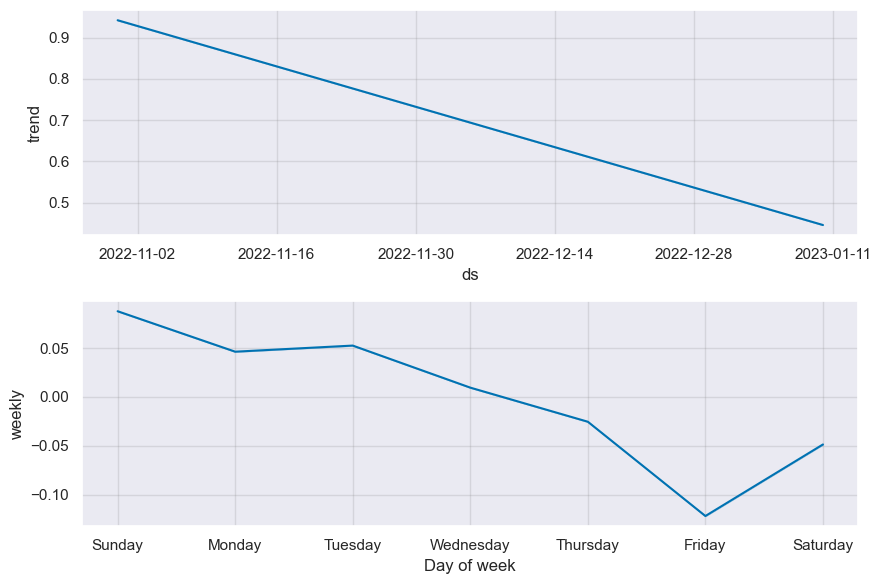

In [94]:
prophet = Prophet()
prophet.fit(bid_click_mean)


# create a future data frame 
future = prophet.make_future_dataframe(periods=7, freq = 'D')
forecast = prophet.predict(future)

fig2 = prophet.plot_components(forecast)
plt.show()

00:01:33 - cmdstanpy - INFO - Chain [1] start processing
00:01:33 - cmdstanpy - INFO - Chain [1] done processing


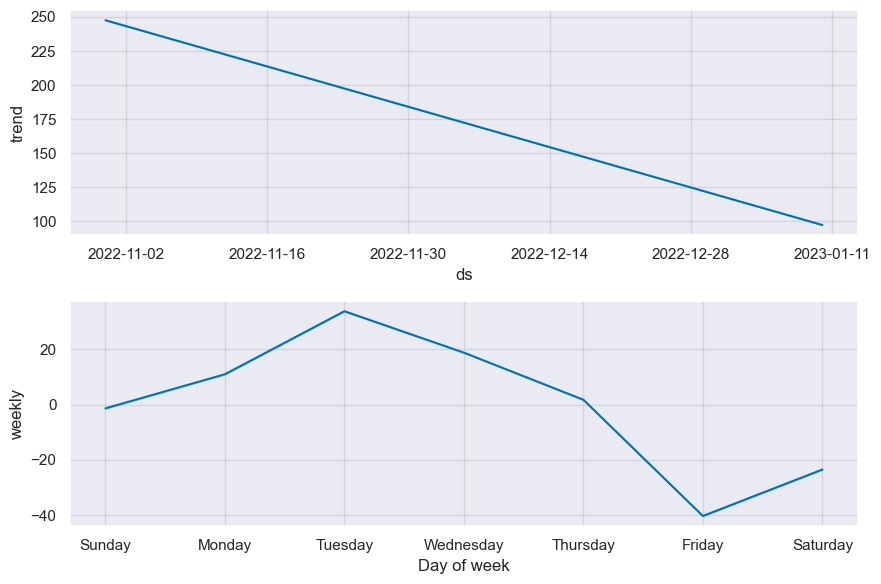

In [95]:
prophet = Prophet()
prophet.fit(bid_cost_mean)


# create a future data frame 
future = prophet.make_future_dataframe(periods=7, freq = 'D')
forecast = prophet.predict(future)

fig2 = prophet.plot_components(forecast)
plt.show()

00:01:34 - cmdstanpy - INFO - Chain [1] start processing
00:01:34 - cmdstanpy - INFO - Chain [1] done processing


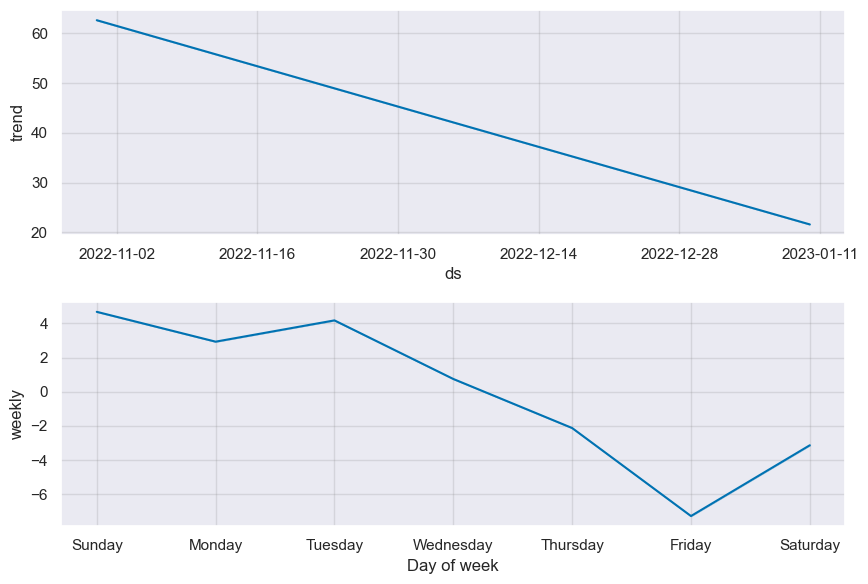

In [96]:
prophet = Prophet()
prophet.fit(bid_imp_mean)


# create a future data frame 
future = prophet.make_future_dataframe(periods=7, freq = 'D')
forecast = prophet.predict(future)

fig2 = prophet.plot_components(forecast)
plt.show()

# Categocy1 평가모델(NDCG, MAP)

In [97]:
def NDCG(selected,ordered):
    import numpy as np
    from tqdm import tqdm
    DCG = 0
    iDCG = 0
    
    selected_result = ((np.array(selected) - 1)==0)
    for idx, (i,k) in tqdm(enumerate(zip(selected_result,ordered))):
        if i==True:
            DCG += ((max(ordered) - (k-1)) / (np.log2(idx+1 + 1)))
            
    cum_index = 0
    for idx, i in tqdm(enumerate(range(sum(selected)))):
        iDCG += ((len(selected) - cum_index) / (np.log2(idx+1 + 1)))
        cum_index += 1
    
    NDCG = DCG / iDCG
    
    return NDCG

In [98]:
bidding_drop_null[bidding_drop_null['Month'] == 1]

index  Impression  Click    Cost  Sum of AD rank  Bid  \
date                                                                  
2023-01-01  3575092          11      4   840.0             3.0  300   
2023-01-01  3575637          10      0     0.0             5.0   50   
2023-01-01  4131479          62      1    50.0             4.0   50   
2023-01-01  4158472         396      7   420.0             3.0  100   
2023-01-01  4159066        7532     29  8680.0             2.0  290   
...             ...         ...    ...     ...             ...  ...   
2023-01-03  2566795           5      0     0.0            13.0  500   
2023-01-03  2566880           3      0     0.0            17.0  500   
2023-01-03  2566881           1      0     0.0             8.0  500   
2023-01-03  2566891           2      0     0.0             4.0  500   
2023-01-03  2566923          14      0     0.0            12.0  500   

            Price(PC)  Price(Mobile)  Delivery Fee Category Name 1  ...  \
date                                                                ...   
2023-01-01     175900         175900             0         가구/인테리어  ...   
2023-01-01      10900          10900             0         가구/인테리어  ...   
2023-01-01     190000         190000         20000         가구/인테리어  ...   
2023-01-01     129000         129000             0         가구/인테리어  ...   
2023-01-01     149000         149000             0         가구/인테리어  ...   
...               ...            ...           ...             ...  ...   
2023-01-03      19900          19900             0         가구/인테리어  ...   
2023-01-03      23900          23900          3000           생활/건강  ...   
2023-01-03       2500           2500          3000         가구/인테리어  ...   
2023-01-03      21000          21000          3000           생활/건강  ...   
2023-01-03     128800         128800             0         가구/인테리어  ...   

                   CPC       CPM  Year  Quarter  Month  Week  Weekday  Day  \
date                                                                         
2023-01-01  210.000000  0.004762  2023        1      1    52        6    1   
2023-01-01    0.000000  0.000000  2023        1      1    52        6    1   
2023-01-01   50.000000  0.020000  2023        1      1    52        6    1   
2023-01-01   60.000000  0.016667  2023        1      1    52        6    1   
2023-01-01  299.310345  0.003341  2023        1      1    52        6    1   
...                ...       ...   ...      ...    ...   ...      ...  ...   
2023-01-03    0.000000  0.000000  2023        1      1     1        1    3   
2023-01-03    0.000000  0.000000  2023        1      1     1        1    3   
2023-01-03    0.000000  0.000000  2023        1      1     1        1    3   
2023-01-03    0.000000  0.000000  2023        1      1     1        1    3   
2023-01-03    0.000000  0.000000  2023        1      1     1        1    3   

            Dayofyear        Date  
date                               
2023-01-01          1  2023-01-01  
2023-01-01          1  2023-01-01  
2023-01-01          1  2023-01-01  
2023-01-01          1  2023-01-01  
2023-01-01          1  2023-01-01  
...               ...         ...  
2023-01-03          3  2023-01-03  
2023-01-03          3  2023-01-03  
2023-01-03          3  2023-01-03  
2023-01-03          3  2023-01-03  
2023-01-03          3  2023-01-03  

[84880 rows x 24 columns]

In [99]:
idx_bid = bidding_drop_null.drop_duplicates(['index'])

In [100]:
idx_bid[idx_bid['Month'] == 1]

index  Impression  Click  Cost  Sum of AD rank  Bid  Price(PC)  \
date                                                                           
2023-01-01  4423995           1      0   0.0            15.0  350     199000   
2023-01-01  4537785           1      0   0.0            13.0  350      64500   
2023-01-01  4893994           1      0   0.0             7.0  300      89900   
2023-01-01  4893996           1      0   0.0             6.0  300      79900   
2023-01-01  4893997           1      0   0.0             5.0  300      99900   
...             ...         ...    ...   ...             ...  ...        ...   
2023-01-03  2566795           5      0   0.0            13.0  500      19900   
2023-01-03  2566880           3      0   0.0            17.0  500      23900   
2023-01-03  2566881           1      0   0.0             8.0  500       2500   
2023-01-03  2566891           2      0   0.0             4.0  500      21000   
2023-01-03  2566923          14      0   0.0            12.0  500     128800   

            Price(Mobile)  Delivery Fee Category Name 1  ...  CPC  CPM  Year  \
date                                                     ...                   
2023-01-01         199000            -1         가구/인테리어  ...  0.0  0.0  2023   
2023-01-01          64500          8000         가구/인테리어  ...  0.0  0.0  2023   
2023-01-01          89900            -1         가구/인테리어  ...  0.0  0.0  2023   
2023-01-01          79900            -1         가구/인테리어  ...  0.0  0.0  2023   
2023-01-01          99900            -1         가구/인테리어  ...  0.0  0.0  2023   
...                   ...           ...             ...  ...  ...  ...   ...   
2023-01-03          19900             0         가구/인테리어  ...  0.0  0.0  2023   
2023-01-03          23900          3000           생활/건강  ...  0.0  0.0  2023   
2023-01-03           2500          3000         가구/인테리어  ...  0.0  0.0  2023   
2023-01-03          21000          3000           생활/건강  ...  0.0  0.0  2023   
2023-01-03         128800             0         가구/인테리어  ...  0.0  0.0  2023   

            Quarter  Month  Week  Weekday  Day  Dayofyear        Date  
date                                                                   
2023-01-01        1      1    52        6    1          1  2023-01-01  
2023-01-01        1      1    52        6    1          1  2023-01-01  
2023-01-01        1      1    52        6    1          1  2023-01-01  
2023-01-01        1      1    52        6    1          1  2023-01-01  
2023-01-01        1      1    52        6    1          1  2023-01-01  
...             ...    ...   ...      ...  ...        ...         ...  
2023-01-03        1      1     1        1    3          3  2023-01-03  
2023-01-03        1      1     1        1    3          3  2023-01-03  
2023-01-03        1      1     1        1    3          3  2023-01-03  
2023-01-03        1      1     1        1    3          3  2023-01-03  
2023-01-03        1      1     1        1    3          3  2023-01-03  

[595 rows x 24 columns]

In [101]:
month_10 = idx_bid[idx_bid['Month'].isin([10])]
month_11 = idx_bid[idx_bid['Month'].isin([11])]
month_12 = idx_bid[idx_bid['Month'].isin([12])]
month_1 = idx_bid[idx_bid['Month'].isin([1])]

In [102]:
cat_val_1 = idx_bid[idx_bid['Category Name 1'].isin(['식품'])]
cat_val_2 = idx_bid[idx_bid['Category Name 1'].isin(['스포츠/레저'])]
cat_val_3 = idx_bid[idx_bid['Category Name 1'].isin(['출산/육아'])]
cat_val_4 = idx_bid[idx_bid['Category Name 1'].isin(['패션의류'])]
cat_val_5 = idx_bid[idx_bid['Category Name 1'].isin(['생활/건강'])]
cat_val_6 = idx_bid[idx_bid['Category Name 1'].isin(['디지털/가전'])]
cat_val_7 = idx_bid[idx_bid['Category Name 1'].isin(['가구/인테리어'])]
cat_val_8 = idx_bid[idx_bid['Category Name 1'].isin(['화장품/미용'])]
cat_val_9 = idx_bid[idx_bid['Category Name 1'].isin(['패션잡화'])]
cat_val_10 = idx_bid[idx_bid['Category Name 1'].isin(['여가/생활편의'])]

In [103]:
cat_val_1_11 = cat_val_1[cat_val_1['Month'].isin([11])]
cat_val_1_12 = cat_val_1[cat_val_1['Month'].isin([12])]
cat_val_1_1 = cat_val_1[cat_val_1['Month'].isin([1])]
cat_val_1_10 = cat_val_1[cat_val_1['Month'].isin([10])]

In [104]:
cat_val_2_11 = cat_val_2[cat_val_2['Month'].isin([11])]
cat_val_2_12 = cat_val_2[cat_val_2['Month'].isin([12])]
cat_val_2_1 = cat_val_2[cat_val_2['Month'].isin([1])]
cat_val_2_10 = cat_val_2[cat_val_2['Month'].isin([10])]

In [105]:
cat_val_3_11 = cat_val_3[cat_val_3['Month'].isin([11])]
cat_val_3_12 = cat_val_3[cat_val_3['Month'].isin([12])]
cat_val_3_1 = cat_val_3[cat_val_3['Month'].isin([1])]
cat_val_3_10 = cat_val_3[cat_val_3['Month'].isin([10])]

In [106]:
cat_val_4_11 = cat_val_4[cat_val_4['Month'].isin([11])]
cat_val_4_12 = cat_val_4[cat_val_4['Month'].isin([12])]
cat_val_4_1 = cat_val_4[cat_val_4['Month'].isin([1])]
cat_val_4_10 = cat_val_4[cat_val_4['Month'].isin([10])]

In [107]:
cat_val_5_11 = cat_val_5[cat_val_5['Month'].isin([11])]
cat_val_5_12 = cat_val_5[cat_val_5['Month'].isin([12])]
cat_val_5_1 = cat_val_5[cat_val_5['Month'].isin([1])]
cat_val_5_10 = cat_val_5[cat_val_5['Month'].isin([10])]

In [108]:
cat_val_6_11 = cat_val_6[cat_val_6['Month'].isin([11])]
cat_val_6_12 = cat_val_6[cat_val_6['Month'].isin([12])]
cat_val_6_1 = cat_val_6[cat_val_6['Month'].isin([1])]
cat_val_6_10 = cat_val_6[cat_val_6['Month'].isin([10])]

In [109]:
cat_val_7_11 = cat_val_7[cat_val_7['Month'].isin([11])]
cat_val_7_12 = cat_val_7[cat_val_7['Month'].isin([12])]
cat_val_7_1 = cat_val_7[cat_val_7['Month'].isin([1])]
cat_val_7_10 = cat_val_7[cat_val_7['Month'].isin([10])]

In [110]:
cat_val_8_11 = cat_val_8[cat_val_8['Month'].isin([11])]
cat_val_8_12 = cat_val_8[cat_val_8['Month'].isin([12])]
cat_val_8_1 = cat_val_8[cat_val_8['Month'].isin([1])]
cat_val_8_10 = cat_val_8[cat_val_8['Month'].isin([10])]

In [111]:
cat_val_9_11 = cat_val_9[cat_val_9['Month'].isin([11])]
cat_val_9_12 = cat_val_9[cat_val_9['Month'].isin([12])]
cat_val_9_1 = cat_val_9[cat_val_9['Month'].isin([1])]
cat_val_9_10 = cat_val_9[cat_val_9['Month'].isin([10])]

In [112]:
cat_val_10_11 = cat_val_10[cat_val_10['Month'].isin([11])]
cat_val_10_12 = cat_val_10[cat_val_10['Month'].isin([12])]
cat_val_10_1 = cat_val_10[cat_val_10['Month'].isin([1])]
cat_val_10_10 = cat_val_10[cat_val_10['Month'].isin([10])]

# 대시보드 정리

## 상품가격별 분석
#결론 : 미미하지만 가설성립, 5~10만원대 상품들의 click과 cost의 상관관계가 낮아졌다 개선이필요하다

비용평균
167.80673792112006
--------------------------------------------------


코스트 썼을때 평균 순위 : 6.01917086348931
코스트 안 썼을때 평균 순위 : 13.595440104968716
--------------------------------------------------


광고숫자비율
3.8164244239623955
--------------------------------------------------


배달비 없음 비율
40.11324425725326


배달비 있음 비율
59.88675574274674
--------------------------------------------------


코스트비율
0.0        0.759737
50.0       0.051082
100.0      0.017548
150.0      0.009396
200.0      0.006845
             ...   
11830.0    0.000002
8910.0     0.000002
13810.0    0.000002
12050.0    0.000002
9060.0     0.000002
Name: Cost, Length: 1739, dtype: float64
--------------------------------------------------


코스트


count    149915.000000
mean        698.428176
std        3547.304425
min          50.000000
25%          90.000000
50%         210.000000
75%         500.000000
max      246040.000000
Name: Cost, dtype: float64

--------------------------------------------------


카테고리1


가구/인테리어    0.506722
생활/건강      0.417855
출산/육아      0.026109
스포츠/레저     0.015120
패션잡화       0.012150
화장품/미용     0.010542
디지털/가전     0.007847
패션의류       0.003034
여가/생활편의    0.000372
식품         0.000250
Name: Category Name 1, dtype: float64

--------------------------------------------------


코스트 있음 , 순위


count    149915.000000
mean          6.019171
std           6.244767
min           1.000000
25%           2.000000
50%           4.000000
75%           7.000000
max          98.000000
Name: Sum of AD rank, dtype: float64

--------------------------------------------------


코스트 없음 , 순위


count    474046.000000
mean         13.595440
std          15.471149
min           1.000000
25%           4.000000
50%           8.000000
75%          16.000000
max         100.000000
Name: Sum of AD rank, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: 

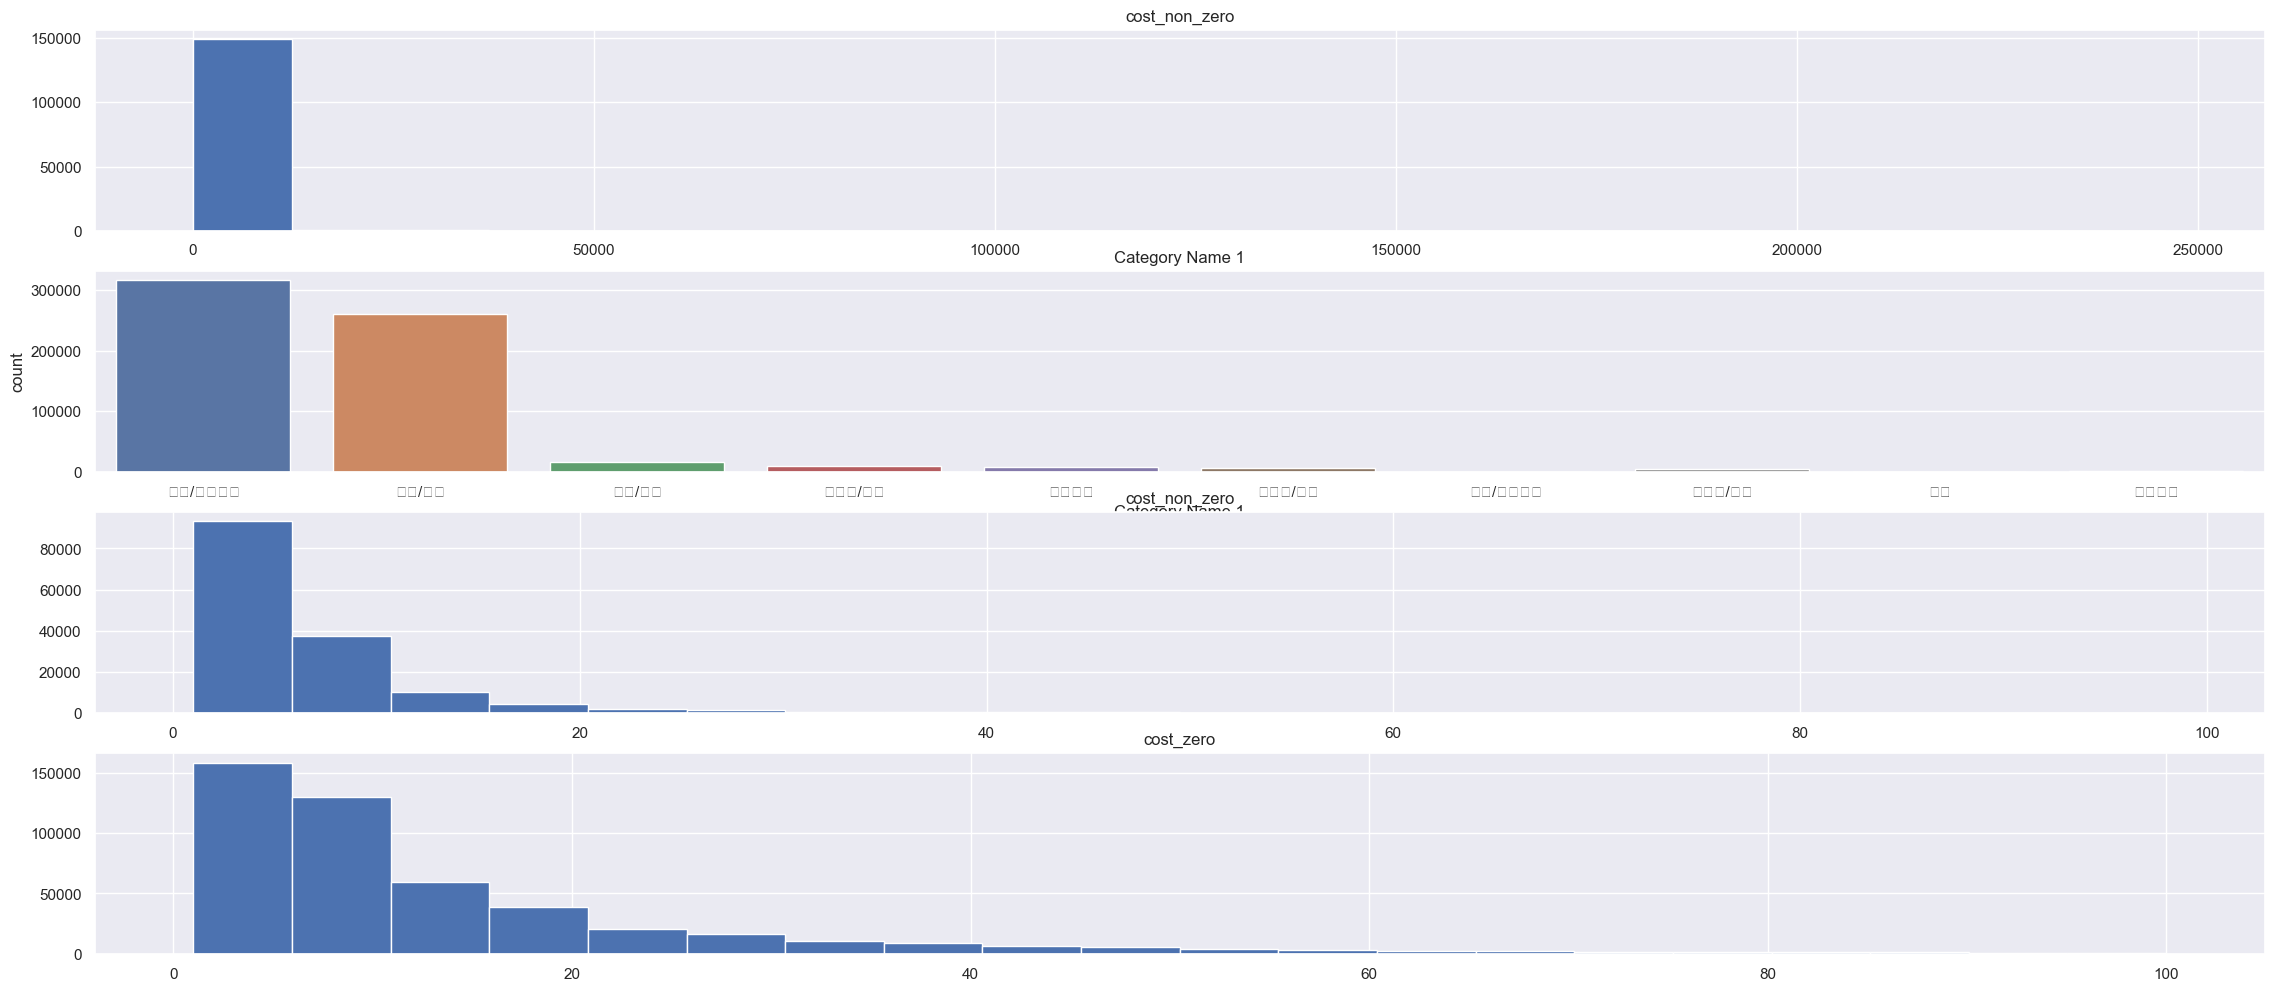

In [113]:
# 수치표현
# 그래프표현
# text = 5만원 이하 상품 가격 데이터 특징
price_Analysis(price_down_5)

비용평균
169.75988080378508
--------------------------------------------------


코스트 썼을때 평균 순위 : 6.468736928072028
코스트 안 썼을때 평균 순위 : 13.20863936834374
--------------------------------------------------


광고숫자비율
3.7204414601536326
--------------------------------------------------


배달비 없음 비율
72.29230700919132


배달비 있음 비율
27.70769299080867
--------------------------------------------------


코스트비율
0.0        0.752318
50.0       0.051270
100.0      0.017238
150.0      0.008792
200.0      0.006478
             ...   
9010.0     0.000005
7370.0     0.000005
10850.0    0.000005
86540.0    0.000005
17610.0    0.000005
Name: Cost, Length: 1053, dtype: float64
--------------------------------------------------


코스트


count     50203.000000
mean        685.393303
std        3481.783996
min          50.000000
25%          90.000000
50%         230.000000
75%         500.000000
max      325300.000000
Name: Cost, dtype: float64

--------------------------------------------------


카테고리1


가구/인테리어    0.803943
생활/건강      0.147180
출산/육아      0.022744
스포츠/레저     0.016912
화장품/미용     0.003602
디지털/가전     0.002309
여가/생활편의    0.001495
패션의류       0.000878
패션잡화       0.000671
식품         0.000266
Name: Category Name 1, dtype: float64

--------------------------------------------------


코스트 있음 , 순위


count    50203.000000
mean         6.468737
std          6.288642
min          1.000000
25%          3.000000
50%          5.000000
75%          8.000000
max         98.000000
Name: Sum of AD rank, dtype: float64

--------------------------------------------------


코스트 없음 , 순위


count    152488.000000
mean         13.208639
std          14.539568
min           1.000000
25%           4.000000
50%           8.000000
75%          16.000000
max         100.000000
Name: Sum of AD rank, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: 

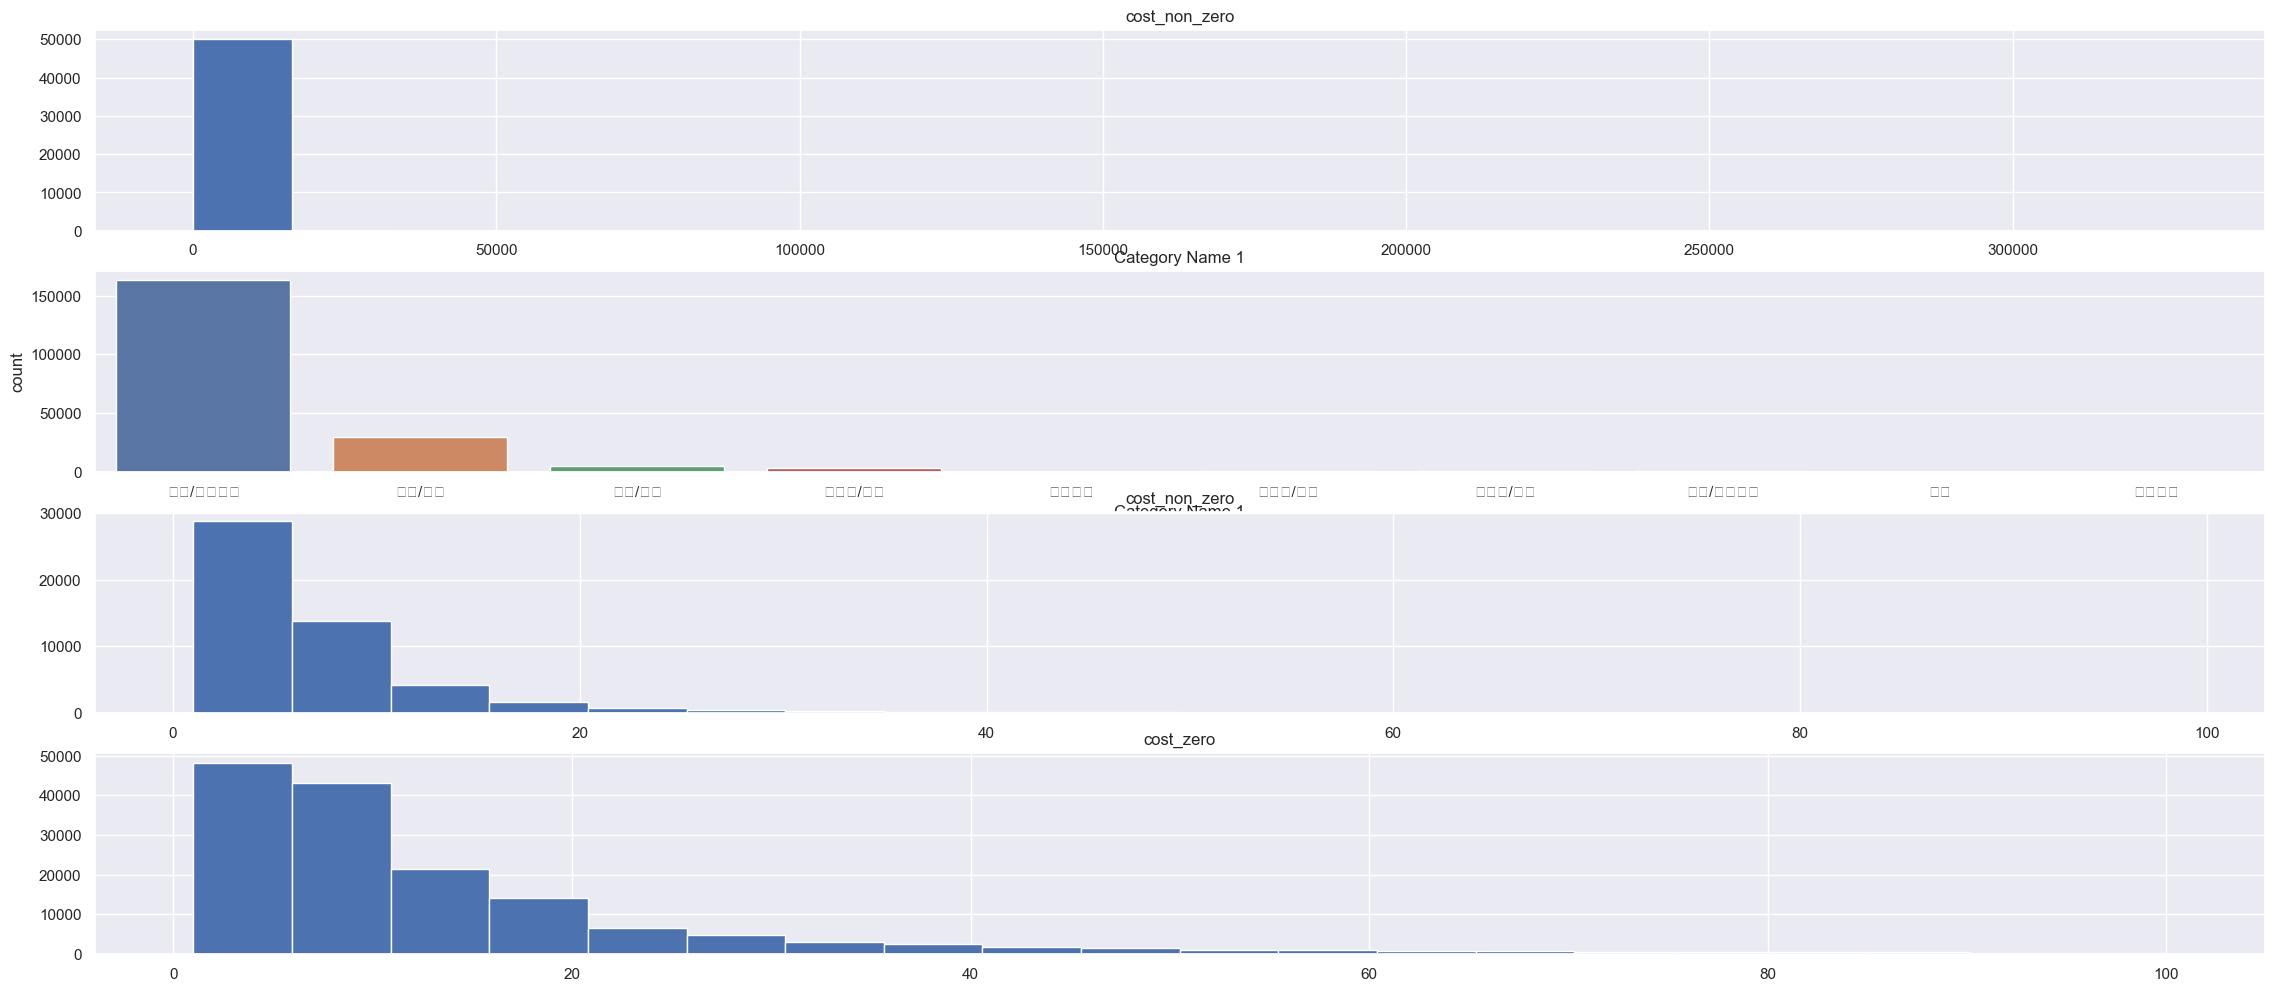

In [114]:
# 수치표현
# 그래프표현
# text = 5~10만원 상품 가격 데이터 특징
price_Analysis(price_5_10)

비용평균
176.7522275674545
--------------------------------------------------


코스트 썼을때 평균 순위 : 6.805257416335293
코스트 안 썼을때 평균 순위 : 13.58261623567634
--------------------------------------------------


광고숫자비율
3.8761765321062542
--------------------------------------------------


배달비 없음 비율
86.22798577703409


배달비 있음 비율
13.772014222965906
--------------------------------------------------


코스트비율
0.0        0.762251
50.0       0.042836
100.0      0.014097
150.0      0.007956
200.0      0.005806
             ...   
6180.0     0.000008
7770.0     0.000008
28530.0    0.000008
14250.0    0.000008
26380.0    0.000008
Name: Cost, Length: 855, dtype: float64
--------------------------------------------------


코스트


count     28417.000000
mean        743.439139
std        3118.644716
min          50.000000
25%         100.000000
50%         260.000000
75%         580.000000
max      185690.000000
Name: Cost, dtype: float64

--------------------------------------------------


카테고리1


가구/인테리어    0.886785
생활/건강      0.082041
출산/육아      0.013587
스포츠/레저     0.012039
디지털/가전     0.001824
여가/생활편의    0.001732
패션의류       0.001723
화장품/미용     0.000167
패션잡화       0.000100
Name: Category Name 1, dtype: float64

--------------------------------------------------


코스트 있음 , 순위


count    28417.000000
mean         6.805257
std          6.476787
min          1.000000
25%          3.000000
50%          5.000000
75%          8.000000
max         93.000000
Name: Sum of AD rank, dtype: float64

--------------------------------------------------


코스트 없음 , 순위


count    91108.000000
mean        13.582616
std         14.520047
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max        100.000000
Name: Sum of AD rank, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: 

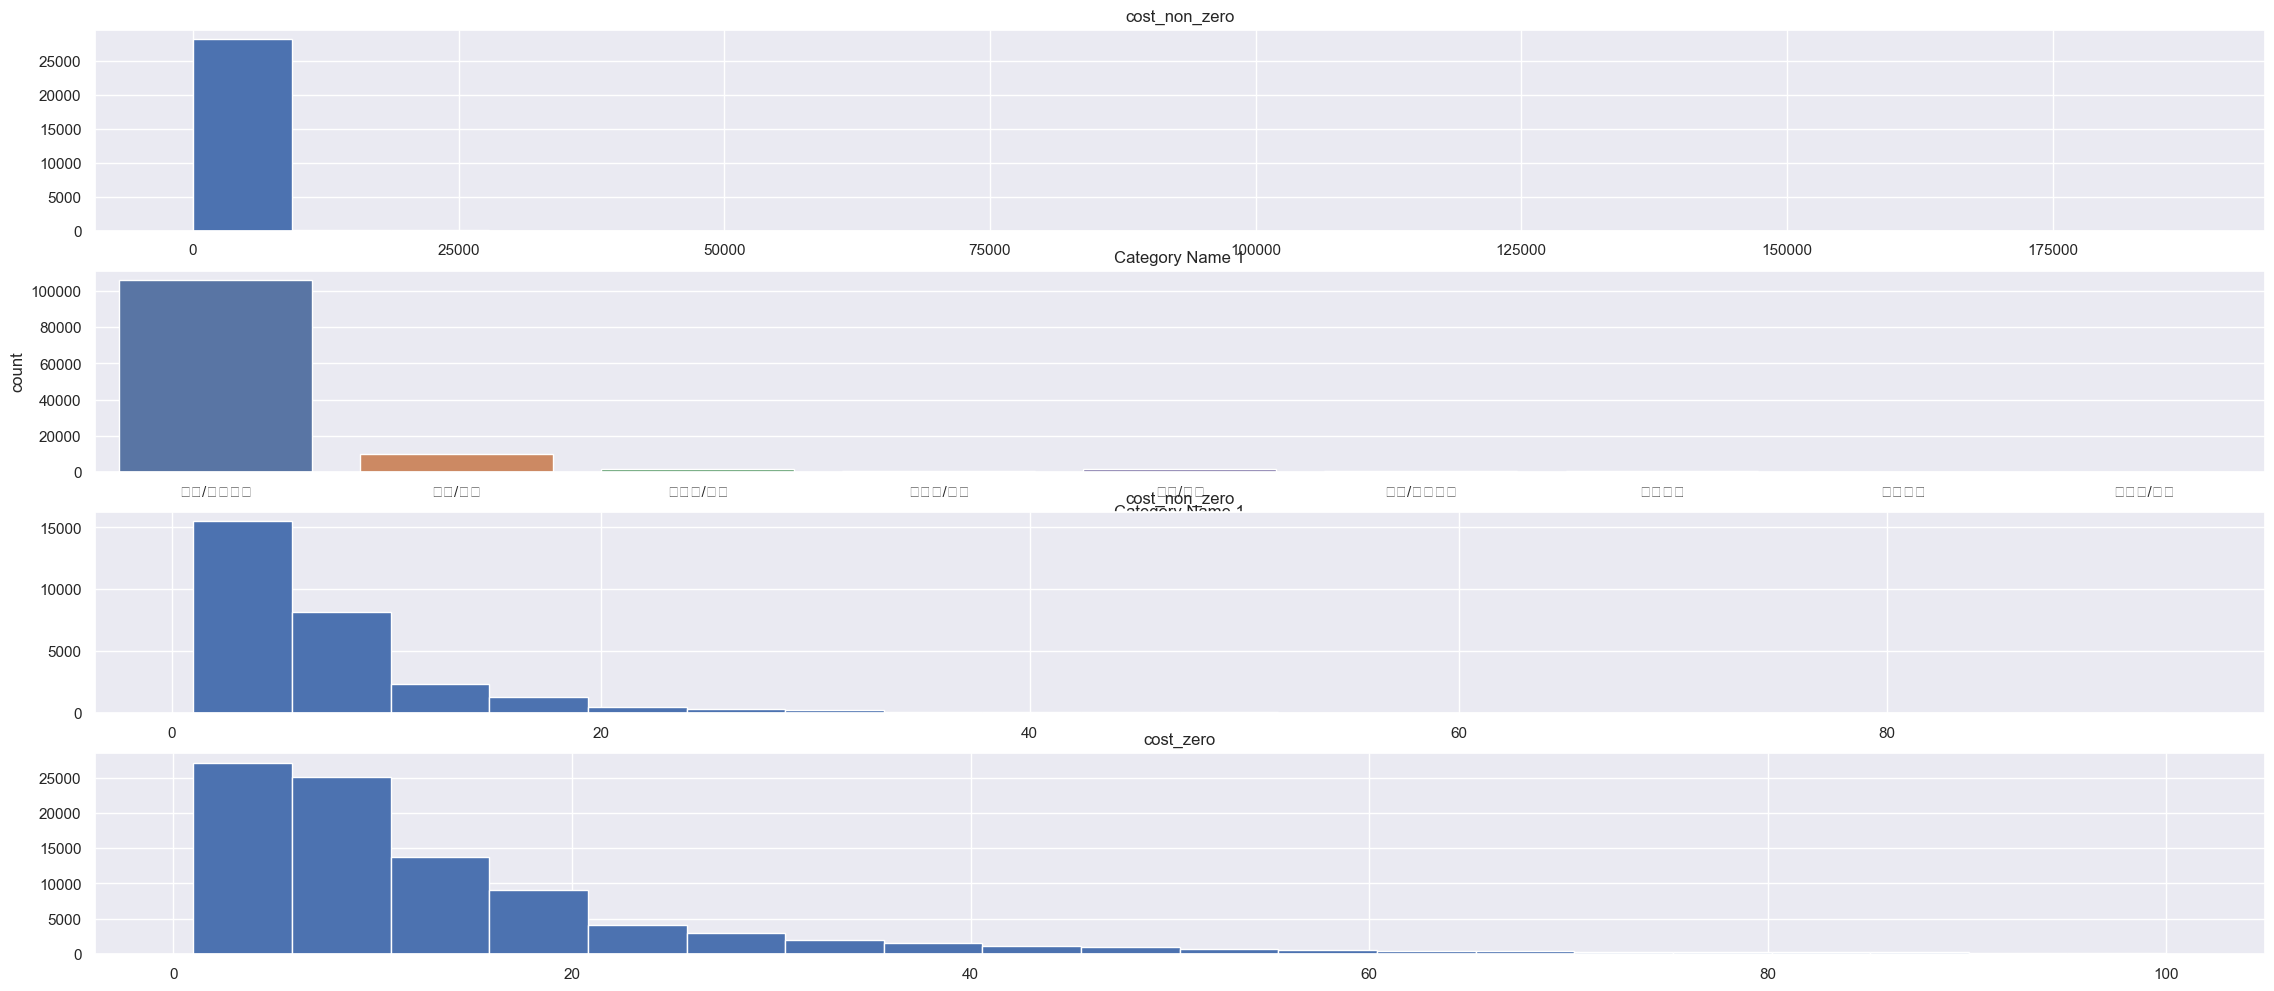

In [115]:
# 수치표현
# 그래프표현
# text = 10~15만원 상품 가격 데이터 특징
price_Analysis(price_10_15)

비용평균
203.27396972012716
--------------------------------------------------


코스트 썼을때 평균 순위 : 6.766107397808393
코스트 안 썼을때 평균 순위 : 13.122434039064101
--------------------------------------------------


광고숫자비율
3.8054734137400184
--------------------------------------------------


배달비 없음 비율
88.89368818597644


배달비 있음 비율
11.106311814023547
--------------------------------------------------


코스트비율
0.0         0.756421
50.0        0.045453
100.0       0.014210
150.0       0.007199
350.0       0.006490
              ...   
6950.0      0.000011
117480.0    0.000011
23020.0     0.000011
9760.0      0.000011
3110.0      0.000011
Name: Cost, Length: 754, dtype: float64
--------------------------------------------------


코스트


count     21993.000000
mean        834.529623
std        4027.003254
min          50.000000
25%         100.000000
50%         260.000000
75%         600.000000
max      191400.000000
Name: Cost, dtype: float64

--------------------------------------------------


카테고리1


가구/인테리어    0.931732
생활/건강      0.053505
출산/육아      0.007509
스포츠/레저     0.005117
여가/생활편의    0.000986
패션의류       0.000598
화장품/미용     0.000365
패션잡화       0.000144
디지털/가전     0.000044
Name: Category Name 1, dtype: float64

--------------------------------------------------


코스트 있음 , 순위


count    21993.000000
mean         6.766107
std          6.462560
min          1.000000
25%          3.000000
50%          5.000000
75%          8.000000
max        100.000000
Name: Sum of AD rank, dtype: float64

--------------------------------------------------


코스트 없음 , 순위


count    68298.000000
mean        13.122434
std         13.854315
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max        100.000000
Name: Sum of AD rank, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: 

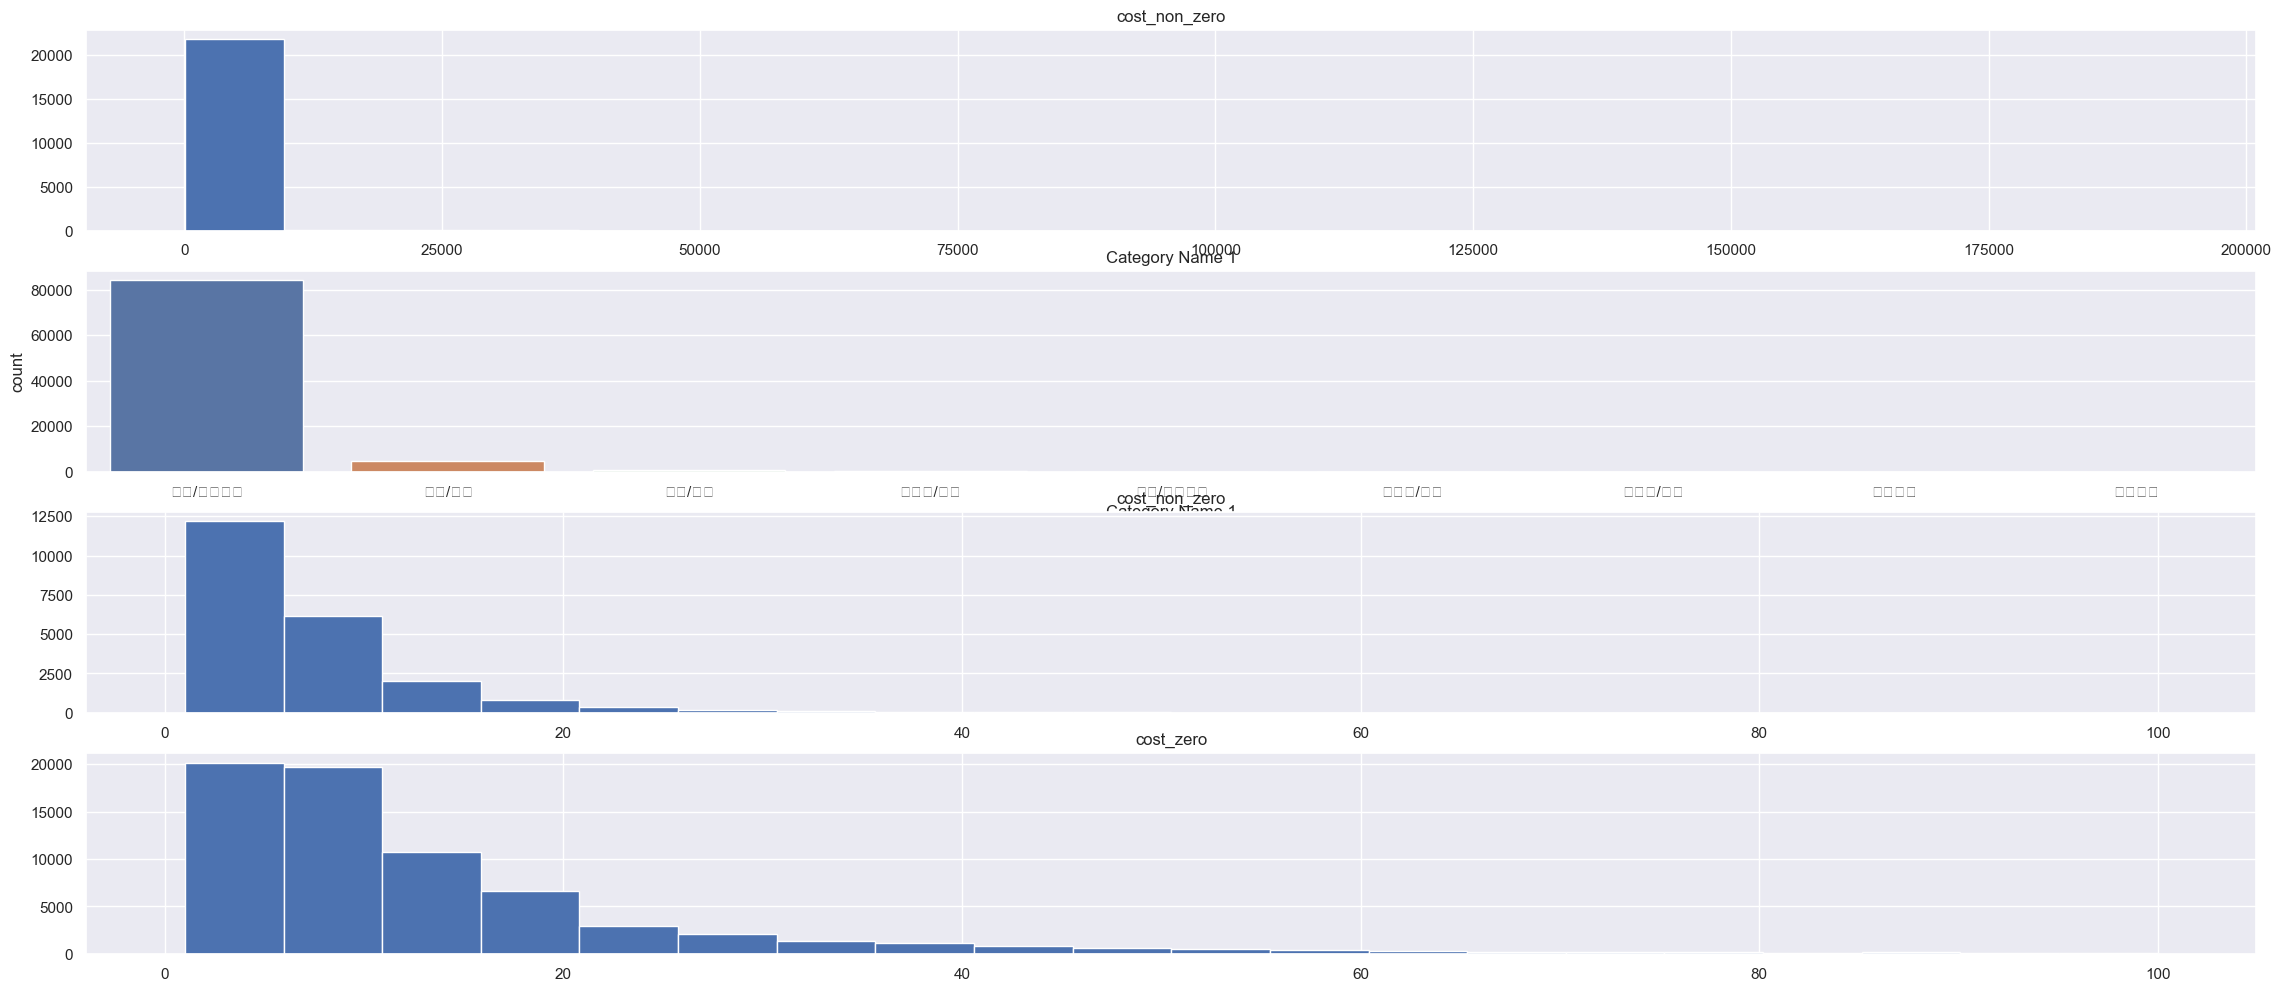

In [116]:
# 수치표현
# 그래프표현
# text = 15~20만원 상품 가격 데이터 특징
price_Analysis(price_15_20)

비용평균
210.78078991056972
--------------------------------------------------


코스트 썼을때 평균 순위 : 5.927594324616657
코스트 안 썼을때 평균 순위 : 11.778050682443254
--------------------------------------------------


광고숫자비율
3.5259716747169865
--------------------------------------------------


배달비 없음 비율
94.15526299608528


배달비 있음 비율
5.84473700391471
--------------------------------------------------


코스트비율
0.0        0.731555
50.0       0.049074
100.0      0.017521
150.0      0.009432
250.0      0.007051
             ...   
27480.0    0.000003
17020.0    0.000003
14300.0    0.000003
13070.0    0.000003
15800.0    0.000003
Name: Cost, Length: 1293, dtype: float64
--------------------------------------------------


코스트


count     78585.000000
mean        785.192976
std        3459.069587
min          50.000000
25%         100.000000
50%         260.000000
75%         600.000000
max      259530.000000
Name: Cost, dtype: float64

--------------------------------------------------


카테고리1


가구/인테리어    0.966342
생활/건강      0.022672
출산/육아      0.005869
스포츠/레저     0.004068
디지털/가전     0.000506
화장품/미용     0.000362
패션잡화       0.000157
여가/생활편의    0.000024
Name: Category Name 1, dtype: float64

--------------------------------------------------


코스트 있음 , 순위


count    78585.000000
mean         5.927594
std          5.286060
min          1.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         90.000000
Name: Sum of AD rank, dtype: float64

--------------------------------------------------


코스트 없음 , 순위


count    214157.000000
mean         11.778051
std          12.014084
min           1.000000
25%           5.000000
50%           8.000000
75%          14.000000
max         100.000000
Name: Sum of AD rank, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: 

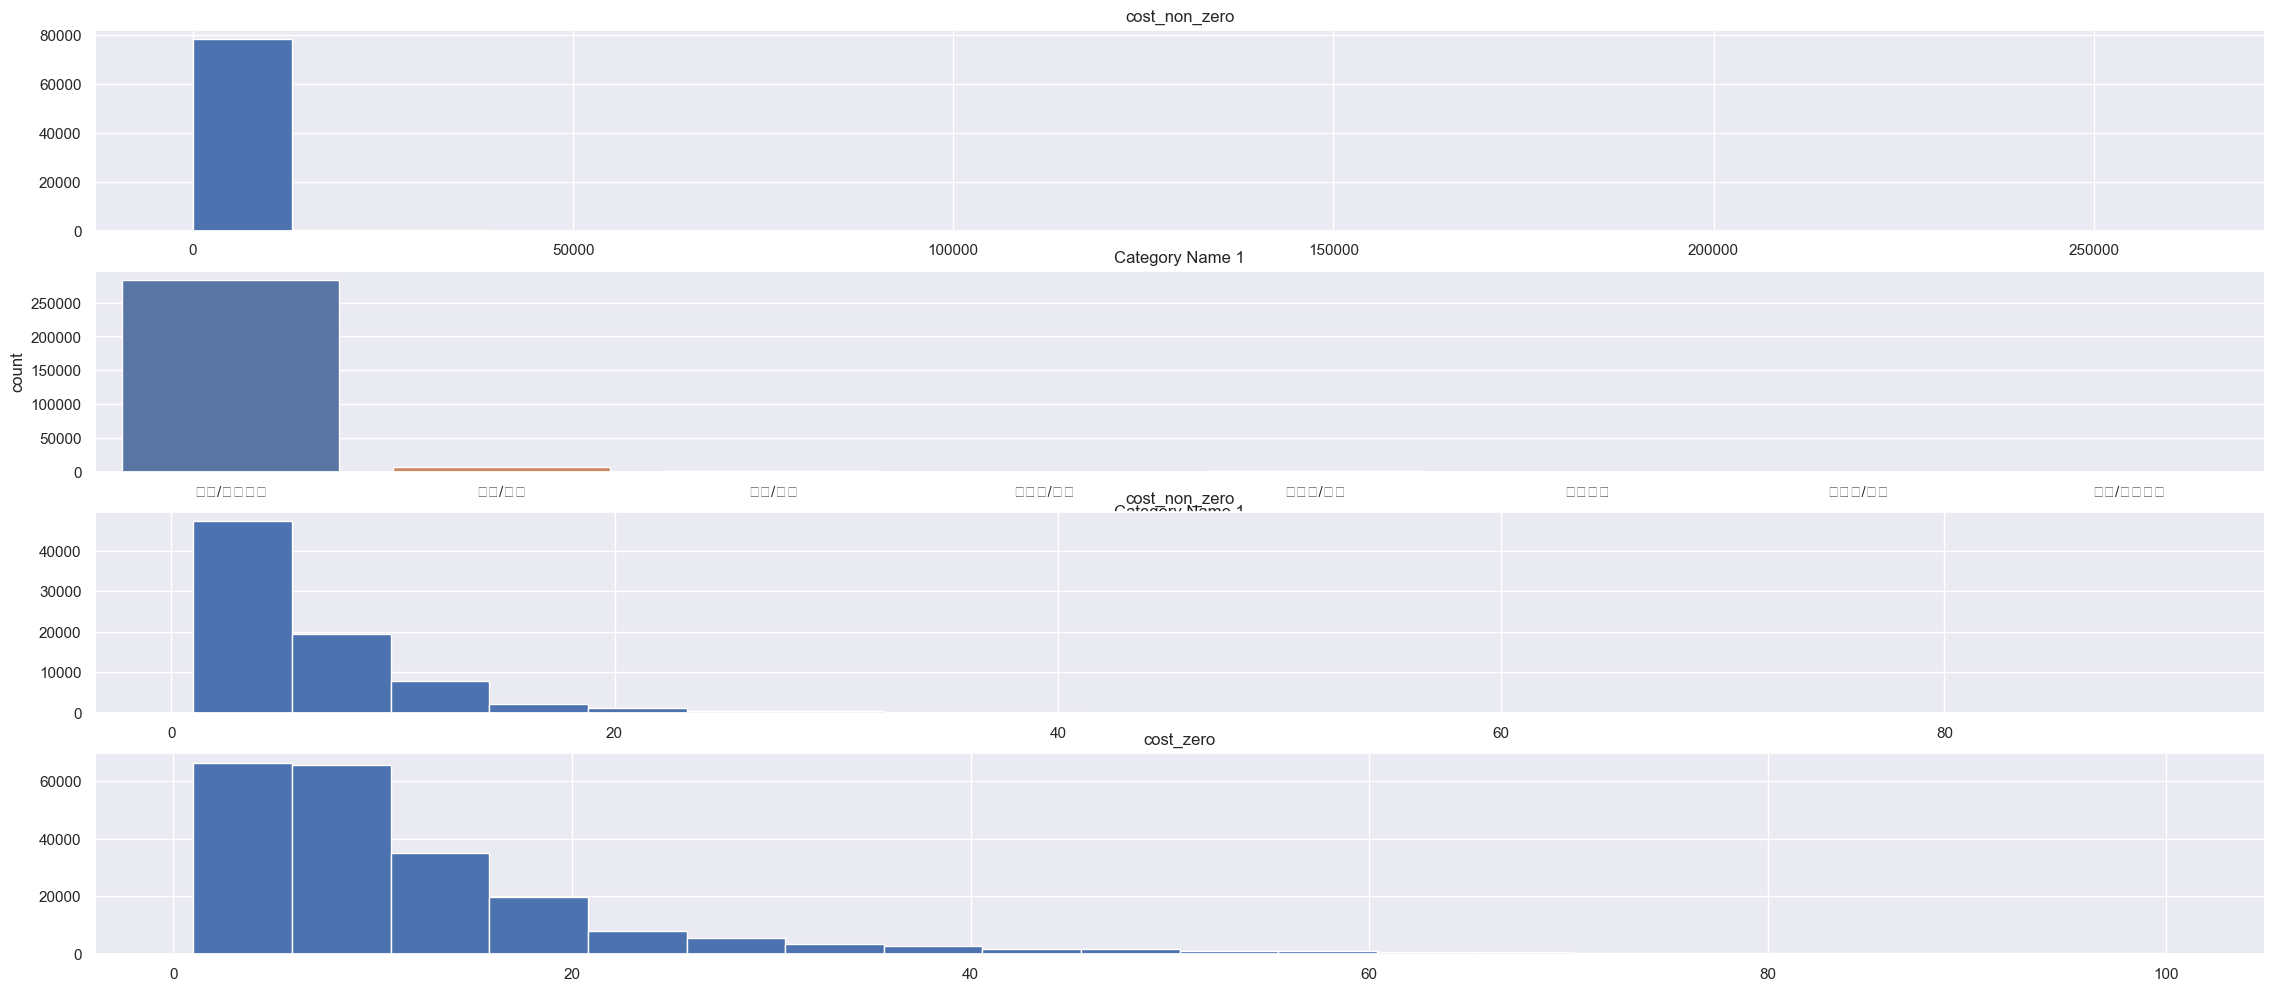

In [117]:
# 수치표현
# 그래프표현
# text = 20만원 이상 상품 가격 데이터 특징
price_Analysis(price_up_20)

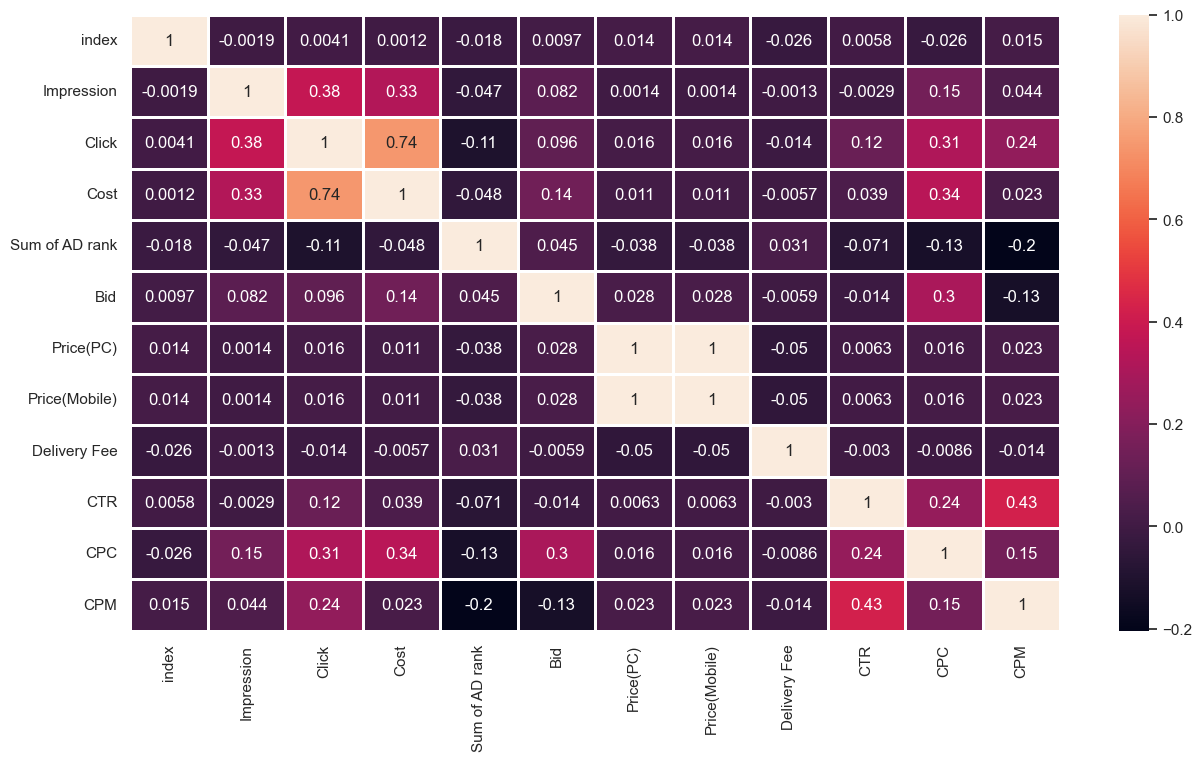

In [118]:
# 그래프 표현
# text = 5만원 이하 상품 가격 데이터 상관관계
corr_heat(price_down_5)

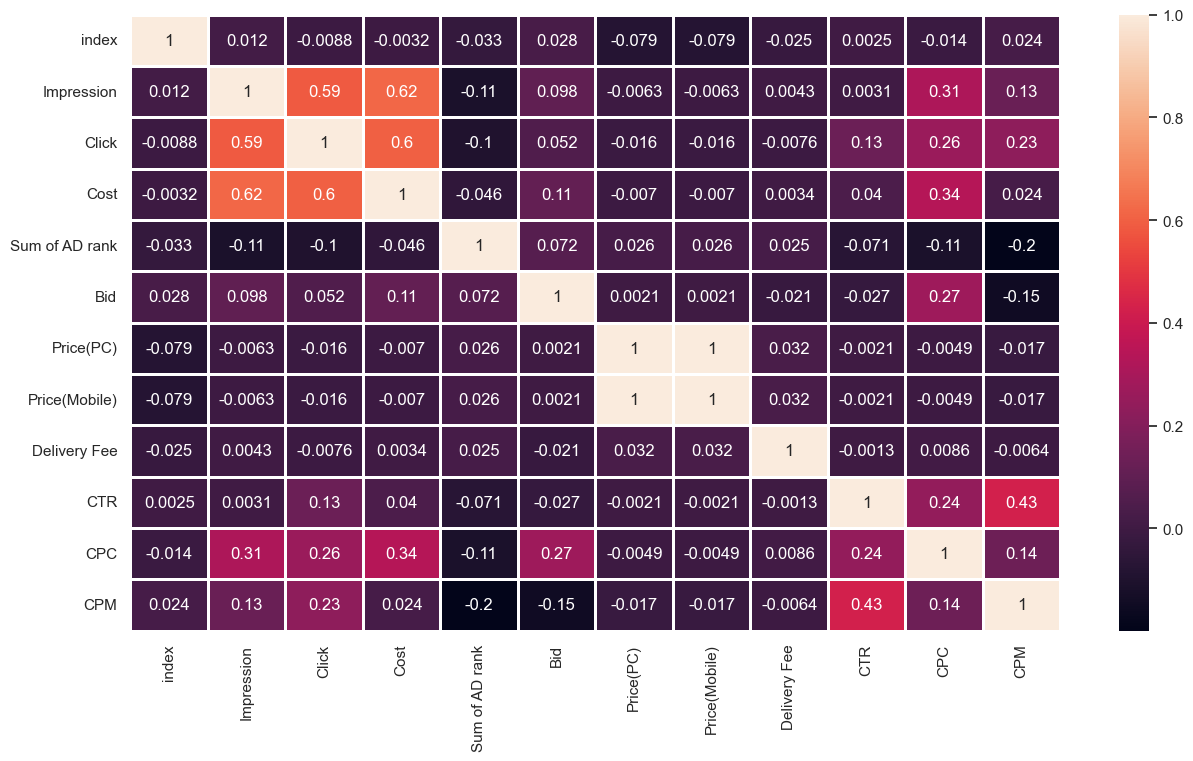

In [119]:
# 그래프 표현
# text = 5~10만원 상품 가격 데이터 상관관계
corr_heat(price_5_10)

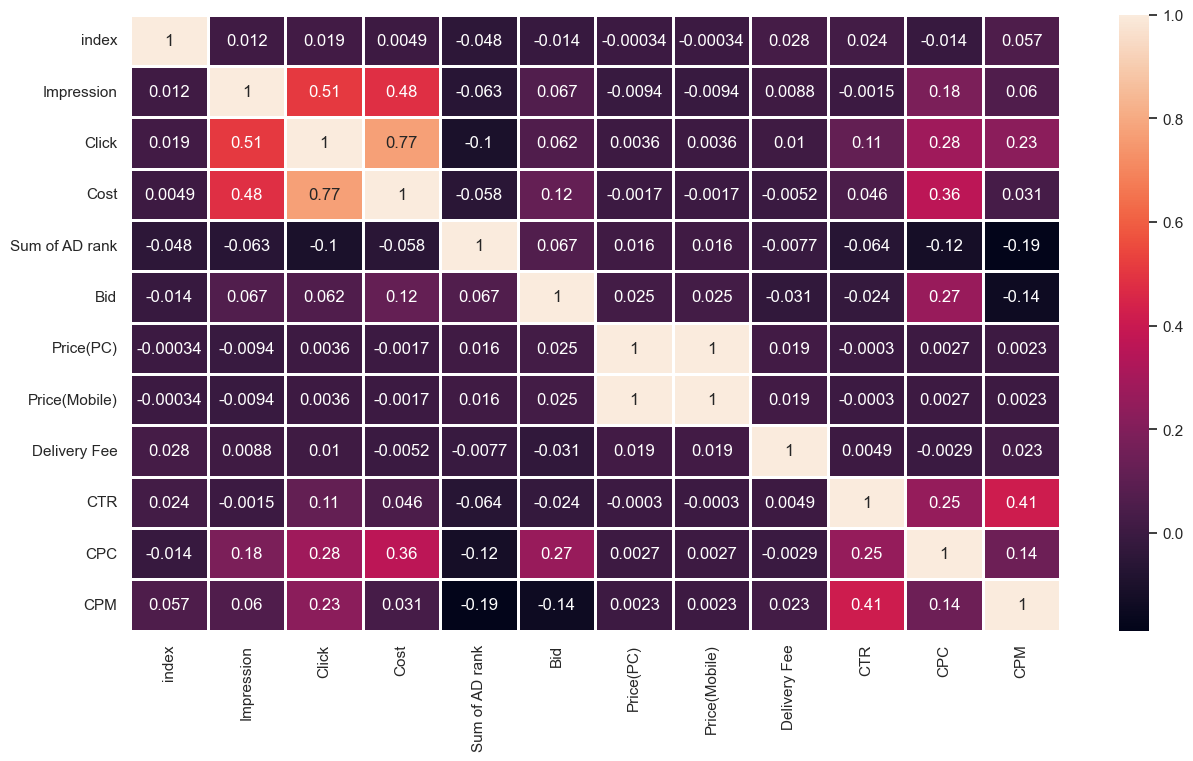

In [120]:
# 그래프 표현
# text = 10~15만원 상품 가격 데이터 상관관계
corr_heat(price_10_15)

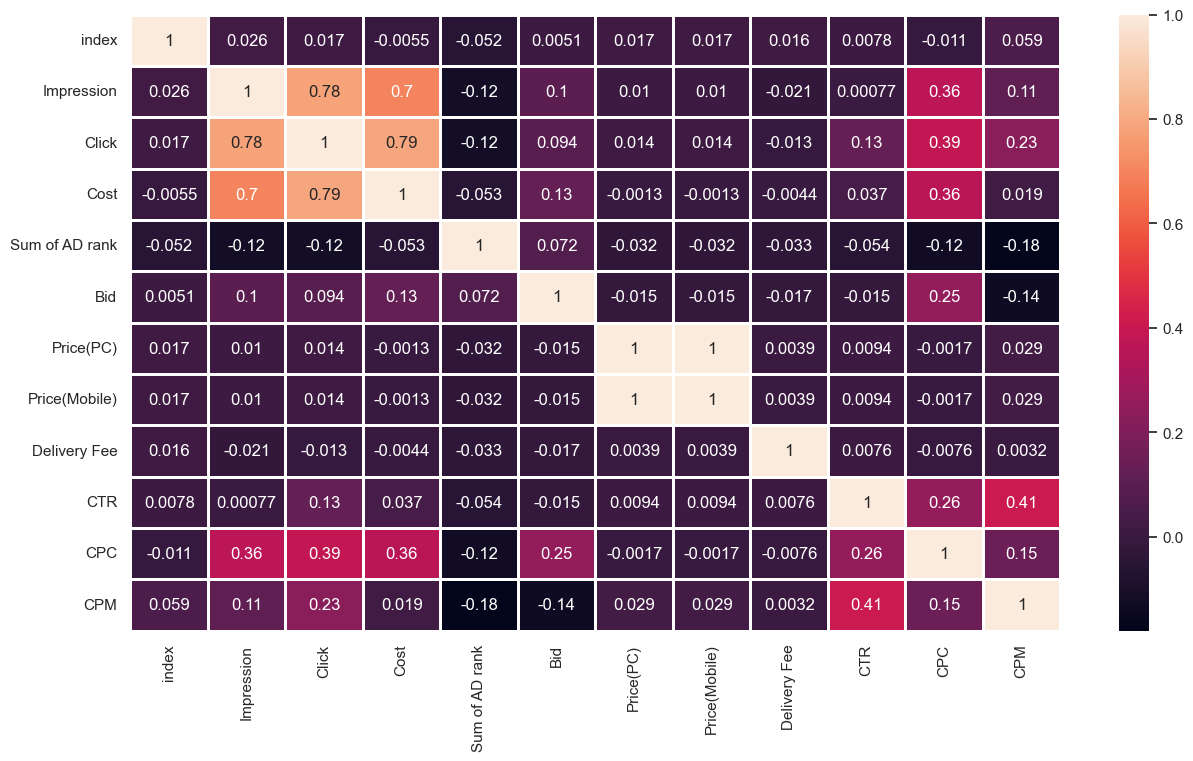

In [121]:
# 그래프 표현
# text = 15~20만원 상품 가격 데이터 상관관계
corr_heat(price_15_20)

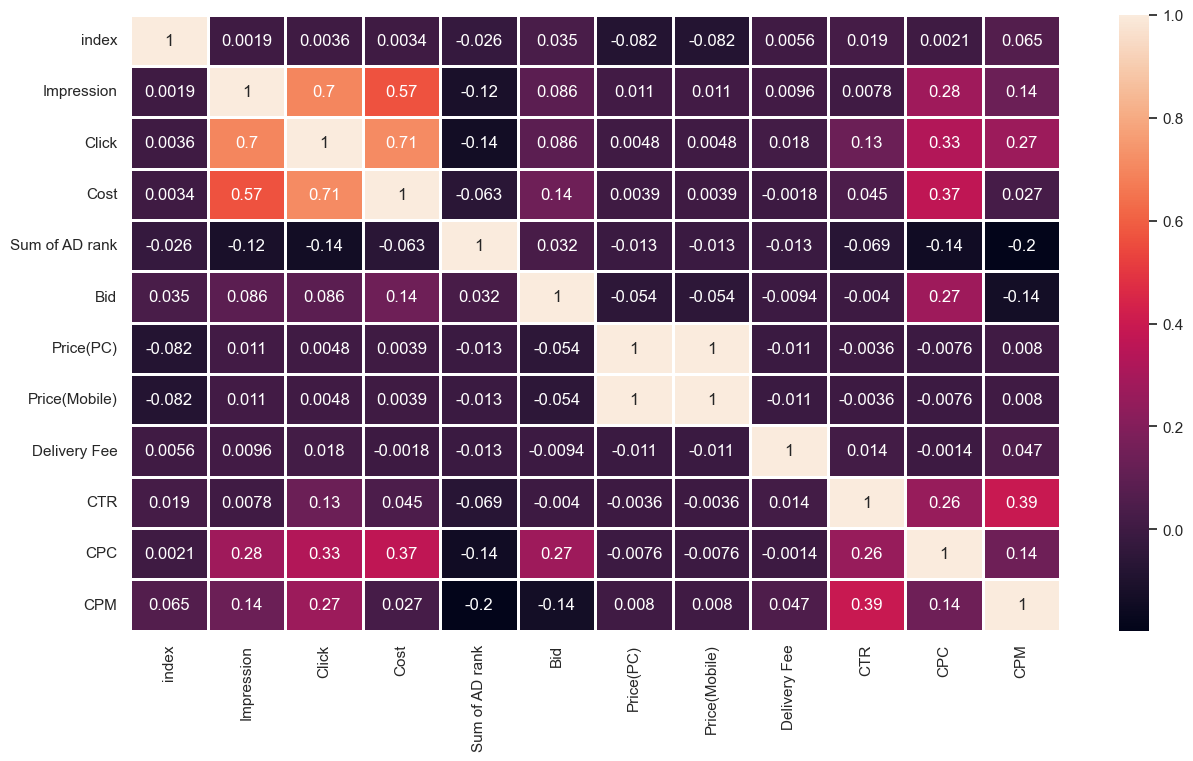

In [122]:
# 그래프 표현
# text = 20만원 이상 상품 가격 데이터 상관관계
corr_heat(price_up_20)

## Rank 구간별 분석
#결론 : 상식적인 결과의 연속, 특이점은 상품가격이 1등에 가까울수록 높아진다

In [123]:
#수치표현
# text = Rank 구간별 광고 비율
print("rank_down_26 광고숫자비율")
print((len(list(set(rank_down_26['index'].values)))))
print('-' * 50)
print("rank_26_46 광고숫자비율")
print((len(list(set(rank_26_46['index'].values)))))
print('-' * 50)
print("rank_46_66 광고숫자비율")
print((len(list(set(rank_46_66['index'].values)))))
print('-' * 50)
print("rank_66_86 광고숫자비율")
print((len(list(set(rank_66_86['index'].values)))))
print('-' * 50)
print("rank_up_86 광고숫자비율")
print((len(list(set(rank_up_86['index'].values)))))
print('-' * 50)

rank_down_26 광고숫자비율
47905
--------------------------------------------------
rank_26_46 광고숫자비율
19688
--------------------------------------------------
rank_46_66 광고숫자비율
10222
--------------------------------------------------
rank_66_86 광고숫자비율
5448
--------------------------------------------------
rank_up_86 광고숫자비율
3180
--------------------------------------------------


In [124]:
#수치표현
# text = Rank 구간별 Click 평균
print('rank_down_26')
print(rank_down_26['Click'].mean())
print('-' * 50)
print(rank_down_26['Click'].value_counts(normalize=True))
print('-' * 50)
print('rank_26_46')
print(rank_26_46['Click'].mean())
print('-' * 50)
print(rank_26_46['Click'].value_counts(normalize=True))
print('-' * 50)
print('rank_46_66')
print(rank_46_66['Click'].mean())
print('-' * 50)
print(rank_46_66['Click'].value_counts(normalize=True))
print('-' * 50)
print('rank_66_86')
print(rank_66_86['Click'].mean())
print('-' * 50)
print(rank_66_86['Click'].value_counts(normalize=True))
print('-' * 50)
print('rank_up_86')
print(rank_up_86['Click'].mean())
print('-' * 50)
print(rank_up_86['Click'].value_counts(normalize=True))
print('-' * 50)

rank_down_26
0.790540585286385
--------------------------------------------------
0      7.315716e-01
1      1.452935e-01
2      5.034917e-02
3      2.366592e-02
4      1.332921e-02
           ...     
195    8.277981e-07
240    8.277981e-07
257    8.277981e-07
177    8.277981e-07
455    8.277981e-07
Name: Click, Length: 189, dtype: float64
--------------------------------------------------
rank_26_46
0.06485917961902536
--------------------------------------------------
0    0.943139
1    0.050888
2    0.004532
3    0.001039
4    0.000247
5    0.000130
6    0.000026
Name: Click, dtype: float64
--------------------------------------------------
rank_46_66
0.02757614164458271
--------------------------------------------------
0    0.973653
1    0.025195
2    0.001075
3    0.000077
Name: Click, dtype: float64
--------------------------------------------------
rank_66_86
0.009230488027782854
--------------------------------------------------
0    0.99077
1    0.00923
Name: Click, dtype: f

In [125]:
#수치표현
# text = Rank 구간별 Cost 평균
print('rank_down_26')
print(rank_down_26['Cost'].mean())
print('-' * 50)
print(rank_down_26['Cost'].value_counts(normalize=True))
print('-' * 50)
print('rank_26_46')
print(rank_26_46['Cost'].mean())
print('-' * 50)
print(rank_26_46['Cost'].value_counts(normalize=True))
print('-' * 50)
print('rank_46_66')
print(rank_46_66['Cost'].mean())
print('-' * 50)
print(rank_46_66['Cost'].value_counts(normalize=True))
print('-' * 50)
print('rank_66_86')
print(rank_66_86['Cost'].mean())
print('-' * 50)
print(rank_66_86['Cost'].value_counts(normalize=True))
print('-' * 50)
print('rank_up_86')
print(rank_up_86['Cost'].mean())
print('-' * 50)
print(rank_up_86['Cost'].value_counts(normalize=True))
print('-' * 50)

rank_down_26
197.78499433786084
--------------------------------------------------
0.0        7.315716e-01
50.0       5.392856e-02
100.0      1.859731e-02
150.0      9.850798e-03
200.0      7.199360e-03
               ...     
26190.0    8.277981e-07
42270.0    8.277981e-07
10720.0    8.277981e-07
46930.0    8.277981e-07
10160.0    8.277981e-07
Name: Cost, Length: 2406, dtype: float64
--------------------------------------------------
rank_26_46
18.740212691363794
--------------------------------------------------
0.0       0.943139
50.0      0.008414
350.0     0.002987
250.0     0.001883
180.0     0.001766
            ...   
3040.0    0.000013
1470.0    0.000013
2280.0    0.000013
2030.0    0.000013
1890.0    0.000013
Name: Cost, Length: 163, dtype: float64
--------------------------------------------------
rank_46_66
7.31459077466682
--------------------------------------------------
0.0      0.973653
50.0     0.004033
350.0    0.001805
250.0    0.001421
210.0    0.001229
           

In [126]:
#수치표현
# text = Rank 구간별 Impression 평균
print('rank_down_26')
print(rank_down_26['Impression'].mean())
print('-' * 50)
print(rank_down_26['Impression'].value_counts(normalize=True))
print('-' * 50)
print('rank_26_46')
print(rank_26_46['Impression'].mean())
print('-' * 50)
print(rank_26_46['Impression'].value_counts(normalize=True))
print('-' * 50)
print('rank_46_66')
print(rank_46_66['Impression'].mean())
print('-' * 50)
print(rank_46_66['Impression'].value_counts(normalize=True))
print('-' * 50)
print('rank_66_86')
print(rank_66_86['Impression'].mean())
print('-' * 50)
print(rank_66_86['Impression'].value_counts(normalize=True))
print('-' * 50)
print('rank_up_86')
print(rank_up_86['Impression'].mean())
print('-' * 50)
print(rank_up_86['Impression'].value_counts(normalize=True))
print('-' * 50)

rank_down_26
48.3159283259273
--------------------------------------------------
1       9.384416e-02
2       7.156646e-02
3       5.861639e-02
4       4.985414e-02
5       4.313490e-02
            ...     
2211    8.277981e-07
3981    8.277981e-07
2767    8.277981e-07
1163    8.277981e-07
1590    8.277981e-07
Name: Impression, Length: 2732, dtype: float64
--------------------------------------------------
rank_26_46
5.943671847610144
--------------------------------------------------
1      0.214198
2      0.188682
3      0.145261
4      0.095815
5      0.072910
         ...   
120    0.000013
172    0.000013
187    0.000013
236    0.000013
162    0.000013
Name: Impression, Length: 204, dtype: float64
--------------------------------------------------
rank_46_66
3.1726005300149787
--------------------------------------------------
1      0.405615
2      0.245996
3      0.125975
4      0.074778
5      0.044206
         ...   
131    0.000038
98     0.000038
107    0.000038
85     0.000

In [127]:
# 수치표현
# text = Rank 구간별 Price(PC) 중간값
print('rank_down_26')
print(rank_down_26['Price(PC)'].median())
print('-' * 50)
print(rank_down_26['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('rank_26_46')
print(rank_26_46['Price(PC)'].median())
print('-' * 50)
print(rank_26_46['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('rank_46_66')
print(rank_46_66['Price(PC)'].median())
print('-' * 50)
print(rank_46_66['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('rank_66_86')
print(rank_66_86['Price(PC)'].median())
print('-' * 50)
print(rank_66_86['Price(PC)'].value_counts(normalize=True))
print('-' * 50)
print('rank_up_86')
print(rank_up_86['Price(PC)'].median())
print('-' * 50)
print(rank_up_86['Price(PC)'].value_counts(normalize=True))
print('-' * 50)

rank_down_26
59900.0
--------------------------------------------------
9900       1.186069e-02
19900      1.045757e-02
29900      8.902969e-03
12900      8.641385e-03
14900      8.610756e-03
               ...     
1156200    8.277981e-07
1330040    8.277981e-07
1548980    8.277981e-07
1578500    8.277981e-07
2550       8.277981e-07
Name: Price(PC), Length: 7447, dtype: float64
--------------------------------------------------
rank_26_46
45890.0
--------------------------------------------------
9900       0.012037
19900      0.010232
8900       0.009855
7900       0.009037
29900      0.008973
             ...   
1107000    0.000013
3076000    0.000013
47560      0.000013
1376000    0.000013
9000000    0.000013
Name: Price(PC), Length: 3019, dtype: float64
--------------------------------------------------
rank_46_66
39500.0
--------------------------------------------------
19900      0.011599
7900       0.010946
9900       0.010946
4900       0.010639
8900       0.010331
          

## 카테고리별 특징
#결론 : 시계열 모델을 돌려보니 트랜드가 점차 낮아지는 특징을 발견하여 월별 NDCG를 적용
        돌려보니 점점 좋아지는 카테고리가 보임, 서브 카테고리로써 좋은 시도를 해본다면 시너지가 나오지 않을까?
        
#특이점 : 식품은 광고가 없어서 0, 주석처리한건 0값이 뜬다, 1월은 595개 밖에 없어서 생략, ccc는 임의로 먹인 이름

00:01:47 - cmdstanpy - INFO - Chain [1] start processing
00:01:47 - cmdstanpy - INFO - Chain [1] done processing


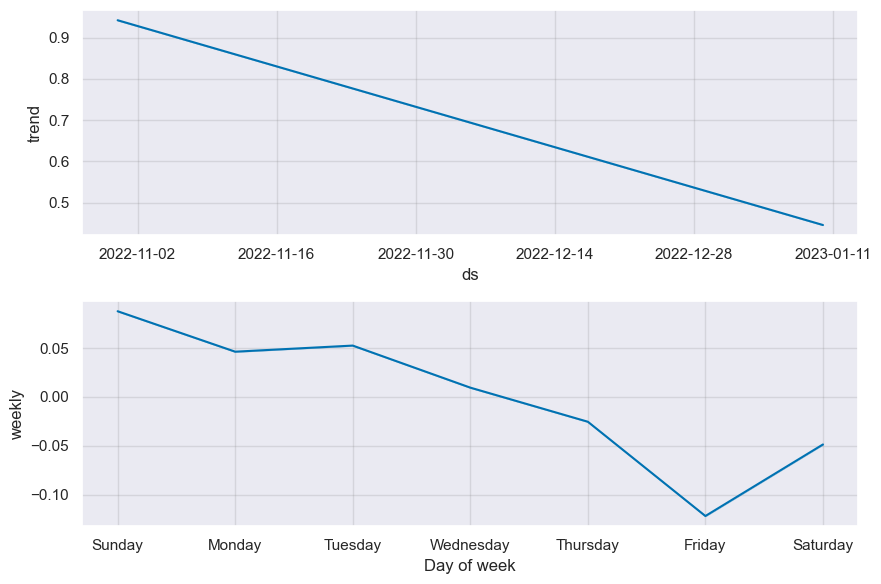

In [128]:
# 수치표현
# text = 시계열 모델로 Click 특징찾기

prophet = Prophet()
prophet.fit(bid_click_mean)


# create a future data frame 
future = prophet.make_future_dataframe(periods=7, freq = 'D')
forecast = prophet.predict(future)

fig2 = prophet.plot_components(forecast)
plt.show()

00:01:48 - cmdstanpy - INFO - Chain [1] start processing
00:01:48 - cmdstanpy - INFO - Chain [1] done processing


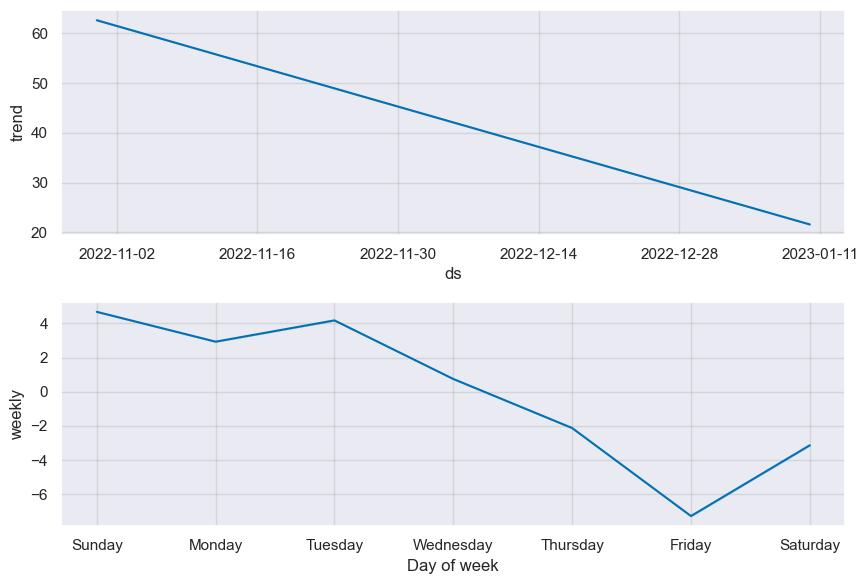

In [129]:
# 수치표현
# text = 시계열 모델로 Impression 특징찾기

prophet = Prophet()
prophet.fit(bid_imp_mean)


# create a future data frame 
future = prophet.make_future_dataframe(periods=7, freq = 'D')
forecast = prophet.predict(future)

fig2 = prophet.plot_components(forecast)
plt.show()

00:01:49 - cmdstanpy - INFO - Chain [1] start processing
00:01:49 - cmdstanpy - INFO - Chain [1] done processing


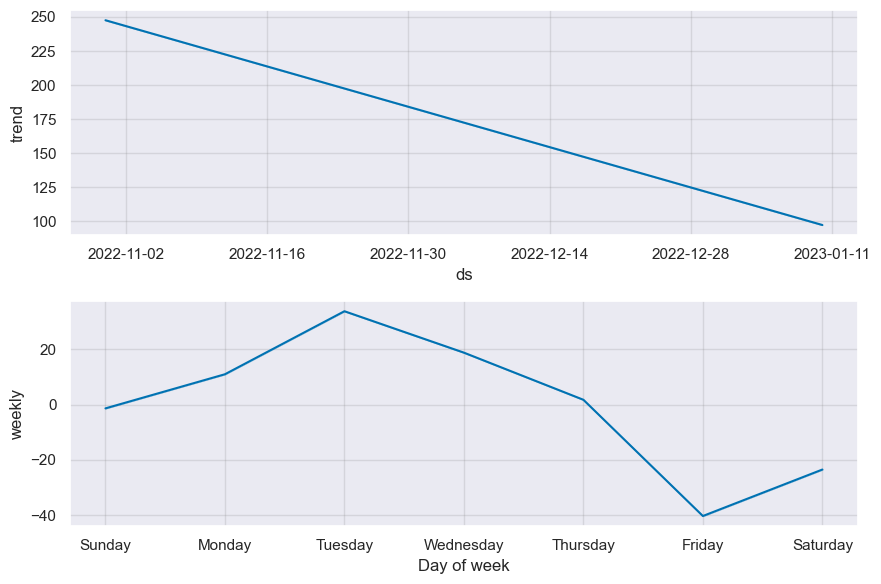

In [130]:
# 수치표현
# text = 시계열 모델로 Cost 특징찾기

prophet = Prophet()
prophet.fit(bid_cost_mean)


# create a future data frame 
future = prophet.make_future_dataframe(periods=7, freq = 'D')
forecast = prophet.predict(future)

fig2 = prophet.plot_components(forecast)
plt.show()

In [131]:
# 수치표현
# 그래프표현
# text = 월별 NDCG 평가
print(f'10월 Total [Click] : {(month_10["Click"].mean())}')
print(f'11월 Total [Click] : {(month_11["Click"].mean())}')
print(f'12월 Total [Click] : {(month_12["Click"].mean())}')
# print(f'1월 Total [Click] : {(month_1["Click"].mean())}')

print('-'*50)

print(f'10월 Total [Cost] : {(month_10["Cost"].mean())}')
print(f'11월 Total [Cost] : {(month_11["Cost"].mean())}')
print(f'12월 Total [Cost] : {(month_12["Cost"].mean())}')
# print(f'1월 Total [Cost] : {(month_1["Cost"].mean())}')

print('-'*50)

print(f'10월 Total [Impression] : {(month_10["Impression"].mean())}')
print(f'11월 Total [Impression] : {(month_11["Impression"].mean())}')
print(f'12월 Total [Impression] : {(month_12["Impression"].mean())}')
# print(f'1월 Total [Impression] : {(month_1["Impression"].mean())}')

print('-'*50)

print(f'10월 Total [Sum of AD rank] : {(month_10["Sum of AD rank"].mean())}')
print(f'11월 Total [Sum of AD rank] : {(month_11["Sum of AD rank"].mean())}')
print(f'12월 Total [Sum of AD rank] : {(month_12["Sum of AD rank"].mean())}')
# print(f'1월 Total [Sum of AD rank] : {(month_1["Sum of AD rank"].mean())}')

print('-'*50)


print(f'10월 Total [CCC] : {(month_10["Click"].mean()) / (month_10["Cost"].mean())}')
print(f'11월 Total [CCC] : {(month_11["Click"].mean()) / (month_11["Cost"].mean())}')
print(f'12월 Total [CCC] : {(month_12["Click"].mean()) / (month_12["Cost"].mean())}')

10월 Total [Click] : 0.9498353373669296
11월 Total [Click] : 0.3595666719770591
12월 Total [Click] : 0.729179518815546
--------------------------------------------------
10월 Total [Cost] : 274.3677720762809
11월 Total [Cost] : 121.8169507726621
12월 Total [Cost] : 176.8260333127699
--------------------------------------------------
10월 Total [Impression] : 58.62770927471854
11월 Total [Impression] : 21.81288832244703
12월 Total [Impression] : 36.404894098293234
--------------------------------------------------
10월 Total [Sum of AD rank] : 9.9383472466876
11월 Total [Sum of AD rank] : 12.952166640114704
12월 Total [Sum of AD rank] : 13.345979847830558
--------------------------------------------------
10월 Total [CCC] : 0.0034619056392047832
11월 Total [CCC] : 0.002951696538916752
12월 Total [CCC] : 0.004123711340206186


In [132]:
# # 수치표현
# # 그래프표현
# # text = 월별 패션의류
# print(f'식품 10월 [Click] = {cat_val_1_10["Click"].mean()}')
# print(f'식품 11월 [Click] = {cat_val_1_11["Click"].mean()}')
# print(f'식품 12월 [Click] = {cat_val_1_12["Click"].mean()}')
# print(f'식품 1월 [Click] = {cat_val_1_1["Click"].mean()}')

# print('-'*50)

# print(f'식품 10월 [Cost] = {cat_val_1_10["Cost"].mean()}')
# print(f'식품 11월 [Cost ] = {cat_val_1_11["Cost"].mean()}')
# print(f'식품 12월 [Cost] = {cat_val_1_12["Cost"].mean()}')
# print(f'식품 1월 [Cost] = {cat_val_1_1["Cost"].mean()}')

# print('-'*50)

# print(f'식품 10월 [Impression] = {cat_val_1_10["Impression"].mean()}')
# print(f'식품 11월 [Impression] = {cat_val_1_11["Impression"].mean()}')
# print(f'식품 12월 [Impression] = {cat_val_1_12["Impression"].mean()}')
# print(f'식품 1월 [Impression] = {cat_val_1_1["Impression"].mean()}')

# print('-'*50)

# print(f'식품 10월 [Sum of AD rank] = {cat_val_1_10["Sum of AD rank"].mean()}')
# print(f'식품 11월 [Sum of AD rank] = {cat_val_1_11["Sum of AD rank"].mean()}')
# print(f'식품 12월 [Sum of AD rank] = {cat_val_1_12["Sum of AD rank"].mean()}')
# print(f'식품 1월 [Sum of AD rank] = {cat_val_1_1["Sum of AD rank"].mean()}')

# print('-'*50)

# print(f'10월 식품 [CCC] : {(cat_val_1_10["Click"].mean()) / (cat_val_1_10["Cost"].mean())}')
# print(f'12월 식품 [CCC] : {(cat_val_1_11["Click"].mean()) / (cat_val_1_11["Cost"].mean())}')
# print(f'12월 식품 [CCC] : {(cat_val_1_12["Click"].mean()) / (cat_val_1_12["Cost"].mean())}')

In [133]:
# 수치표현
# 그래프표현
# text = 월별 스포츠/레저
print(f'스포츠/레저 10월 [Click] = {cat_val_2_10["Click"].mean()}')
print(f'스포츠/레저 11월 [Click] = {cat_val_2_11["Click"].mean()}')
print(f'스포츠/레저 12월 [Click] = {cat_val_2_12["Click"].mean()}')
# print(f'스포츠/레저 1월 [Click] = {cat_val_2_1["Click"].mean()}')

print('-'*50)

print(f'스포츠/레저 10월 [Cost] = {cat_val_2_10["Cost"].mean()}')
print(f'스포츠/레저 11월 [Cost ] = {cat_val_2_11["Cost"].mean()}')
print(f'스포츠/레저 12월 [Cost] = {cat_val_2_12["Cost"].mean()}')
# print(f'스포츠/레저 1월 [Cost] = {cat_val_2_1["Cost"].mean()}')

print('-'*50)

print(f'스포츠/레저 10월 [Impression] = {cat_val_2_10["Impression"].mean()}')
print(f'스포츠/레저 11월 [Impression] = {cat_val_2_11["Impression"].mean()}')
print(f'스포츠/레저 12월 [Impression] = {cat_val_2_12["Impression"].mean()}')
# print(f'스포츠/레저 1월 [Impression] = {cat_val_2_1["Impression"].mean()}')

print('-'*50)

print(f'스포츠/레저 10월 [Sum of AD rank] = {cat_val_2_10["Sum of AD rank"].mean()}')
print(f'스포츠/레저 11월 [Sum of AD rank] = {cat_val_2_11["Sum of AD rank"].mean()}')
print(f'스포츠/레저 12월 [Sum of AD rank] = {cat_val_2_12["Sum of AD rank"].mean()}')
# print(f'스포츠/레저 1월 [Sum of AD rank] = {cat_val_2_1["Sum of AD rank"].mean()}')


print('-'*50)

print(f'10월 스포츠/레저 [CCC] : {(cat_val_2_10["Click"].mean()) / (cat_val_2_10["Cost"].mean())}')
print(f'11월 스포츠/레저 [CCC] : {(cat_val_2_11["Click"].mean()) / (cat_val_2_11["Cost"].mean())}')
print(f'12월 스포츠/레저 [CCC] : {(cat_val_2_12["Click"].mean()) / (cat_val_2_12["Cost"].mean())}')

스포츠/레저 10월 [Click] = 2.4045454545454548
스포츠/레저 11월 [Click] = 0.5722543352601156
스포츠/레저 12월 [Click] = 0.9192546583850931
--------------------------------------------------
스포츠/레저 10월 [Cost] = 507.6818181818182
스포츠/레저 11월 [Cost ] = 147.51445086705203
스포츠/레저 12월 [Cost] = 251.42857142857142
--------------------------------------------------
스포츠/레저 10월 [Impression] = 129.3409090909091
스포츠/레저 11월 [Impression] = 22.971098265895954
스포츠/레저 12월 [Impression] = 42.75155279503105
--------------------------------------------------
스포츠/레저 10월 [Sum of AD rank] = 8.85909090909091
스포츠/레저 11월 [Sum of AD rank] = 12.485549132947977
스포츠/레저 12월 [Sum of AD rank] = 12.192546583850932
--------------------------------------------------
10월 스포츠/레저 [CCC] : 0.004736323753245591
11월 스포츠/레저 [CCC] : 0.0038793103448275857
12월 스포츠/레저 [CCC] : 0.003656126482213439


In [134]:
# 수치표현
# 그래프표현
# text = 월별 출산/육아
print(f'출산/육아 10월 [Click] = {cat_val_3_10["Click"].mean()}')
print(f'출산/육아 11월 [Click] = {cat_val_3_11["Click"].mean()}')
print(f'출산/육아 12월 [Click] = {cat_val_3_12["Click"].mean()}')
# print(f'출산/육아 1월 [Click] = {cat_val_3_1["Click"].mean()}')

print('-'*50)

print(f'출산/육아 10월 [Cost] = {cat_val_3_10["Cost"].mean()}')
print(f'출산/육아 11월 [Cost ] = {cat_val_3_11["Cost"].mean()}')
print(f'출산/육아 12월 [Cost] = {cat_val_3_12["Cost"].mean()}')
# print(f'출산/육아 1월 [Cost] = {cat_val_3_1["Cost"].mean()}')

print('-'*50)

print(f'출산/육아 10월 [Impression] = {cat_val_3_10["Impression"].mean()}')
print(f'출산/육아 11월 [Impression] = {cat_val_3_11["Impression"].mean()}')
print(f'출산/육아 12월 [Impression] = {cat_val_3_12["Impression"].mean()}')
# print(f'출산/육아 1월 [Impression] = {cat_val_3_1["Impression"].mean()}')

print('-'*50)

print(f'출산/육아 10월 [Sum of AD rank] = {cat_val_3_10["Sum of AD rank"].mean()}')
print(f'출산/육아 11월 [Sum of AD rank] = {cat_val_3_11["Sum of AD rank"].mean()}')
print(f'출산/육아 12월 [Sum of AD rank] = {cat_val_3_12["Sum of AD rank"].mean()}')
# print(f'출산/육아 1월 [Sum of AD rank] = {cat_val_3_1["Sum of AD rank"].mean()}')

print('-'*50)

print(f'10월 출산/육아 [CCC] : {(cat_val_3_10["Click"].mean()) / (cat_val_3_10["Cost"].mean())}')
print(f'12월 출산/육아 [CCC] : {(cat_val_3_11["Click"].mean()) / (cat_val_3_11["Cost"].mean())}')
print(f'12월 출산/육아 [CCC] : {(cat_val_3_12["Click"].mean()) / (cat_val_3_12["Cost"].mean())}')

출산/육아 10월 [Click] = 1.7570498915401302
출산/육아 11월 [Click] = 0.9392523364485982
출산/육아 12월 [Click] = 1.3360655737704918
--------------------------------------------------
출산/육아 10월 [Cost] = 324.83731019522776
출산/육아 11월 [Cost ] = 223.92523364485982
출산/육아 12월 [Cost] = 202.25409836065575
--------------------------------------------------
출산/육아 10월 [Impression] = 66.97396963123644
출산/육아 11월 [Impression] = 36.63084112149533
출산/육아 12월 [Impression] = 60.631147540983605
--------------------------------------------------
출산/육아 10월 [Sum of AD rank] = 6.746203904555315
출산/육아 11월 [Sum of AD rank] = 7.682242990654205
출산/육아 12월 [Sum of AD rank] = 10.23360655737705
--------------------------------------------------
10월 출산/육아 [CCC] : 0.005409015025041737
12월 출산/육아 [CCC] : 0.00419449081803005
12월 출산/육아 [CCC] : 0.006605876393110436


In [135]:
# 수치표현
# 그래프표현
# text = 월별 패션의류
print(f'패션의류 10월 [Click] = {cat_val_4_10["Click"].mean()}')
print(f'패션의류 11월 [Click] = {cat_val_4_11["Click"].mean()}')
print(f'패션의류 12월 [Click] = {cat_val_4_12["Click"].mean()}')
# print(f'패션의류 1월 [Click] = {cat_val_4_1["Click"].mean()}')

print('-'*50)

print(f'패션의류 10월 [Cost] = {cat_val_4_10["Cost"].mean()}')
print(f'패션의류 11월 [Cost ] = {cat_val_4_11["Cost"].mean()}')
print(f'패션의류 12월 [Cost] = {cat_val_4_12["Cost"].mean()}')
# print(f'패션의류 1월 [Cost] = {cat_val_4_1["Cost"].mean()}')

print('-'*50)

print(f'패션의류 10월 [Impression] = {cat_val_4_10["Impression"].mean()}')
print(f'패션의류 11월 [Impression] = {cat_val_4_11["Impression"].mean()}')
print(f'패션의류 12월 [Impression] = {cat_val_4_12["Impression"].mean()}')
# print(f'패션의류 1월 [Impression] = {cat_val_4_1["Impression"].mean()}')

print('-'*50)

print(f'패션의류 10월 [Sum of AD rank] = {cat_val_4_10["Sum of AD rank"].mean()}')
print(f'패션의류 11월 [Sum of AD rank] = {cat_val_4_11["Sum of AD rank"].mean()}')
print(f'패션의류 12월 [Sum of AD rank] = {cat_val_4_12["Sum of AD rank"].mean()}')
# print(f'패션의류 1월 [Sum of AD rank] = {cat_val_4_1["Sum of AD rank"].mean()}')

print('-'*50)

print(f'10월 패션의류 [CCC] : {(cat_val_4_10["Click"].mean()) / (cat_val_4_10["Cost"].mean())}')
print(f'11월 패션의류 [CCC] : {(cat_val_4_11["Click"].mean()) / (cat_val_4_11["Cost"].mean())}')
print(f'12월 패션의류 [CCC] : {(cat_val_4_12["Click"].mean()) / (cat_val_4_12["Cost"].mean())}')

패션의류 10월 [Click] = 0.3333333333333333
패션의류 11월 [Click] = 0.8404255319148937
패션의류 12월 [Click] = 6.461538461538462
--------------------------------------------------
패션의류 10월 [Cost] = 21.666666666666668
패션의류 11월 [Cost ] = 369.0425531914894
패션의류 12월 [Cost] = 2576.153846153846
--------------------------------------------------
패션의류 10월 [Impression] = 27.833333333333332
패션의류 11월 [Impression] = 41.62765957446808
패션의류 12월 [Impression] = 185.0
--------------------------------------------------
패션의류 10월 [Sum of AD rank] = 6.916666666666667
패션의류 11월 [Sum of AD rank] = 9.180851063829786
패션의류 12월 [Sum of AD rank] = 11.23076923076923
--------------------------------------------------
10월 패션의류 [CCC] : 0.015384615384615384
11월 패션의류 [CCC] : 0.002277313346785817
12월 패션의류 [CCC] : 0.002508211406389967


In [136]:

# 수치표현
# 그래프표현
# text = 월별 생활/건강
print(f'생활/건강 10월 [Click] = {cat_val_5_10["Click"].mean()}')
print(f'생활/건강 11월 [Click] = {cat_val_5_11["Click"].mean()}')
print(f'생활/건강 12월 [Click] = {cat_val_5_12["Click"].mean()}')
# print(f'생활/건강 1월 [Click] = {cat_val_5_1["Click"].mean()}')

print('-'*50)

print(f'생활/건강 10월 [Cost] = {cat_val_5_10["Cost"].mean()}')
print(f'생활/건강 11월 [Cost ] = {cat_val_5_11["Cost"].mean()}')
print(f'생활/건강 12월 [Cost] = {cat_val_5_12["Cost"].mean()}')
# print(f'생활/건강 1월 [Cost] = {cat_val_5_1["Cost"].mean()}')

print('-'*50)

print(f'생활/건강 10월 [Impression] = {cat_val_5_10["Impression"].mean()}')
print(f'생활/건강 11월 [Impression] = {cat_val_5_11["Impression"].mean()}')
print(f'생활/건강 12월 [Impression] = {cat_val_5_12["Impression"].mean()}')
# print(f'생활/건강 1월 [Impression] = {cat_val_5_1["Impression"].mean()}')

print('-'*50)

print(f'생활/건강 10월 [Sum of AD rank] = {cat_val_5_10["Sum of AD rank"].mean()}')
print(f'생활/건강 11월 [Sum of AD rank] = {cat_val_5_11["Sum of AD rank"].mean()}')
print(f'생활/건강 12월 [Sum of AD rank] = {cat_val_5_12["Sum of AD rank"].mean()}')
# print(f'생활/건강 1월 [Sum of AD rank] = {cat_val_5_1["Sum of AD rank"].mean()}')

print('-'*50)

print(f'10월 생활/건강 [CCC] : {(cat_val_5_10["Click"].mean()) / (cat_val_5_10["Cost"].mean())}')
print(f'11월 생활/건강 [CCC] : {(cat_val_5_11["Click"].mean()) / (cat_val_5_11["Cost"].mean())}')
print(f'12월 생활/건강 [CCC] : {(cat_val_5_12["Click"].mean()) / (cat_val_5_12["Cost"].mean())}')

생활/건강 10월 [Click] = 1.0047586675730795
생활/건강 11월 [Click] = 0.5814911952041963
생활/건강 12월 [Click] = 0.8371428571428572
--------------------------------------------------
생활/건강 10월 [Cost] = 259.0040788579198
생활/건강 11월 [Cost ] = 198.83851629823903
생활/건강 12월 [Cost] = 180.64126984126983
--------------------------------------------------
생활/건강 10월 [Impression] = 51.29537729435758
생활/건강 11월 [Impression] = 32.26732858748595
생활/건강 12월 [Impression] = 37.4615873015873
--------------------------------------------------
생활/건강 10월 [Sum of AD rank] = 8.956152277362339
생활/건강 11월 [Sum of AD rank] = 12.821843387036344
생활/건강 12월 [Sum of AD rank] = 13.70031746031746
--------------------------------------------------
10월 생활/건강 [CCC] : 0.0038793160015223294
11월 생활/건강 [CCC] : 0.0029244394196344453
12월 생활/건강 [CCC] : 0.0046342835049734635


In [137]:
# 수치표현
# 그래프표현
# text = 월별 디지털/가전
print(f'디지털/가전 10월 [Click] = {cat_val_6_10["Click"].mean()}')
print(f'디지털/가전 11월 [Click] = {cat_val_6_11["Click"].mean()}')
print(f'디지털/가전 12월 [Click] = {cat_val_6_12["Click"].mean()}')
print(f'디지털/가전 1월 [Click] = {cat_val_6_1["Click"].mean()}')

print('-'*50)

print(f'디지털/가전 10월 [Cost] = {cat_val_6_10["Cost"].mean()}')
print(f'디지털/가전 11월 [Cost ] = {cat_val_6_11["Cost"].mean()}')
print(f'디지털/가전 12월 [Cost] = {cat_val_6_12["Cost"].mean()}')
print(f'디지털/가전 1월 [Cost] = {cat_val_6_1["Cost"].mean()}')

print('-'*50)

print(f'디지털/가전 10월 [Impression] = {cat_val_6_10["Impression"].mean()}')
print(f'디지털/가전 11월 [Impression] = {cat_val_6_11["Impression"].mean()}')
print(f'디지털/가전 12월 [Impression] = {cat_val_6_12["Impression"].mean()}')
print(f'디지털/가전 1월 [Impression] = {cat_val_6_1["Impression"].mean()}')

print('-'*50)

print(f'디지털/가전 10월 [Sum of AD rank] = {cat_val_6_10["Sum of AD rank"].mean()}')
print(f'디지털/가전 11월 [Sum of AD rank] = {cat_val_6_11["Sum of AD rank"].mean()}')
print(f'디지털/가전 12월 [Sum of AD rank] = {cat_val_6_12["Sum of AD rank"].mean()}')
print(f'디지털/가전 1월 [Sum of AD rank] = {cat_val_6_1["Sum of AD rank"].mean()}')

print('-'*50)

print(f'10월 디지털/가전 [CCC] : {(cat_val_6_10["Click"].mean()) / (cat_val_6_10["Cost"].mean())}')
print(f'12월 디지털/가전 [CCC] : {(cat_val_6_11["Click"].mean()) / (cat_val_6_11["Cost"].mean())}')
print(f'12월 디지털/가전 [CCC] : {(cat_val_6_12["Click"].mean()) / (cat_val_6_12["Cost"].mean())}')

디지털/가전 10월 [Click] = 2.0833333333333335
디지털/가전 11월 [Click] = 0.21311475409836064
디지털/가전 12월 [Click] = 0.18181818181818182
디지털/가전 1월 [Click] = 1.5
--------------------------------------------------
디지털/가전 10월 [Cost] = 250.0
디지털/가전 11월 [Cost ] = 36.39344262295082
디지털/가전 12월 [Cost] = 20.0
디지털/가전 1월 [Cost] = 390.0
--------------------------------------------------
디지털/가전 10월 [Impression] = 99.5
디지털/가전 11월 [Impression] = 13.180327868852459
디지털/가전 12월 [Impression] = 40.77272727272727
디지털/가전 1월 [Impression] = 102.5
--------------------------------------------------
디지털/가전 10월 [Sum of AD rank] = 6.145833333333333
디지털/가전 11월 [Sum of AD rank] = 10.01639344262295
디지털/가전 12월 [Sum of AD rank] = 10.272727272727273
디지털/가전 1월 [Sum of AD rank] = 9.75
--------------------------------------------------
10월 디지털/가전 [CCC] : 0.008333333333333333
12월 디지털/가전 [CCC] : 0.005855855855855855
12월 디지털/가전 [CCC] : 0.00909090909090909


In [138]:
# 수치표현
# 그래프표현
# text = 월별 가구/인테리어
print(f'가구/인테리어 10월 [Click] = {cat_val_7_10["Click"].mean()}')
print(f'가구/인테리어 11월 [Click] = {cat_val_7_11["Click"].mean()}')
print(f'가구/인테리어 12월 [Click] = {cat_val_7_12["Click"].mean()}')
print(f'가구/인테리어 1월 [Click] = {cat_val_7_1["Click"].mean()}')

print('-'*50)

print(f'가구/인테리어 10월 [Cost] = {cat_val_7_10["Cost"].mean()}')
print(f'가구/인테리어 11월 [Cost ] = {cat_val_7_11["Cost"].mean()}')
print(f'가구/인테리어 12월 [Cost] = {cat_val_7_12["Cost"].mean()}')
print(f'가구/인테리어 1월 [Cost] = {cat_val_7_1["Cost"].mean()}')

print('-'*50)

print(f'가구/인테리어 10월 [Impression] = {cat_val_7_10["Impression"].mean()}')
print(f'가구/인테리어 11월 [Impression] = {cat_val_7_11["Impression"].mean()}')
print(f'가구/인테리어 12월 [Impression] = {cat_val_7_12["Impression"].mean()}')
print(f'가구/인테리어 1월 [Impression] = {cat_val_7_1["Impression"].mean()}')

print('-'*50)

print(f'가구/인테리어 10월 [Sum of AD rank] = {cat_val_7_10["Sum of AD rank"].mean()}')
print(f'가구/인테리어 11월 [Sum of AD rank] = {cat_val_7_11["Sum of AD rank"].mean()}')
print(f'가구/인테리어 12월 [Sum of AD rank] = {cat_val_7_12["Sum of AD rank"].mean()}')
print(f'가구/인테리어 1월 [Sum of AD rank] = {cat_val_7_1["Sum of AD rank"].mean()}')

print('-'*50)

print(f'10월 가구/인테리어 [CCC] : {(cat_val_7_10["Click"].mean()) / (cat_val_7_10["Cost"].mean())}')
print(f'12월 가구/인테리어 [CCC] : {(cat_val_7_11["Click"].mean()) / (cat_val_7_11["Cost"].mean())}')
print(f'12월 가구/인테리어 [CCC] : {(cat_val_7_12["Click"].mean()) / (cat_val_7_12["Cost"].mean())}')

가구/인테리어 10월 [Click] = 0.8453135241424514
가구/인테리어 11월 [Click] = 0.2824222654811385
가구/인테리어 12월 [Click] = 0.6349072512647554
가구/인테리어 1월 [Click] = 0.7612903225806451
--------------------------------------------------
가구/인테리어 10월 [Cost] = 271.3622460126721
가구/인테리어 11월 [Cost ] = 96.81643604987636
가구/인테리어 12월 [Cost] = 167.47554806070826
가구/인테리어 1월 [Cost] = 262.0967741935484
--------------------------------------------------
가구/인테리어 10월 [Impression] = 58.52501638627922
가구/인테리어 11월 [Impression] = 18.567264691955597
가구/인테리어 12월 [Impression] = 33.9468802698145
가구/인테리어 1월 [Impression] = 35.02258064516129
--------------------------------------------------
가구/인테리어 10월 [Sum of AD rank] = 10.532554074721434
가구/인테리어 11월 [Sum of AD rank] = 13.077813437154733
가구/인테리어 12월 [Sum of AD rank] = 13.447048903878583
가구/인테리어 1월 [Sum of AD rank] = 11.574193548387097
--------------------------------------------------
10월 가구/인테리어 [CCC] : 0.0031150741732251766
12월 가구/인테리어 [CCC] : 0.002917090083089246
12월 가구/인테리어 [CC

In [139]:
# 수치표현
# 그래프표현
# text = 월별 화장품/미용
print(f'화장품/미용 10월 [Click] = {cat_val_8_10["Click"].mean()}')
print(f'화장품/미용 11월 [Click] = {cat_val_8_11["Click"].mean()}')
print(f'화장품/미용 12월 [Click] = {cat_val_8_12["Click"].mean()}')
print(f'화장품/미용 1월 [Click] = {cat_val_8_1["Click"].mean()}')

print('-'*50)

print(f'화장품/미용 10월 [Cost] = {cat_val_8_10["Cost"].mean()}')
print(f'화장품/미용 11월 [Cost ] = {cat_val_8_11["Cost"].mean()}')
print(f'화장품/미용 12월 [Cost] = {cat_val_8_12["Cost"].mean()}')
print(f'화장품/미용 1월 [Cost] = {cat_val_8_1["Cost"].mean()}')

print('-'*50)

print(f'화장품/미용 10월 [Impression] = {cat_val_8_10["Impression"].mean()}')
print(f'화장품/미용 11월 [Impression] = {cat_val_8_11["Impression"].mean()}')
print(f'화장품/미용 12월 [Impression] = {cat_val_8_12["Impression"].mean()}')
print(f'화장품/미용 1월 [Impression] = {cat_val_8_1["Impression"].mean()}')

print('-'*50)

print(f'화장품/미용 10월 [Sum of AD rank] = {cat_val_8_10["Sum of AD rank"].mean()}')
print(f'화장품/미용 11월 [Sum of AD rank] = {cat_val_8_11["Sum of AD rank"].mean()}')
print(f'화장품/미용 12월 [Sum of AD rank] = {cat_val_8_12["Sum of AD rank"].mean()}')
print(f'화장품/미용 1월 [Sum of AD rank] = {cat_val_8_1["Sum of AD rank"].mean()}')

print('-'*50)

print(f'10월 화장품/미용 [CCC] : {(cat_val_8_10["Click"].mean()) / (cat_val_8_10["Cost"].mean())}')
print(f'12월 화장품/미용 [CCC] : {(cat_val_8_11["Click"].mean()) / (cat_val_8_11["Cost"].mean())}')
print(f'12월 화장품/미용 [CCC] : {(cat_val_8_12["Click"].mean()) / (cat_val_8_12["Cost"].mean())}')

화장품/미용 10월 [Click] = 1.144578313253012
화장품/미용 11월 [Click] = 0.9240506329113924
화장품/미용 12월 [Click] = 0.4074074074074074
화장품/미용 1월 [Click] = 0.25
--------------------------------------------------
화장품/미용 10월 [Cost] = 488.1927710843373
화장품/미용 11월 [Cost ] = 293.4177215189873
화장품/미용 12월 [Cost] = 115.48148148148148
화장품/미용 1월 [Cost] = 62.5
--------------------------------------------------
화장품/미용 10월 [Impression] = 39.71084337349398
화장품/미용 11월 [Impression] = 31.0
화장품/미용 12월 [Impression] = 43.903703703703705
화장품/미용 1월 [Impression] = 33.0
--------------------------------------------------
화장품/미용 10월 [Sum of AD rank] = 5.951807228915663
화장품/미용 11월 [Sum of AD rank] = 9.468354430379748
화장품/미용 12월 [Sum of AD rank] = 8.62962962962963
화장품/미용 1월 [Sum of AD rank] = 4.75
--------------------------------------------------
10월 화장품/미용 [CCC] : 0.002344521224086871
12월 화장품/미용 [CCC] : 0.0031492666091458158
12월 화장품/미용 [CCC] : 0.003527902501603592


In [140]:
# 수치표현
# 그래프표현
# text = 월별 패션잡화
print(f'패션잡화 10월 [Click] = {cat_val_9_10["Click"].mean()}')
print(f'패션잡화 11월 [Click] = {cat_val_9_11["Click"].mean()}')
print(f'패션잡화 12월 [Click] = {cat_val_9_12["Click"].mean()}')
print(f'패션잡화 1월 [Click] = {cat_val_9_1["Click"].mean()}')

print('-'*50)

print(f'패션잡화 10월 [Cost] = {cat_val_9_10["Cost"].mean()}')
print(f'패션잡화 11월 [Cost ] = {cat_val_9_11["Cost"].mean()}')
print(f'패션잡화 12월 [Cost] = {cat_val_9_12["Cost"].mean()}')
print(f'패션잡화 1월 [Cost] = {cat_val_9_1["Cost"].mean()}')

print('-'*50)

print(f'패션잡화 10월 [Impression] = {cat_val_9_10["Impression"].mean()}')
print(f'패션잡화 11월 [Impression] = {cat_val_9_11["Impression"].mean()}')
print(f'패션잡화 12월 [Impression] = {cat_val_9_12["Impression"].mean()}')
print(f'패션잡화 1월 [Impression] = {cat_val_9_1["Impression"].mean()}')

print('-'*50)

print(f'패션잡화 10월 [Sum of AD rank] = {cat_val_9_10["Sum of AD rank"].mean()}')
print(f'패션잡화 11월 [Sum of AD rank] = {cat_val_9_11["Sum of AD rank"].mean()}')
print(f'패션잡화 12월 [Sum of AD rank] = {cat_val_9_12["Sum of AD rank"].mean()}')
print(f'패션잡화 1월 [Sum of AD rank] = {cat_val_9_1["Sum of AD rank"].mean()}')

print('-'*50)

print(f'10월 패션잡화 [CCC] : {(cat_val_9_10["Click"].mean()) / (cat_val_9_10["Cost"].mean())}')
print(f'12월 패션잡화 [CCC] : {(cat_val_9_11["Click"].mean()) / (cat_val_9_11["Cost"].mean())}')
print(f'12월 패션잡화 [CCC] : {(cat_val_9_12["Click"].mean()) / (cat_val_9_12["Cost"].mean())}')

패션잡화 10월 [Click] = 0.2835820895522388
패션잡화 11월 [Click] = 0.6946564885496184
패션잡화 12월 [Click] = 1.0579710144927537
패션잡화 1월 [Click] = 0.25
--------------------------------------------------
패션잡화 10월 [Cost] = 72.08955223880596
패션잡화 11월 [Cost ] = 179.08396946564886
패션잡화 12월 [Cost] = 265.3623188405797
패션잡화 1월 [Cost] = 110.0
--------------------------------------------------
패션잡화 10월 [Impression] = 35.32835820895522
패션잡화 11월 [Impression] = 26.64885496183206
패션잡화 12월 [Impression] = 55.84057971014493
패션잡화 1월 [Impression] = 22.75
--------------------------------------------------
패션잡화 10월 [Sum of AD rank] = 9.17910447761194
패션잡화 11월 [Sum of AD rank] = 13.84732824427481
패션잡화 12월 [Sum of AD rank] = 12.652173913043478
패션잡화 1월 [Sum of AD rank] = 10.5
--------------------------------------------------
10월 패션잡화 [CCC] : 0.003933747412008281
12월 패션잡화 [CCC] : 0.0038789428815004263
12월 패션잡화 [CCC] : 0.003986892408519935


In [141]:
# 수치표현
# 그래프표현
# text = 월별 여가/생활편의
print(f'여가/생활편의 10월 [Click] = {cat_val_10_10["Click"].mean()}')
# print(f'여가/생활편의 11월 [Click] = {cat_val_10_11["Click"].mean()}')
# print(f'여가/생활편의 12월 [Click] = {cat_val_10_12["Click"].mean()}')
# print(f'여가/생활편의 1월 [Click] = {cat_val_10_1["Click"].mean()}')

print('-'*50)

print(f'여가/생활편의 10월 [Cost] = {cat_val_10_10["Cost"].mean()}')
# print(f'여가/생활편의 11월 [Cost ] = {cat_val_10_11["Cost"].mean()}')
# print(f'여가/생활편의 12월 [Cost] = {cat_val_10_12["Cost"].mean()}')
# print(f'여가/생활편의 1월 [Cost] = {cat_val_10_1["Cost"].mean()}')

print('-'*50)

print(f'여가/생활편의 10월 [Impression] = {cat_val_10_10["Impression"].mean()}')
# print(f'여가/생활편의 11월 [Impression] = {cat_val_10_11["Impression"].mean()}')
# print(f'여가/생활편의 12월 [Impression] = {cat_val_10_12["Impression"].mean()}')
# print(f'여가/생활편의 1월 [Impression] = {cat_val_10_1["Impression"].mean()}')

print('-'*50)

print(f'여가/생활편의 10월 [Sum of AD rank] = {cat_val_10_10["Sum of AD rank"].mean()}')
# print(f'여가/생활편의 11월 [Sum of AD rank] = {cat_val_10_11["Sum of AD rank"].mean()}')
# print(f'여가/생활편의 12월 [Sum of AD rank] = {cat_val_10_12["Sum of AD rank"].mean()}')
# print(f'여가/생활편의 1월 [Sum of AD rank] = {cat_val_10_1["Sum of AD rank"].mean()}')

print('-'*50)

print(f'10월 여가/생활편의 [CCC] : {(cat_val_10_10["Click"].mean()) / (cat_val_10_10["Cost"].mean())}')
# print(f'12월 여가/생활편의 [CCC] : {(cat_val_10_11["Click"].mean()) / (cat_val_10_11["Cost"].mean())}')
# print(f'12월 여가/생활편의 [CCC] : {(cat_val_1_12["Click"].mean()) / (cat_val_1_12["Cost"].mean())}')

여가/생활편의 10월 [Click] = 2.55
--------------------------------------------------
여가/생활편의 10월 [Cost] = 266.5
--------------------------------------------------
여가/생활편의 10월 [Impression] = 195.65
--------------------------------------------------
여가/생활편의 10월 [Sum of AD rank] = 6.95
--------------------------------------------------
10월 여가/생활편의 [CCC] : 0.009568480300187617
